# Fugure Sandbox

This script is used to create figures stemming from the models trained in the CovNNet file structure. Some file paths may need to change. To find those likely to need changing, Ctrl+f "gjc7gx". This notebook is neither neat or coherent, its instead the digital equivelent of scrap paper, used to rapidly itterate and workshop figures.

In [1]:
"""
Imports
-------------------------------------------------------------------------------------------------------------------------------------------------"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import h5py, os, optuna, torch
from scipy.spatial import KDTree
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch_geometric as torchg
import torch_scatter as torchs
import torch.multiprocessing as mp
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GlobalAttention
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torch.optim.lr_scheduler import CyclicLR
import networkx as nx
import pickle
from typing import List, Dict, Tuple, Any
import math
from tqdm import tqdm

import matplotlib as mpl

mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.linewidth'] = 2.25*1.25
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = 'true'
mpl.rcParams['ytick.minor.visible'] = 'true'
mpl.rcParams['xtick.major.width'] = 1.5*1.25
mpl.rcParams['ytick.major.width'] = 1.5*1.25
mpl.rcParams['xtick.minor.width'] = 1.0*1.25
mpl.rcParams['ytick.minor.width'] = 1.0*1.25
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 4.5
mpl.rcParams['ytick.minor.size'] = 4.5
mpl.rcParams['xtick.top']   = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams["font.family"] = "Times New Roman"

In [2]:
"""
Functions
-------------------------------------------------------------------------------------------------------------------------------------------------"""

def _norm(vec_np, key):
    """
    Normalize a 1D vector using a group-based key.
    """
    assert vec_np.ndim == 1, "Only supports 1D vectors"
    vec_np = vec_np.astype(np.float32)
    result = np.empty_like(vec_np)
    
    for group in key["groups"]:
        cols = group["cols"]
        mode = group["mode"]
        lo = group["lo"]
        hi = group["hi"]
        shift = group["shift"]

        if mode == "linear":
            work = vec_np[cols]
        elif mode == "log":
            work = np.log(vec_np[cols] + shift + 1e-12)
        else:
            raise ValueError(f"Unknown mode: {mode}")
        
        result[cols] = (work - lo) / (hi - lo)

    return result


def _denorm(vec_np, key):
    """
    Denormalize a 1D vector using a group-based key.
    """
    assert vec_np.ndim == 1, "Only supports 1D vectors"
    vec_np = vec_np.astype(np.float32)
    result = np.empty_like(vec_np)

    for group in key["groups"]:
        cols = group["cols"]
        mode = group["mode"]
        lo = group["lo"]
        hi = group["hi"]
        shift = group["shift"]

        work = vec_np[cols] * (hi - lo) + lo

        if mode == "linear":
            result[cols] = work
        elif mode == "log":
            result[cols] = np.exp(work) - shift
        else:
            raise ValueError(f"Unknown mode: {mode}")

    return result


def _denorm_std(std_np, mu_n_np, key):
    """
    Approximate physical-scale std using groupwise Jacobian logic.
    """
    assert std_np.ndim == 1 and mu_n_np.ndim == 1
    std_np = std_np.astype(np.float32)
    mu_n_np = mu_n_np.astype(np.float32)
    result = np.empty_like(std_np)

    for group in key["groups"]:
        cols = group["cols"]
        mode = group["mode"]
        lo = group["lo"]
        hi = group["hi"]
        shift = group["shift"]
        scale = hi - lo

        if mode == "linear":
            result[cols] = std_np[cols] * scale
        elif mode == "log":
            work = mu_n_np[cols] * scale + lo
            result[cols] = std_np[cols] * np.exp(work) * scale
        else:
            raise ValueError(f"Unknown mode: {mode}")

    return result


def _linear_scales_from_key(key):
    """Return scale vector s (hi - lo) per output dim, for linear groups only."""
    s = np.zeros(sum(len(g["cols"]) for g in key["groups"]), dtype=np.float32)
    for g in key["groups"]:
        if g["mode"] != "linear":
            raise ValueError("Basis path expects coefficient groups to be 'linear'.")
        cols = g["cols"]; lo = g["lo"]; hi = g["hi"]
        s[np.array(cols, dtype=int)] = (hi - lo)
    return s  # [d]

def _blockdiag(A, B):
    """Return blockdiag(A,B)."""
    m, n = A.shape; p, q = B.shape
    out = np.zeros((m+p, n+q), dtype=A.dtype)
    out[:m, :n] = A
    out[m:, n:] = B
    return out



def norm_params(
    X: np.ndarray,
    groups: List[Dict[str, Any]],   # list of dicts: { "cols": [...], "mode": "linear"|"log" }
    margin_pct: float = 0.0,
    eps: float = 1e-12
) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    Normalize columns of X in groups, with shared lo/hi/shift per group.
    
    Returns:
        Xn  : normalized array
        key : metadata for denormalization
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("X must be a 2D array")

    i, j = X.shape
    Xn = np.empty_like(X)
    key = {
        "margin_pct": margin_pct,
        "groups": []
    }

    for group in groups:
        col_indices = group["cols"]
        mode = group.get("mode", "linear")
        subX = X[:, col_indices]

        if mode == "log":
            min_val = np.nanmin(subX)
            shift = max(0.0, -min_val + eps)
            work = np.log(subX + shift + eps)
        else:
            shift = 0.0
            work = subX

        raw_min = np.nanmin(work)
        raw_max = np.nanmax(work)

        if not np.isfinite(raw_min) or not np.isfinite(raw_max):
            raise ValueError(f"Non-finite values encountered in group {col_indices}")

        if np.isclose(raw_max, raw_min):
            lo = raw_min
            hi = raw_min + 1.0
            normed = np.zeros_like(work)
        else:
            span = raw_max - raw_min
            lo = raw_min - margin_pct * span
            hi = raw_max + margin_pct * span
            normed = (work - lo) / (hi - lo)

        Xn[:, col_indices] = normed

        key["groups"].append({
            "cols": col_indices,
            "mode": mode,
            "shift": float(shift),
            "lo": float(lo),
            "hi": float(hi)
        })

    return Xn, key


def denorm_params(Xn: np.ndarray, key: Dict[str, Any]) -> np.ndarray:
    """
    Invert normalization using the group-based key.
    
    Args:
        Xn  : normalized data
        key : dict from norm_params
    Returns:
        X : denormalized data
    """
    Xn = np.asarray(Xn, dtype=float)
    i, j = Xn.shape
    X = np.empty_like(Xn)

    for group in key["groups"]:
        col_indices = group["cols"]
        mode = group["mode"]
        lo = group["lo"]
        hi = group["hi"]
        shift = group["shift"]

        work = Xn[:, col_indices] * (hi - lo) + lo

        if mode == "log":
            X[:, col_indices] = np.exp(work) - shift
        else:
            X[:, col_indices] = work

    return X


class ParamDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


def save_checkpoint(path, mean_net, cov_net, meta: dict):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    payload = {
        "mean_state": mean_net.state_dict(),
        "cov_state":  cov_net.state_dict(),
        "meta":       meta,   # normalization keys, basis info, dims, etc.
    }
    torch.save(payload, path)
    # print(f"[ckpt] Saved best model to: {path}")

def load_checkpoint(path, mean_net, cov_net, device):
    if not os.path.exists(path):
        raise FileNotFoundError(f"[ckpt] Not found: {path}")
    ckpt = torch.load(path, map_location=device)
    mean_net.load_state_dict(ckpt["mean_state"])
    cov_net.load_state_dict(ckpt["cov_state"])
    mean_net.to(device).eval()
    cov_net.to(device).eval()
    print(f"[ckpt] Loaded model from: {path}")
    return ckpt.get("meta", {})

# ---- utils: triangular handling and (de)normalization for mean/cov ----
def _tril_indices_cached(d: int, device):
    rows, cols = torch.tril_indices(d, d, 0, device=device)
    diag_mask = rows == cols
    return rows, cols, diag_mask

def denorm_mean_and_cholesky(mu_n: torch.Tensor,
                            L_n: torch.Tensor,
                            key: dict) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Convert normalized mean & Cholesky to original scale for plotting.
    Assumes per-dimension affine normalization (mode='linear' in your key).
    For each dim j: y = (hi - lo) * y_n + lo  =>  Σ = D Σ_n D  with D = diag(hi - lo).
    Thus, L = D @ L_n is a valid Cholesky for Σ.
    """
    assert key["mode"] == "linear", "denorm of full Σ only implemented for linear mode."
    device = mu_n.device
    d = mu_n.shape[-1]

    # build diagonal scale and offset vectors
    scales = torch.tensor([c["hi"] - c["lo"] for c in key["cols"]],
                        dtype=mu_n.dtype, device=device)  # [d]
    offsets = torch.tensor([c["lo"] for c in key["cols"]],
                        dtype=mu_n.dtype, device=device)  # [d]

    # mean
    mu = mu_n * scales + offsets
    # cholesky
    D = torch.diag(scales)  # [d,d]
    L = D @ L_n.squeeze(0)  # [d,d]
    L = L.unsqueeze(0)      # [1,d,d]
    return mu, L

# ---- Models ----
class MeanMLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden: int = 256, n_layers: int = 3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(n_layers):
            layers += [nn.Linear(last, hidden), nn.ReLU()]
            last = hidden
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):  # [B, dx]
        return self.net(x) # [B, dy]


class CovWithTemp(nn.Module):
    def __init__(self, cov_head):
        super().__init__()
        self.cov_head = cov_head
        self.log_tau = nn.Parameter(torch.zeros(()))  # tau starts at 1.0

    def forward(self, x):
        L = self.cov_head(x)
        tau = torch.exp(self.log_tau)
        return L * tau


class CovarianceMLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=256, n_layers=3,
                min_std=5e-5, max_std=None, off_cap=0.3, off_warmup_scale=1.0,
                diag_temp=0.8, **unused):
        super().__init__()
        self.dy = out_dim
        self.min_std = float(min_std)
        self.max_std = None if max_std is None else float(max_std)
        self.off_cap = float(off_cap)
        self.register_buffer("off_warmup_scale", torch.tensor(float(off_warmup_scale)))
        self.diag_temp = float(diag_temp)

        m = out_dim * (out_dim + 1) // 2
        layers, last = [], in_dim
        for _ in range(n_layers):
            layers += [nn.Linear(last, hidden), nn.ReLU()]
            last = hidden
        self.net = nn.Sequential(*layers, nn.Linear(last, m))

        rows, cols = torch.tril_indices(out_dim, out_dim, 0)
        diag_mask = rows == cols
        self.register_buffer("rows", rows)
        self.register_buffer("cols", cols)
        self.register_buffer("diag_mask", diag_mask)
        self.register_buffer("off_mask", ~diag_mask)

        # init around a moderate std (e.g., 0.1)
        target_std = 0.1
        for mod in self.modules():
            if isinstance(mod, nn.Linear):
                nn.init.kaiming_uniform_(mod.weight, a=math.sqrt(5))
                if mod.bias is not None:
                    nn.init.zeros_(mod.bias)
        with torch.no_grad():
            bias = self.net[-1].bias
            # raw diag centered so softplus(raw/diag_temp) ≈ target_std - min_std
            target_raw = math.log(math.expm1(max(target_std - self.min_std, 1e-6)))
            bias[self.diag_mask] = target_raw * self.diag_temp

    def forward(self, x):
        B, d = x.shape[0], self.dy
        params = self.net(x)
        raw_diag = params[:, self.diag_mask]                 # [B,d]
        raw_off  = params[:, self.off_mask]                  # [B,m-d]

        # Diagonal via softplus: positive and good gradients
        diag = self.min_std + F.softplus(raw_diag / self.diag_temp)
        if self.max_std is not None:
            diag = torch.clamp(diag, max=self.max_std)

        # Off-diagonals (you can keep tanh)
        off  = torch.tanh(raw_off) * self.off_cap * float(self.off_warmup_scale.item())

        L_off = x.new_zeros(B, d, d)
        L_off[:, self.rows[self.off_mask], self.cols[self.off_mask]] = off
        L = L_off + torch.diag_embed(diag)
        return L



def probe_L_diff(L, diff, tag=""):
    diag = torch.diagonal(L, dim1=1, dim2=2)                 # [B,d]
    min_abs_diag = diag.abs().min().item()
    any_bad_diag = (~torch.isfinite(diag)).any().item() or (min_abs_diag < 1e-8)
    print(f"[{tag}] "
        f"L finite? {torch.isfinite(L).all().item()} | "
        f"diff finite? {torch.isfinite(diff).all().item()} | "
        f"min(|diag(L)|)={min_abs_diag:.3e} | "
        f"max|L|={L.abs().max().item():.3e} | "
        f"max|diff|={diff.abs().max().item():.3e} | "
        f"bad_diag? {any_bad_diag}")

import torch; torch.autograd.set_detect_anomaly(True)


def gaussian_nll(mu, L, y, cov_weight=1.0, lambda_off=1e-3):
    diff = (y - mu).unsqueeze(-1)
    z = torch.linalg.solve_triangular(L, diff, upper=False)
    maha   = (z.square()).sum(dim=(1,2))
    logdet = 2.0 * torch.log(torch.diagonal(L, dim1=1, dim2=2)).sum(dim=1)
    dconst = L.size(-1) * math.log(2.0 * math.pi)

    mean_term = 0.5 * maha
    cov_term  = 0.5 * (logdet + dconst)

    diag = torch.diagonal(L, dim1=1, dim2=2)
    off  = L - torch.diag_embed(diag)
    off_pen = off.pow(2).mean(dim=(1,2))  # encourage small off-diagonals early

    total = mean_term + cov_weight * cov_term + lambda_off * off_pen
    return total.mean(), mean_term.mean(), cov_term.mean()


# ---- Train / Eval ----
def make_models(in_dim, out_dim, cov_hc=256, mean_hc=256, cov_nl=3, mean_nl=3, diag_eps=1e-6):
    mean_net = MeanMLP(in_dim, out_dim, hidden=mean_hc, n_layers=mean_nl).to(device)
    base_cov = CovarianceMLP(in_dim=in_dim, out_dim=Y_len, hidden=cov_hc, n_layers=cov_nl, diag_eps=1e-6).to(device)
    cov_net  = CovWithTemp(base_cov).to(device)

    return mean_net, cov_net, gaussian_nll


@torch.no_grad()
def eval_epoch(mean_net, cov_net, loss_fn, loader):
    mean_net.eval(); cov_net.eval()
    tot_sum = mean_sum = cov_sum = 0.0
    count = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        mu = mean_net(xb)
        L  = cov_net(xb)
        B  = xb.size(0)
        total_loss, mean_loss, cov_loss = loss_fn(mu, L, yb)

        tot_sum  += total_loss.item() * B
        mean_sum += mean_loss.item()  * B
        cov_sum  += cov_loss.item()   * B
        count    += B

    avg_total = tot_sum / max(1, count)
    avg_mean  = mean_sum / max(1, count)
    avg_cov   = cov_sum  / max(1, count)
    return avg_total, avg_mean, avg_cov


def epoch_cov_stats(cov_net, loader, device):
    diag_mins, diag_meds, diag_maxs = [], [], []
    off_norms = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            L = cov_net(xb)                            # [B,d,d]
            diag = torch.diagonal(L, dim1=1, dim2=2)   # [B,d]
            off  = L - torch.diag_embed(diag)

            diag_mins.append(diag.min().item())
            diag_meds.append(diag.median().item())
            diag_maxs.append(diag.max().item())
            off_norms.append(off.pow(2).sum(dim=2).sqrt().mean().item())

    # summarize across batches
    print(
        f"diag std min/med/max (epoch): "
        f"{np.mean(diag_mins):.3e} / {np.mean(diag_meds):.3e} / {np.mean(diag_maxs):.3e}"
    )
    print(f"off Frobenius row-norm (mean, epoch): {np.mean(off_norms):.3e}")


def train_one_epoch(mean_net, cov_net, loss_fn, loader, opt, max_grad_norm=1.0):
    mean_net.train(); cov_net.train()
    tot_sum = mean_sum = cov_sum = 0.0
    count = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        mask = torch.isfinite(yb).all(dim=1)
        if mask.sum() == 0:
            continue
        xb, yb = xb[mask], yb[mask]

        mu = mean_net(xb)
        L  = cov_net(xb)

        B  = xb.size(0)
        try:
            total_loss, mean_loss, cov_loss = loss_fn(mu, L, yb)
        except FloatingPointError:
            total_loss, mean_loss, cov_loss = loss_fn(mu, L, yb, jitter=1e-8)

        opt.zero_grad(set_to_none=True)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(list(mean_net.parameters()) + list(cov_net.parameters()),
                                    max_norm=max_grad_norm)
        opt.step()

        tot_sum  += total_loss.item() * B
        mean_sum += mean_loss.item()  * B
        cov_sum  += cov_loss.item()   * B
        count    += B

    avg_total = tot_sum / max(1, count)
    avg_mean  = mean_sum / max(1, count)
    avg_cov   = cov_sum  / max(1, count)
    return avg_total, avg_mean, avg_cov


@torch.no_grad()
def epoch_mean_matrix(cov_net, loader, device, which="Sigma"):
    """
    Returns the mean matrix over the loader for this epoch:
    which: "Sigma" (L L^T), "Corr" (normalized Sigma), or "L" (Cholesky).
    """
    cov_net.eval()
    accum = None
    count = 0
    for xb, _ in loader:
        xb = xb.to(device)
        L = cov_net(xb)                           # [B,d,d]
        if which == "L":
            M = L
        else:
            Sigma = L @ L.transpose(1, 2)         # [B,d,d]
            if which == "Sigma":
                M = Sigma
            elif which == "Corr":
                std = torch.sqrt(torch.clamp(torch.diagonal(Sigma, dim1=1, dim2=2), 1e-18))
                denom = std.unsqueeze(2) * std.unsqueeze(1)  # [B,d,1]*[B,1,d]
                M = Sigma / denom
            else:
                raise ValueError("which must be 'Sigma', 'Corr', or 'L'")
        batch_mean = M.mean(dim=0)                 # [d,d]
        accum = batch_mean if accum is None else accum + batch_mean
        count += 1
    return (accum / count).cpu().numpy()           # [d,d]

def init_print():
    print("""
                             ...-=+**##%%%#*+-:.                                     
                      ...::-....             ..:=*%*-..                              
                   ......   ..:-+*#%%%%%%#+-:..    .:%@+.                            
                  .  ..-+%@@@%#**=-::...:-=++%@@#=..  .*@%+.    .-.                  
                  .=#@@%+-:..   .:-=*####*+-....:=@%=. -@@@=     .*=.                
              ..-@@@+.   ..:=%@@@@@%%%%%%@@@@@@#:. :#%. .=@@.     .%-                
             .*@@*:   ..+%@@%+-..  .=*###+:.=#@@@%: .+#. .#@*.    .%*                
           .+@@=     :@@@*.      .=@@@@@@@@%..*@@@@. .*. .#@*.    :@*                
          .*@#:    :#@@=.    .-*@@@@@%%@@@@@%:%@@@+  .:  =@@:    .%@-                
          =#*.    -@@+.     -@@@@@@@@@#*##@@@@@@@=     .+@@-    .#@*.                
         -@*.    :%@*..:: .=@@@@-=@@@@@@%@@@@%#.     .-%@%:   .:%@*                  
         *@-.   .-@@- .== .=@@@@:.-@@@@@@@@*..     -#@@#:.  .:*@%:                   
         +%:     :%@=..-%:..=@@@@%-..+%%#:....::#@@%#:.  ..-@@@-                     
         .%-     .*@@%=.-@#-..-+@@@@@@@@@@@@@@@%+=..  .:+%@@+:.                      
          :+.    -@@@@@-  :%@@=.   .........     ..+%@@@%:.                          
           .-.   .+@@@@=.   .:+#%@%@%#****##%@@@@%#*=:.   ..                         
                   ....+@*-.    .....::::::::.....    ..:...                         
                         .-*##=-:.....  ........:..-:..                              
                             ...::----------:.....                                   
                         ___  ___  _______   __  _______
--------------------    / _ \/ _ \/ __/ _ | /  |/  / __/   --------------------
====================   / // / , _/ _// __ |/ /|_/ /\ \     ====================
--------------------  /____/_/|_/___/_/ |_/_/  /_/___/     --------------------
""")
    return


# ----------------------- Triangular basis helper (unchanged) -----------------------
def triangular_basis_logspace(log_x: np.ndarray,
                            log_knots: np.ndarray,
                            add_bias: bool = True) -> np.ndarray:
    K = len(log_knots)
    Phi = np.zeros((len(log_x), K), dtype=np.float64)
    for j in range(K):
        tj = log_knots[j]
        if j > 0:
            left = log_knots[j - 1]
            Phi[:, j] += np.clip((log_x - left) / (tj - left), 0.0, 1.0)
        if j < K - 1:
            right = log_knots[j + 1]
            Phi[:, j] += np.clip((right - log_x) / (right - tj), 0.0, 1.0)
    if add_bias:
        Phi = np.hstack([np.ones((len(log_x), 1)), Phi])
    return Phi  # [M, K(+1)]

# ----------------------- helper to solve coeffs with optional log-space -----------------------
def solve_coeffs(Y_bins: np.ndarray, Phi: np.ndarray, logspace: bool, eps: float = 1e-12) -> np.ndarray:
    """
    Solve for coefficients c such that:
    - linear   :   Y ≈ Phi @ c
    - logspace : log(Y + eps) ≈ Phi @ c    =>  Y ≈ exp(Phi @ c)
    Vectorized over samples: Y_bins shape [N, M], Phi shape [M, K], returns C shape [N, K].
    """
    if logspace:
        target = np.log(np.clip(Y_bins, eps, None))
    else:
        target = Y_bins
    # Phi: [M,K] ; target^T: [M,N] ; coef^T: [K,N]
    C_T, *_ = np.linalg.lstsq(Phi, target.T, rcond=None)
    return C_T.T  # [N, K]


In [3]:
init_print()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


                             ...-=+**##%%%#*+-:.                                     
                      ...::-....             ..:=*%*-..                              
                   ......   ..:-+*#%%%%%%#+-:..    .:%@+.                            
                  .  ..-+%@@@%#**=-::...:-=++%@@#=..  .*@%+.    .-.                  
                  .=#@@%+-:..   .:-=*####*+-....:=@%=. -@@@=     .*=.                
              ..-@@@+.   ..:=%@@@@@%%%%%%@@@@@@#:. :#%. .=@@.     .%-                
             .*@@*:   ..+%@@%+-..  .=*###+:.=#@@@%: .+#. .#@*.    .%*                
           .+@@=     :@@@*.      .=@@@@@@@@%..*@@@@. .*. .#@*.    :@*                
          .*@#:    :#@@=.    .-*@@@@@%%@@@@@%:%@@@+  .:  =@@:    .%@-                
          =#*.    -@@+.     -@@@@@@@@@#*##@@@@@@@=     .+@@-    .#@*.                
         -@*.    :%@*..:: .=@@@@-=@@@@@@%@@@@%#.     .-%@%:   .:%@*                  
         *@-.   .-@@- .== .=@@@@:.-@@@@@@@@*..     -#

In [4]:
# ----------------------- Config -----------------------
USE_TRI_BASIS = True       # <--- toggle: False = raw 50+50 bins, True = basis coeffs
K1_COEFFS     = 16         # number of coeffs for Y1 (density)
K2_COEFFS     = 16         # number of coeffs for Y2 (rotation)

# ----------------------- Seed -------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ----------------------- Inputs -----------------------
params_path = "/standard/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt"
mass_path   = "/home/gjc7gx/CovNNet/Params/mass_params.txt"

params = np.loadtxt(params_path)[:, :]
masses = np.loadtxt(mass_path)[:, 1:]
X = np.column_stack((params, masses))

param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

"""{"cols": list(range(0, 1)), "mode": "linear"},
{"cols": list(range(1, 2)), "mode": "linear"},
{"cols": list(range(2, 3)), "mode": "linear"},
{"cols": list(range(3, 4)), "mode": "linear"},"""

X_groups = [
    {"cols": list(range(0, 5)), "mode": "linear"},
    {"cols": list(range(5, 6)), "mode": "log"},
    {"cols": list(range(6, 7)), "mode": "linear"}
]
ALL_Xn, ALL_Xn_key = norm_params(X, X_groups, margin_pct=0.05)

# ----------------------- Outputs (raw bins) -----------------------
y1_path = "/home/gjc7gx/CovNNet/Params/denProf_pts_params.txt"
Y1 = np.loadtxt(y1_path)[:, 1:]  # [N, 50]

y2_path = "/home/gjc7gx/CovNNet/Params/rotCurve_pts_params.txt"
Y2 = np.loadtxt(y2_path)[:, 1:]  # [N, 50]

# common radius grid for both blocks (50 bins)
r_tags = np.logspace(np.log10(0.4), np.log10(50), 50)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples."

In [5]:
# ----------------------- Switch: raw vs basis -----------------------
basis_meta = {"use_basis": USE_TRI_BASIS}

if USE_TRI_BASIS:
    # Choose whether each block uses log-space basis fitting
    LOG_Y1_BASIS = True    # density is strictly positive -> log is natural
    LOG_Y2_BASIS = False   # set True if you also want log for rotation curve

    # Build triangular bases (log-spaced knots) on the 50-bin grid
    log_r = np.log(r_tags)
    knots1 = np.linspace(log_r.min(), log_r.max(), K1_COEFFS)   # density
    knots2 = np.linspace(log_r.min(), log_r.max(), K2_COEFFS)   # rotation

    Phi1 = triangular_basis_logspace(log_r, knots1, add_bias=True)  # [50, K1+1]
    Phi2 = triangular_basis_logspace(log_r, knots2, add_bias=True)  # [50, K2+1]

    # Solve coefficients (optionally in log-space)
    C1 = solve_coeffs(Y1, Phi1, logspace=LOG_Y1_BASIS)  # [N, K1+1]
    C2 = solve_coeffs(Y2, Phi2, logspace=LOG_Y2_BASIS)  # [N, K2+1]

    # New learning targets are the concatenated coefficients
    Y = np.hstack([C1, C2])  # [N, (K1+1)+(K2+1)]
    Y_len = Y.shape[1]

    # Coefficients can be negative; keep normalization linear in coeff space
    Y_groups = [
        {"cols": list(range(0, C1.shape[1])), "mode": "linear"},                          # coeffs for Y1
        {"cols": list(range(C1.shape[1], C1.shape[1] + C2.shape[1])), "mode": "linear"},  # coeffs for Y2
    ]
    ALL_Yn, ALL_Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)

    # Save meta so we can reconstruct correctly (linear vs log) later
    basis_meta.update({
        "y1": {"Phi": Phi1, "k": C1.shape[1], "r_tags": r_tags, "logspace": LOG_Y1_BASIS},
        "y2": {"Phi": Phi2, "k": C2.shape[1], "r_tags": r_tags, "logspace": LOG_Y2_BASIS},
    })

else:
    # Raw 50+50 bins as before
    Y = np.column_stack((Y1, Y2))  # [N, 100]
    Y_groups = [
        {"cols": list(range(0, 50)), "mode": "log"},     # density -> log
        {"cols": list(range(50, 100)), "mode": "linear"} # rotation -> linear
    ]
    Yn, Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)
    Y_len = Y.shape[1]
    basis_meta.update({"y1": None, "y2": None})

# Train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

print("Creating dataset with seed " + str(seed) + "...")
dataset = ParamDataset(ALL_Xn, ALL_Yn)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

ALL_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
ALL_valid_loader = DataLoader(valid_data, batch_size=batch_size)
ALL_test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

# Step 1: Save indices
train_indices = train_data.indices if hasattr(train_data, 'indices') else [i for i in range(len(train_data))]
valid_indices = valid_data.indices if hasattr(valid_data, 'indices') else [i for i in range(len(valid_data))]
test_indices  = test_data.indices  if hasattr(test_data,  'indices')  else [i for i in range(len(test_data))]

# Store them for later check (e.g., write to file or print hash)
print()
print("Checking Dataset")
hashVals42 = [-7122228232448510862, -6337307882137213621,-6788134668364437632]
hashVals =[hash(tuple(train_indices)), hash(tuple(valid_indices)), hash(tuple(test_indices))]

if seed == 42 and hashVals == hashVals42:
    print("COMPLETE")
    print()
else:
    print("WARNING: Dataset may be inconsistant. There may be crossover between training and test data.")
    print()

Creating dataset with seed 42...
Done

Checking Dataset
COMPLETE



In [6]:
# ----------------------- Config -----------------------
USE_TRI_BASIS = True       # <--- toggle: False = raw 50+50 bins, True = basis coeffs
K1_COEFFS     = 16         # number of coeffs for Y1 (density)
K2_COEFFS     = 16         # number of coeffs for Y2 (rotation)

# ----------------------- Seed -------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ----------------------- Inputs -----------------------
params_path = "/standard/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt"
mass_path   = "/home/gjc7gx/CovNNet/Params/DMO_mass_params.txt"

params = np.loadtxt(params_path)[:, :]
masses = np.loadtxt(mass_path)[:, 1:]
X = np.column_stack((params, masses))

param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

"""{"cols": list(range(0, 1)), "mode": "linear"},
{"cols": list(range(1, 2)), "mode": "linear"},
{"cols": list(range(2, 3)), "mode": "linear"},
{"cols": list(range(3, 4)), "mode": "linear"},"""

X_groups = [
    {"cols": list(range(0, 5)), "mode": "linear"},
    {"cols": list(range(5, 6)), "mode": "log"},
    {"cols": list(range(6, 7)), "mode": "linear"}
]
DMO_Xn, DMO_Xn_key = norm_params(X, X_groups, margin_pct=0.05)

# ----------------------- Outputs (raw bins) -----------------------
y1_path = "/home/gjc7gx/CovNNet/Params/DMO_denProf_pts_params.txt"
Y1 = np.loadtxt(y1_path)[:, 1:]  # [N, 50]

y2_path = "/home/gjc7gx/CovNNet/Params/rotCurve_pts_params.txt"
Y2 = np.loadtxt(y2_path)[:, 1:]  # [N, 50]

# common radius grid for both blocks (50 bins)
r_tags = np.logspace(np.log10(0.4), np.log10(50), 50)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples."

# ----------------------- Switch: raw vs basis -----------------------
basis_meta = {"use_basis": USE_TRI_BASIS}

if USE_TRI_BASIS:
    # Choose whether each block uses log-space basis fitting
    LOG_Y1_BASIS = True    # density is strictly positive -> log is natural
    LOG_Y2_BASIS = False   # set True if you also want log for rotation curve

    # Build triangular bases (log-spaced knots) on the 50-bin grid
    log_r = np.log(r_tags)
    knots1 = np.linspace(log_r.min(), log_r.max(), K1_COEFFS)   # density
    knots2 = np.linspace(log_r.min(), log_r.max(), K2_COEFFS)   # rotation

    Phi1 = triangular_basis_logspace(log_r, knots1, add_bias=True)  # [50, K1+1]
    Phi2 = triangular_basis_logspace(log_r, knots2, add_bias=True)  # [50, K2+1]

    # Solve coefficients (optionally in log-space)
    C1 = solve_coeffs(Y1, Phi1, logspace=LOG_Y1_BASIS)  # [N, K1+1]
    C2 = solve_coeffs(Y2, Phi2, logspace=LOG_Y2_BASIS)  # [N, K2+1]

    # New learning targets are the concatenated coefficients
    Y = np.hstack([C1, C2])  # [N, (K1+1)+(K2+1)]
    Y_len = Y.shape[1]

    # Coefficients can be negative; keep normalization linear in coeff space
    Y_groups = [
        {"cols": list(range(0, C1.shape[1])), "mode": "linear"},                          # coeffs for Y1
        {"cols": list(range(C1.shape[1], C1.shape[1] + C2.shape[1])), "mode": "linear"},  # coeffs for Y2
    ]
    DMO_Yn, DMO_Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)

    # Save meta so we can reconstruct correctly (linear vs log) later
    basis_meta.update({
        "y1": {"Phi": Phi1, "k": C1.shape[1], "r_tags": r_tags, "logspace": LOG_Y1_BASIS},
        "y2": {"Phi": Phi2, "k": C2.shape[1], "r_tags": r_tags, "logspace": LOG_Y2_BASIS},
    })

else:
    # Raw 50+50 bins as before
    Y = np.column_stack((Y1, Y2))  # [N, 100]
    Y_groups = [
        {"cols": list(range(0, 50)), "mode": "log"},     # density -> log
        {"cols": list(range(50, 100)), "mode": "linear"} # rotation -> linear
    ]
    Yn, Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)
    Y_len = Y.shape[1]
    basis_meta.update({"y1": None, "y2": None})

# Train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

print("Creating dataset with seed " + str(seed) + "...")
dataset = ParamDataset(DMO_Xn, DMO_Yn)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

DMO_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
DMO_valid_loader = DataLoader(valid_data, batch_size=batch_size)
DMO_test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

# Step 1: Save indices
train_indices = train_data.indices if hasattr(train_data, 'indices') else [i for i in range(len(train_data))]
valid_indices = valid_data.indices if hasattr(valid_data, 'indices') else [i for i in range(len(valid_data))]
test_indices  = test_data.indices  if hasattr(test_data,  'indices')  else [i for i in range(len(test_data))]

# Store them for later check (e.g., write to file or print hash)
print()
print("Checking Dataset")
hashVals42 = [-7122228232448510862, -6337307882137213621,-6788134668364437632]
hashVals =[hash(tuple(train_indices)), hash(tuple(valid_indices)), hash(tuple(test_indices))]

if seed == 42 and hashVals == hashVals42:
    print("COMPLETE")
    print()
else:
    print("WARNING: Dataset may be inconsistant. There may be crossover between training and test data.")
    print()

Creating dataset with seed 42...
Done

Checking Dataset
COMPLETE



In [7]:
# ----------------------- Config -----------------------
USE_TRI_BASIS = True       # <--- toggle: False = raw 50+50 bins, True = basis coeffs
K1_COEFFS     = 16         # number of coeffs for Y1 (density)
K2_COEFFS     = 16         # number of coeffs for Y2 (rotation)

# ----------------------- Seed -------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ----------------------- Inputs -----------------------
params_path = "/standard/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt"
mass_path   = "/home/gjc7gx/CovNNet/Params/STO_mass_params.txt"

params = np.loadtxt(params_path)[:, :]
masses = np.loadtxt(mass_path)[:, 1:]
X = np.column_stack((params, masses))

param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

"""{"cols": list(range(0, 1)), "mode": "linear"},
{"cols": list(range(1, 2)), "mode": "linear"},
{"cols": list(range(2, 3)), "mode": "linear"},
{"cols": list(range(3, 4)), "mode": "linear"},"""

X_groups = [
    {"cols": list(range(0, 5)), "mode": "linear"},
    {"cols": list(range(5, 6)), "mode": "log"},
    {"cols": list(range(6, 7)), "mode": "linear"}
]
STO_Xn, STO_Xn_key = norm_params(X, X_groups, margin_pct=0.05)

# ----------------------- Outputs (raw bins) -----------------------
y1_path = "/home/gjc7gx/CovNNet/Params/STO_denProf_pts_params.txt"
Y1 = np.loadtxt(y1_path)[:, 1:]  # [N, 50]

y2_path = "/home/gjc7gx/CovNNet/Params/rotCurve_pts_params.txt"
Y2 = np.loadtxt(y2_path)[:, 1:]  # [N, 50]

# common radius grid for both blocks (50 bins)
r_tags = np.logspace(np.log10(0.4), np.log10(50), 50)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples."

# ----------------------- Switch: raw vs basis -----------------------
basis_meta = {"use_basis": USE_TRI_BASIS}

if USE_TRI_BASIS:
    # Choose whether each block uses log-space basis fitting
    LOG_Y1_BASIS = True    # density is strictly positive -> log is natural
    LOG_Y2_BASIS = False   # set True if you also want log for rotation curve

    # Build triangular bases (log-spaced knots) on the 50-bin grid
    log_r = np.log(r_tags)
    knots1 = np.linspace(log_r.min(), log_r.max(), K1_COEFFS)   # density
    knots2 = np.linspace(log_r.min(), log_r.max(), K2_COEFFS)   # rotation

    Phi1 = triangular_basis_logspace(log_r, knots1, add_bias=True)  # [50, K1+1]
    Phi2 = triangular_basis_logspace(log_r, knots2, add_bias=True)  # [50, K2+1]

    # Solve coefficients (optionally in log-space)
    C1 = solve_coeffs(Y1, Phi1, logspace=LOG_Y1_BASIS)  # [N, K1+1]
    C2 = solve_coeffs(Y2, Phi2, logspace=LOG_Y2_BASIS)  # [N, K2+1]

    # New learning targets are the concatenated coefficients
    Y = np.hstack([C1, C2])  # [N, (K1+1)+(K2+1)]
    Y_len = Y.shape[1]

    # Coefficients can be negative; keep normalization linear in coeff space
    Y_groups = [
        {"cols": list(range(0, C1.shape[1])), "mode": "linear"},                          # coeffs for Y1
        {"cols": list(range(C1.shape[1], C1.shape[1] + C2.shape[1])), "mode": "linear"},  # coeffs for Y2
    ]
    STO_Yn, STO_Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)

    # Save meta so we can reconstruct correctly (linear vs log) later
    basis_meta.update({
        "y1": {"Phi": Phi1, "k": C1.shape[1], "r_tags": r_tags, "logspace": LOG_Y1_BASIS},
        "y2": {"Phi": Phi2, "k": C2.shape[1], "r_tags": r_tags, "logspace": LOG_Y2_BASIS},
    })

else:
    # Raw 50+50 bins as before
    Y = np.column_stack((Y1, Y2))  # [N, 100]
    Y_groups = [
        {"cols": list(range(0, 50)), "mode": "log"},     # density -> log
        {"cols": list(range(50, 100)), "mode": "linear"} # rotation -> linear
    ]
    Yn, Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)
    Y_len = Y.shape[1]
    basis_meta.update({"y1": None, "y2": None})

# Train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

print("Creating dataset with seed " + str(seed) + "...")
dataset = ParamDataset(STO_Xn, STO_Yn)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

STO_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
STO_valid_loader = DataLoader(valid_data, batch_size=batch_size)
STO_test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

# Step 1: Save indices
train_indices = train_data.indices if hasattr(train_data, 'indices') else [i for i in range(len(train_data))]
valid_indices = valid_data.indices if hasattr(valid_data, 'indices') else [i for i in range(len(valid_data))]
test_indices  = test_data.indices  if hasattr(test_data,  'indices')  else [i for i in range(len(test_data))]

# Store them for later check (e.g., write to file or print hash)
print()
print("Checking Dataset")
hashVals42 = [-7122228232448510862, -6337307882137213621,-6788134668364437632]
hashVals =[hash(tuple(train_indices)), hash(tuple(valid_indices)), hash(tuple(test_indices))]

if seed == 42 and hashVals == hashVals42:
    print("COMPLETE")
    print()
else:
    print("WARNING: Dataset may be inconsistant. There may be crossover between training and test data.")
    print()

Creating dataset with seed 42...
Done

Checking Dataset
COMPLETE



In [8]:
# ----------------------- Config -----------------------
USE_TRI_BASIS = True       # <--- toggle: False = raw 50+50 bins, True = basis coeffs
K1_COEFFS     = 16         # number of coeffs for Y1 (density)
K2_COEFFS     = 16         # number of coeffs for Y2 (rotation)

# ----------------------- Seed -------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ----------------------- Inputs -----------------------
params_path = "/standard/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt"
mass_path   = "/home/gjc7gx/CovNNet/Params/Other_mass_params.txt"

params = np.loadtxt(params_path)[:, :]
masses = np.loadtxt(mass_path)[:, 1:]
X = np.column_stack((params, masses))

param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

"""{"cols": list(range(0, 1)), "mode": "linear"},
{"cols": list(range(1, 2)), "mode": "linear"},
{"cols": list(range(2, 3)), "mode": "linear"},
{"cols": list(range(3, 4)), "mode": "linear"},"""

X_groups = [
    {"cols": list(range(0, 5)), "mode": "linear"},
    {"cols": list(range(5, 6)), "mode": "log"},
    {"cols": list(range(6, 7)), "mode": "linear"}
]
Other_Xn, Other_Xn_key = norm_params(X, X_groups, margin_pct=0.05)

# ----------------------- Outputs (raw bins) -----------------------
y1_path = "/home/gjc7gx/CovNNet/Params/Other_denProf_pts_params.txt"
Y1 = np.loadtxt(y1_path)[:, 1:]  # [N, 50]

y2_path = "/home/gjc7gx/CovNNet/Params/rotCurve_pts_params.txt"
Y2 = np.loadtxt(y2_path)[:, 1:]  # [N, 50]

# common radius grid for both blocks (50 bins)
r_tags = np.logspace(np.log10(0.4), np.log10(50), 50)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples."

# ----------------------- Switch: raw vs basis -----------------------
basis_meta = {"use_basis": USE_TRI_BASIS}

if USE_TRI_BASIS:
    # Choose whether each block uses log-space basis fitting
    LOG_Y1_BASIS = True    # density is strictly positive -> log is natural
    LOG_Y2_BASIS = False   # set True if you also want log for rotation curve

    # Build triangular bases (log-spaced knots) on the 50-bin grid
    log_r = np.log(r_tags)
    knots1 = np.linspace(log_r.min(), log_r.max(), K1_COEFFS)   # density
    knots2 = np.linspace(log_r.min(), log_r.max(), K2_COEFFS)   # rotation

    Phi1 = triangular_basis_logspace(log_r, knots1, add_bias=True)  # [50, K1+1]
    Phi2 = triangular_basis_logspace(log_r, knots2, add_bias=True)  # [50, K2+1]

    # Solve coefficients (optionally in log-space)
    C1 = solve_coeffs(Y1, Phi1, logspace=LOG_Y1_BASIS)  # [N, K1+1]
    C2 = solve_coeffs(Y2, Phi2, logspace=LOG_Y2_BASIS)  # [N, K2+1]

    # New learning targets are the concatenated coefficients
    Y = np.hstack([C1, C2])  # [N, (K1+1)+(K2+1)]
    Y_len = Y.shape[1]

    # Coefficients can be negative; keep normalization linear in coeff space
    Y_groups = [
        {"cols": list(range(0, C1.shape[1])), "mode": "linear"},                          # coeffs for Y1
        {"cols": list(range(C1.shape[1], C1.shape[1] + C2.shape[1])), "mode": "linear"},  # coeffs for Y2
    ]
    Other_Yn, Other_Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)

    # Save meta so we can reconstruct correctly (linear vs log) later
    basis_meta.update({
        "y1": {"Phi": Phi1, "k": C1.shape[1], "r_tags": r_tags, "logspace": LOG_Y1_BASIS},
        "y2": {"Phi": Phi2, "k": C2.shape[1], "r_tags": r_tags, "logspace": LOG_Y2_BASIS},
    })

else:
    # Raw 50+50 bins as before
    Y = np.column_stack((Y1, Y2))  # [N, 100]
    Y_groups = [
        {"cols": list(range(0, 50)), "mode": "log"},     # density -> log
        {"cols": list(range(50, 100)), "mode": "linear"} # rotation -> linear
    ]
    Yn, Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)
    Y_len = Y.shape[1]
    basis_meta.update({"y1": None, "y2": None})

# Train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

print("Creating dataset with seed " + str(seed) + "...")
dataset = ParamDataset(Other_Xn, Other_Yn)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

Other_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
Other_valid_loader = DataLoader(valid_data, batch_size=batch_size)
Other_test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

# Step 1: Save indices
train_indices = train_data.indices if hasattr(train_data, 'indices') else [i for i in range(len(train_data))]
valid_indices = valid_data.indices if hasattr(valid_data, 'indices') else [i for i in range(len(valid_data))]
test_indices  = test_data.indices  if hasattr(test_data,  'indices')  else [i for i in range(len(test_data))]

# Store them for later check (e.g., write to file or print hash)
print()
print("Checking Dataset")
hashVals42 = [-7122228232448510862, -6337307882137213621,-6788134668364437632]
hashVals =[hash(tuple(train_indices)), hash(tuple(valid_indices)), hash(tuple(test_indices))]

if seed == 42 and hashVals == hashVals42:
    print("COMPLETE")
    print()
else:
    print("WARNING: Dataset may be inconsistant. There may be crossover between training and test data.")
    print()

Creating dataset with seed 42...
Done

Checking Dataset
COMPLETE



In [9]:
# ----------------------- Config -----------------------
USE_TRI_BASIS = True       # <--- toggle: False = raw 50+50 bins, True = basis coeffs
K1_COEFFS     = 16         # number of coeffs for Y1 (density)
K2_COEFFS     = 16         # number of coeffs for Y2 (rotation)

# ----------------------- Seed -------------------------
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# ----------------------- Inputs -----------------------
params_path = "/standard/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt"

params = np.loadtxt(params_path)[:, :]
masses = np.loadtxt(mass_path)[:, 2:]
NOMASS_X = params

NOMASS_param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$"]

"""{"cols": list(range(0, 1)), "mode": "linear"},
{"cols": list(range(1, 2)), "mode": "linear"},
{"cols": list(range(2, 3)), "mode": "linear"},
{"cols": list(range(3, 4)), "mode": "linear"},"""

NOMASS_X_groups = [
    {"cols": list(range(0, 5)), "mode": "linear"}
]
NOMASS_ALL_Xn, NOMASS_ALL_Xn_key = norm_params(NOMASS_X, NOMASS_X_groups, margin_pct=0.05)

# ----------------------- Outputs (raw bins) -----------------------
y1_path = "/home/gjc7gx/CovNNet/Params/denProf_pts_params.txt"
Y1 = np.loadtxt(y1_path)[:, 1:]  # [N, 50]

y2_path = "/home/gjc7gx/CovNNet/Params/rotCurve_pts_params.txt"
Y2 = np.loadtxt(y2_path)[:, 1:]  # [N, 50]

# common radius grid for both blocks (50 bins)
r_tags = np.logspace(np.log10(0.4), np.log10(50), 50)

assert len(X) == len(Y1) == len(Y2), "Mismatch in number of samples."

# ----------------------- Switch: raw vs basis -----------------------
basis_meta = {"use_basis": USE_TRI_BASIS}

if USE_TRI_BASIS:
    # Choose whether each block uses log-space basis fitting
    LOG_Y1_BASIS = True    # density is strictly positive -> log is natural
    LOG_Y2_BASIS = False   # set True if you also want log for rotation curve

    # Build triangular bases (log-spaced knots) on the 50-bin grid
    log_r = np.log(r_tags)
    knots1 = np.linspace(log_r.min(), log_r.max(), K1_COEFFS)   # density
    knots2 = np.linspace(log_r.min(), log_r.max(), K2_COEFFS)   # rotation

    Phi1 = triangular_basis_logspace(log_r, knots1, add_bias=True)  # [50, K1+1]
    Phi2 = triangular_basis_logspace(log_r, knots2, add_bias=True)  # [50, K2+1]

    # Solve coefficients (optionally in log-space)
    C1 = solve_coeffs(Y1, Phi1, logspace=LOG_Y1_BASIS)  # [N, K1+1]
    C2 = solve_coeffs(Y2, Phi2, logspace=LOG_Y2_BASIS)  # [N, K2+1]

    # New learning targets are the concatenated coefficients
    Y = np.hstack([C1, C2])  # [N, (K1+1)+(K2+1)]
    Y_len = Y.shape[1]

    # Coefficients can be negative; keep normalization linear in coeff space
    Y_groups = [
        {"cols": list(range(0, C1.shape[1])), "mode": "linear"},                          # coeffs for Y1
        {"cols": list(range(C1.shape[1], C1.shape[1] + C2.shape[1])), "mode": "linear"},  # coeffs for Y2
    ]
    NOMASS_ALL_Yn, NOMASS_ALL_Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)

    # Save meta so we can reconstruct correctly (linear vs log) later
    basis_meta.update({
        "y1": {"Phi": Phi1, "k": C1.shape[1], "r_tags": r_tags, "logspace": LOG_Y1_BASIS},
        "y2": {"Phi": Phi2, "k": C2.shape[1], "r_tags": r_tags, "logspace": LOG_Y2_BASIS},
    })

else:
    # Raw 50+50 bins as before
    Y = np.column_stack((Y1, Y2))  # [N, 100]
    Y_groups = [
        {"cols": list(range(0, 50)), "mode": "log"},     # density -> log
        {"cols": list(range(50, 100)), "mode": "linear"} # rotation -> linear
    ]
    Yn, Yn_key = norm_params(Y, Y_groups, margin_pct=0.02)
    Y_len = Y.shape[1]
    basis_meta.update({"y1": None, "y2": None})

# Train-validation-test split
train_size = 0.8
valid_size = 0.1
test_size  = 0.1
batch_size = 32

print("Creating dataset with seed " + str(seed) + "...")
dataset = ParamDataset(NOMASS_ALL_Xn, NOMASS_ALL_Yn)
n_total = len(dataset)
n_train = int(train_size * n_total)
n_valid = int(valid_size * n_total)
n_test  = n_total - n_train - n_valid

# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(seed)
train_data, valid_data, test_data = random_split(dataset, [n_train, n_valid, n_test], generator=generator)

NOMASS_ALL_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
NOMASS_ALL_valid_loader = DataLoader(valid_data, batch_size=batch_size)
NOMASS_ALL_test_loader  = DataLoader(test_data, batch_size=batch_size)
print("Done")

# Step 1: Save indices
train_indices = train_data.indices if hasattr(train_data, 'indices') else [i for i in range(len(train_data))]
valid_indices = valid_data.indices if hasattr(valid_data, 'indices') else [i for i in range(len(valid_data))]
test_indices  = test_data.indices  if hasattr(test_data,  'indices')  else [i for i in range(len(test_data))]

# Store them for later check (e.g., write to file or print hash)
print()
print("Checking Dataset")
hashVals42 = [-7122228232448510862, -6337307882137213621,-6788134668364437632]
hashVals =[hash(tuple(train_indices)), hash(tuple(valid_indices)), hash(tuple(test_indices))]

if seed == 42 and hashVals == hashVals42:
    print("COMPLETE")
    print()
else:
    print("WARNING: Dataset may be inconsistant. There may be crossover between training and test data.")
    print()

Creating dataset with seed 42...
Done

Checking Dataset
COMPLETE



In [10]:
MODEL_DIR  = "/home/gjc7gx/CovNNet/Models"
MODEL_NAME = [f"ALL_3_64_4_200", f"DMO_3_64_4_200", f"STO_3_64_4_200", f"NOMASS_ALL_3_64_4_200", f"Other_3_64_4_200",]
CKPT_PATH  = [os.path.join(MODEL_DIR, MODEL_NAME[0] + ".pt"), os.path.join(MODEL_DIR, MODEL_NAME[1] + ".pt"), os.path.join(MODEL_DIR, MODEL_NAME[2] + ".pt"), os.path.join(MODEL_DIR, MODEL_NAME[3] + ".pt"), os.path.join(MODEL_DIR, MODEL_NAME[4] + ".pt")]

# -------------------------
# Hyperparameters & build
# -------------------------
FULL_COV = True  # keep True to learn full correlation structure
diag_eps = 1e-6
cov_hc       = 64    # hidden width
cov_nl       = 3     # hidden layers
mean_hc       = 200   # hidden width
mean_nl       = 4     # hidden layers
wd       = 1e-5
n_epochs = 35000

# Def model input and output dim
X_len = X.shape[1]
Y1_len = Y1.shape[1]
Y2_len = Y2.shape[1]
Y_len = Y.shape[1]

NOMASS_X_len = NOMASS_X.shape[1]


In [11]:
ALL_mean_net, ALL_cov_net, ALL_loss_fn = make_models(
    in_dim=X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl,diag_eps=diag_eps
)

DMO_mean_net, DMO_cov_net, DMO_loss_fn = make_models(
    in_dim=X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl,diag_eps=diag_eps
)

STO_mean_net, STO_cov_net, STO_loss_fn = make_models(
    in_dim=X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl,diag_eps=diag_eps
)

Other_mean_net, Other_cov_net, Other_loss_fn = make_models(
    in_dim=X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl,diag_eps=diag_eps
)

NOMASS_ALL_mean_net, NOMASS_ALL_cov_net, NOMASS_ALL_loss_fn = make_models(
    in_dim=NOMASS_X.shape[1], out_dim=Y_len, cov_hc=cov_hc, cov_nl=cov_nl, mean_hc=mean_hc, mean_nl=mean_nl,diag_eps=diag_eps
)

print(f"Training (full covariance) with output dim = {Y_len} and m = {Y_len*(Y_len+1)//2} tril params")
best_val = float("inf")
best_state = None

# No training: just load the existing checkpoint
ALL_loaded_meta = load_checkpoint(CKPT_PATH[0], ALL_mean_net, ALL_cov_net, device)
DMO_loaded_meta = load_checkpoint(CKPT_PATH[1], DMO_mean_net, DMO_cov_net, device)
STO_loaded_meta = load_checkpoint(CKPT_PATH[2], STO_mean_net, STO_cov_net, device)
NOMASS_ALL_loaded_meta = load_checkpoint(CKPT_PATH[3], NOMASS_ALL_mean_net, NOMASS_ALL_cov_net, device)
Other_loaded_meta = load_checkpoint(CKPT_PATH[4], Other_mean_net, Other_cov_net, device)

# Prefer keys/metadata from the checkpoint if present
ALL_Yn_key     = ALL_loaded_meta.get("Yn_key", ALL_Yn_key)
DMO_Yn_key     = DMO_loaded_meta.get("Yn_key", DMO_Yn_key)
STO_Yn_key     = STO_loaded_meta.get("Yn_key", STO_Yn_key)
Other_Yn_key     = Other_loaded_meta.get("Yn_key", Other_Yn_key)
# NOMASS_ALL_Yn_key     = ALL_loaded_meta.get("Yn_key", NOMASS_ALL_Yn_key)

ALL_Xn_key     = ALL_loaded_meta.get("Xn_key", ALL_Xn_key)
DMO_Xn_key     = DMO_loaded_meta.get("Xn_key", DMO_Xn_key)
STO_Xn_key     = STO_loaded_meta.get("Xn_key", STO_Xn_key)
Other_Xn_key     = Other_loaded_meta.get("Xn_key", Other_Xn_key)

basis_meta = ALL_loaded_meta.get("basis_meta", basis_meta)

if "r_tags" in ALL_loaded_meta:
    r_tags = np.array(ALL_loaded_meta["r_tags"], dtype=float)


Training (full covariance) with output dim = 34 and m = 595 tril params
[ckpt] Loaded model from: /home/gjc7gx/CovNNet/Models/ALL_3_64_4_200.pt
[ckpt] Loaded model from: /home/gjc7gx/CovNNet/Models/DMO_3_64_4_200.pt
[ckpt] Loaded model from: /home/gjc7gx/CovNNet/Models/STO_3_64_4_200.pt
[ckpt] Loaded model from: /home/gjc7gx/CovNNet/Models/NOMASS_ALL_3_64_4_200.pt
[ckpt] Loaded model from: /home/gjc7gx/CovNNet/Models/Other_3_64_4_200.pt


/tmp/ipykernel_126640/3599233982.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


/tmp/ipykernel_126640/237592386.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: /home/gjc7gx/CovNNet/Figures/pctl_sweep_with_COM.png


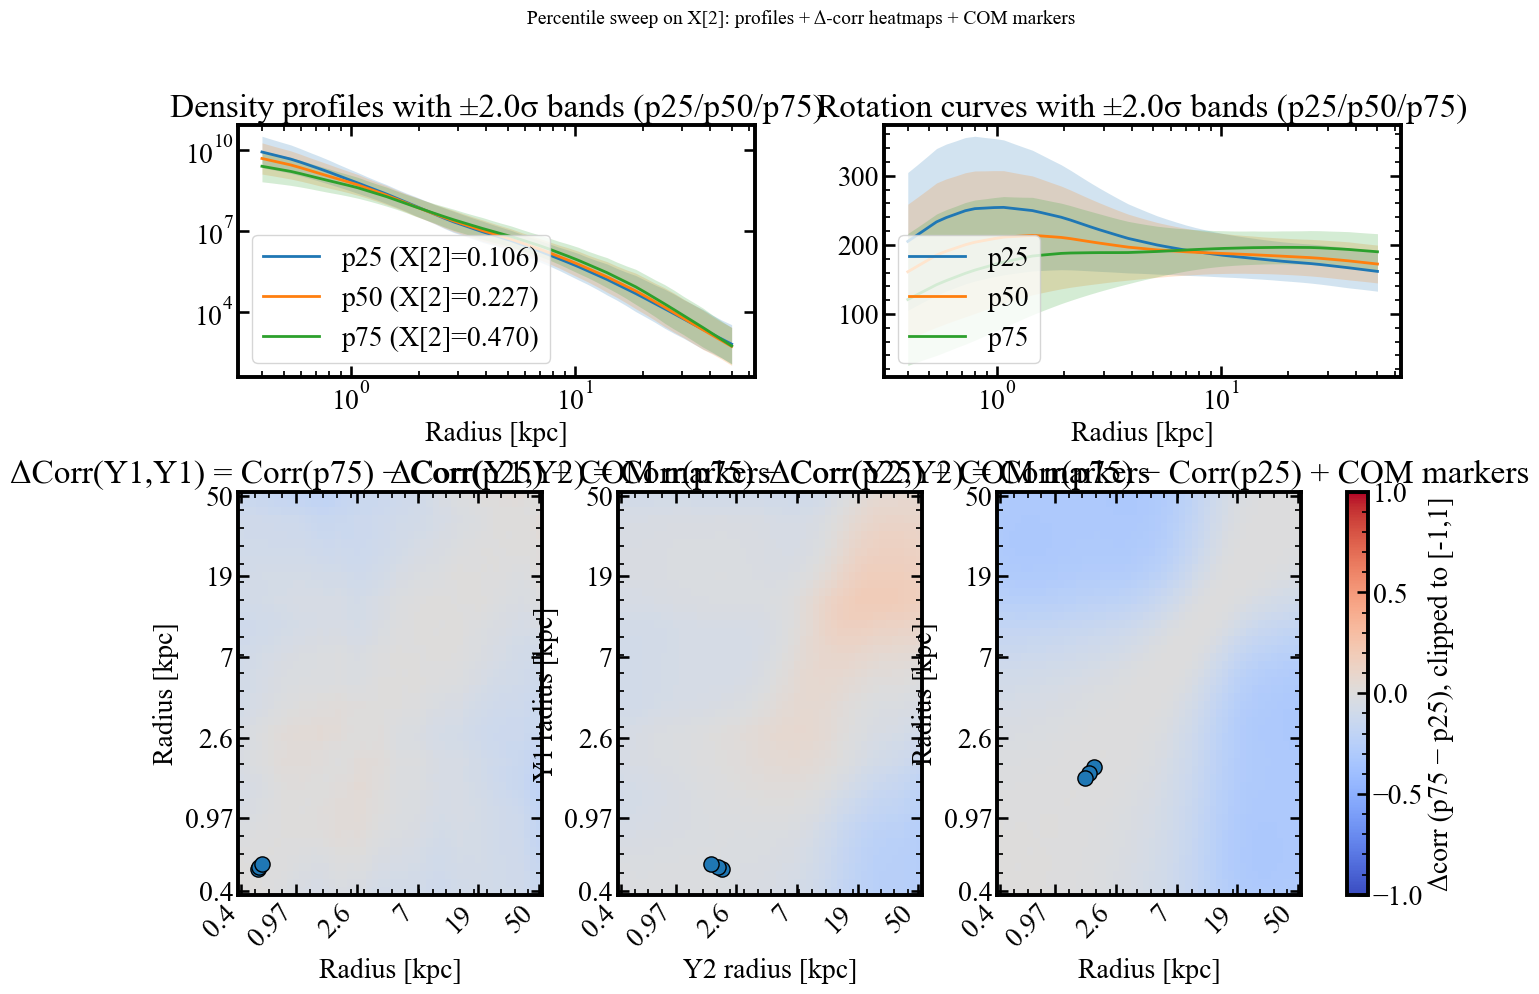

In [12]:
@torch.no_grad()
def plot_percentiles_and_cov_com_sweep(
    mean_net,
    cov_net,
    Xn_np,                 # normalized X array, shape [N, dx]
    sweep_idx: int,        # which X dim to sweep
    r_tags,                # radii (len=Y1_len)
    device,
    key_y,                 # Yn_key (coeff-space key)  (basis path)
    basis_meta,            # basis_meta with use_basis=True
    Y1_len=50,
    sweep_grid=121,        # number of sweep points for COM trajectory
    ci_sigma=2.0,
    n_r_ticks=6,
    savepath=None,
    title=None,
):
    """
    Plots:
      (A) Density + rotation curves at X[sweep_idx] = 25/50/75th percentiles (others held at 50th),
          with each percentile having its OWN ±ci_sigma band in the SAME color as its curve.
      (B) Δ-corr heatmaps: Corr(p75) - Corr(p25) for C11, C12, C22 (colorbar fixed to [-1,1]),
          with COM markers at p25/p50/p75 (from Σ-bins blocks).
    """

    # -------------------- sanity + basis handles --------------------
    use_basis = (basis_meta is not None) and bool(basis_meta.get("use_basis", False))
    if not use_basis:
        raise ValueError("Provide basis_meta with use_basis=True (coeff → bins).")

    Xn_np = np.asarray(Xn_np, dtype=np.float32)
    if Xn_np.ndim != 2:
        raise ValueError("Xn_np must be [N, dx] normalized inputs.")
    dx = Xn_np.shape[1]
    if not (0 <= sweep_idx < dx):
        raise ValueError(f"sweep_idx={sweep_idx} out of range (dx={dx}).")

    k1  = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    r = np.asarray(r_tags, dtype=float)

    # -------------------- percentiles in normalized X space --------------------
    x50 = np.nanpercentile(Xn_np, 50, axis=0).astype(np.float32)  # hold-all baseline at medians
    p25, p50, p75 = np.nanpercentile(Xn_np[:, sweep_idx], [25, 50, 75]).astype(np.float32)

    # -------------------- coeff-scale vector for Σ_c = D Σ_n D --------------------
    scales_c = _linear_scales_from_key(key_y).astype(np.float64)  # [d]
    D = np.diag(scales_c)

    # -------------------- helpers --------------------
    def _bins_and_blocks_from_xn(xn_vec: np.ndarray):
        """Return bin means, bin-space covariance, and corr blocks for a single normalized x."""
        xb = torch.from_numpy(xn_vec.astype(np.float32)).to(device).unsqueeze(0)  # [1,dx]
        mean_net.eval(); cov_net.eval()

        mu_n = mean_net(xb)                 # [1,d]
        L_n  = cov_net(xb)                  # [1,d,d]
        Sigma_n = (L_n @ L_n.transpose(1,2)).squeeze(0).detach().cpu().numpy()  # [d,d]
        mu_n_np = mu_n.squeeze(0).detach().cpu().numpy()                        # [d]

        # denorm coeff means
        c_mu = _denorm(mu_n_np, key_y).astype(np.float64)  # [d]
        c1_mu, c2_mu = c_mu[:k1], c_mu[k1:]

        # mean in bins
        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

        # coeff covariance -> bin covariance
        Sigma_c = D @ Sigma_n @ D.T
        Sigma_c11 = Sigma_c[:k1, :k1]
        Sigma_c22 = Sigma_c[k1:, k1:]
        Sigma_c12 = Sigma_c[:k1, k1:]

        # Jacobians into *linear* bin variables (ρ,v)
        J1_rho = (mu1[:, None] * Phi1) if LOG1 else Phi1
        J2     = (mu2[:, None] * Phi2) if LOG2 else Phi2

        S11 = J1_rho @ Sigma_c11 @ J1_rho.T
        S22 = J2     @ Sigma_c22 @ J2.T
        S12 = J1_rho @ Sigma_c12 @ J2.T

        # full Σ_bins for convenience
        top = np.hstack([S11, S12])
        bot = np.hstack([S12.T, S22])
        Sigma_bins = np.vstack([top, bot])  # [(Y1+Y2),(Y1+Y2)]

        # Corr blocks
        std = np.sqrt(np.clip(np.diag(Sigma_bins), 1e-12, None))
        Corr = Sigma_bins / (std[:, None] * std[None, :] + 1e-12)
        C11 = Corr[:Y1_len, :Y1_len]
        C12 = Corr[:Y1_len, Y1_len:]
        C22 = Corr[Y1_len:, Y1_len:]

        # bands
        if LOG1:
            Sigma_log = Phi1 @ Sigma_c11 @ Phi1.T
            std_log = np.sqrt(np.clip(np.diag(Sigma_log), 0.0, None))
            lower1 = np.exp(lin_mu1 - ci_sigma * std_log)
            upper1 = np.exp(lin_mu1 + ci_sigma * std_log)
        else:
            std1 = np.sqrt(np.clip(np.diag(S11), 0.0, None))
            lower1 = mu1 - ci_sigma * std1
            upper1 = mu1 + ci_sigma * std1

        std2 = np.sqrt(np.clip(np.diag(S22), 0.0, None))
        lower2 = mu2 - ci_sigma * std2
        upper2 = mu2 + ci_sigma * std2

        return mu1, mu2, lower1, upper1, lower2, upper2, Sigma_bins, C11, C12, C22

    def _com_ij(M: np.ndarray, use_abs=True):
        W = np.abs(M) if use_abs else M
        W = np.clip(W, 0.0, None)
        s = W.sum()
        if not np.isfinite(s) or s <= 0:
            h, w = M.shape
            return (0.5 * (w - 1), 0.5 * (h - 1))
        ii, jj = np.indices(M.shape)
        j_cm = (W * jj).sum() / s
        i_cm = (W * ii).sum() / s
        return (j_cm, i_cm)

    def _x_at(p):
        xn = x50.copy()
        xn[sweep_idx] = float(p)
        return xn

    # -------------------- compute percentile curves + bands --------------------
    xn_25 = _x_at(p25)
    xn_50 = _x_at(p50)
    xn_75 = _x_at(p75)

    mu1_25, mu2_25, lo1_25, up1_25, lo2_25, up2_25, _, C11_25, C12_25, C22_25 = _bins_and_blocks_from_xn(xn_25)
    mu1_50, mu2_50, lo1_50, up1_50, lo2_50, up2_50, _, _, _, _                 = _bins_and_blocks_from_xn(xn_50)
    mu1_75, mu2_75, lo1_75, up1_75, lo2_75, up2_75, _, C11_75, C12_75, C22_75 = _bins_and_blocks_from_xn(xn_75)

    # -------------------- Δ-corr heatmaps --------------------
    dC11 = np.clip(C11_75 - C11_25, -1.0, 1.0)
    dC12 = np.clip(C12_75 - C12_25, -1.0, 1.0)
    dC22 = np.clip(C22_75 - C22_25, -1.0, 1.0)

    # -------------------- COM markers at p25/p50/p75 (from Σ-bins) --------------------
    def _com_at(p):
        xn = x50.copy()
        xn[sweep_idx] = float(p)
        _, _, _, _, _, _, Sigma_bins, _, _, _ = _bins_and_blocks_from_xn(xn)
        S11 = Sigma_bins[:Y1_len, :Y1_len]
        S12 = Sigma_bins[:Y1_len, Y1_len:]
        S22 = Sigma_bins[Y1_len:, Y1_len:]
        return _com_ij(S11), _com_ij(S12), _com_ij(S22)

    com25_11, com25_12, com25_22 = _com_at(p25)
    com50_11, com50_12, com50_22 = _com_at(p50)
    com75_11, com75_12, com75_22 = _com_at(p75)

    # -------------------- plotting --------------------
    tick_idx = np.unique(np.linspace(0, Y1_len - 1, n_r_ticks).astype(int))
    tick_lbl = [f"{r[i]:.2g}" for i in tick_idx]

    fig = plt.figure(figsize=(15, 10))
    outer = fig.add_gridspec(2, 1, height_ratios=[1.0, 1.6], hspace=0.35)

    # Top: density + rotation
    top = outer[0].subgridspec(1, 2, wspace=0.25)
    axD = fig.add_subplot(top[0, 0])
    axV = fig.add_subplot(top[0, 1])

    # ---- Density curves + same-color bands (grab colors from the line objects) ----
    l25, = axD.plot(r, mu1_25, lw=2.0, label=f"p25 (X[{sweep_idx}]={p25:.3f})")
    c25 = l25.get_color()
    axD.fill_between(r, lo1_25, up1_25, alpha=0.20, color=c25, linewidth=0)

    l50, = axD.plot(r, mu1_50, lw=2.0, label=f"p50 (X[{sweep_idx}]={p50:.3f})")
    c50 = l50.get_color()
    axD.fill_between(r, lo1_50, up1_50, alpha=0.20, color=c50, linewidth=0)

    l75, = axD.plot(r, mu1_75, lw=2.0, label=f"p75 (X[{sweep_idx}]={p75:.3f})")
    c75 = l75.get_color()
    axD.fill_between(r, lo1_75, up1_75, alpha=0.20, color=c75, linewidth=0)

    axD.set_xscale("log"); axD.set_yscale("log")
    axD.set_xlabel("Radius [kpc]")
    axD.set_title(f"Density profiles with ±{ci_sigma}σ bands (p25/p50/p75)")
    axD.legend(loc="best")

    # ---- Rotation curves + same-color bands ----
    m25, = axV.plot(r, mu2_25, lw=2.0, label="p25")
    cv25 = m25.get_color()
    axV.fill_between(r, lo2_25, up2_25, alpha=0.20, color=cv25, linewidth=0)

    m50, = axV.plot(r, mu2_50, lw=2.0, label="p50")
    cv50 = m50.get_color()
    axV.fill_between(r, lo2_50, up2_50, alpha=0.20, color=cv50, linewidth=0)

    m75, = axV.plot(r, mu2_75, lw=2.0, label="p75")
    cv75 = m75.get_color()
    axV.fill_between(r, lo2_75, up2_75, alpha=0.20, color=cv75, linewidth=0)

    axV.set_xscale("log")
    axV.set_xlabel("Radius [kpc]")
    axV.set_title(f"Rotation curves with ±{ci_sigma}σ bands (p25/p50/p75)")
    axV.legend(loc="best")

    # Bottom: Δ-corr heatmaps + COM dots
    bot = outer[1].subgridspec(1, 3, wspace=0.25)
    ax11 = fig.add_subplot(bot[0, 0])
    ax12 = fig.add_subplot(bot[0, 1])
    ax22 = fig.add_subplot(bot[0, 2])

    im11 = ax11.imshow(dC11, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im12 = ax12.imshow(dC12, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im22 = ax22.imshow(dC22, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")

    for ax, ttl, xlbl, ylbl in [
        (ax11, "ΔCorr(Y1,Y1) = Corr(p75) − Corr(p25) + COM markers", "Radius [kpc]", "Radius [kpc]"),
        (ax12, "ΔCorr(Y1,Y2) = Corr(p75) − Corr(p25) + COM markers", "Y2 radius [kpc]", "Y1 radius [kpc]"),
        (ax22, "ΔCorr(Y2,Y2) = Corr(p75) − Corr(p25) + COM markers", "Radius [kpc]", "Radius [kpc]"),
    ]:
        ax.set_title(ttl)
        ax.set_xlabel(xlbl); ax.set_ylabel(ylbl)
        ax.set_xticks(tick_idx); ax.set_xticklabels(tick_lbl, rotation=45, ha="right")
        ax.set_yticks(tick_idx); ax.set_yticklabels(tick_lbl)
        ax.invert_yaxis()

    ax11.scatter([com25_11[0], com50_11[0], com75_11[0]],
                 [com25_11[1], com50_11[1], com75_11[1]],
                 s=120, edgecolors="k", linewidths=1.0, zorder=5)
    ax12.scatter([com25_12[0], com50_12[0], com75_12[0]],
                 [com25_12[1], com50_12[1], com75_12[1]],
                 s=120, edgecolors="k", linewidths=1.0, zorder=5)
    ax22.scatter([com25_22[0], com50_22[0], com75_22[0]],
                 [com25_22[1], com50_22[1], com75_22[1]],
                 s=120, edgecolors="k", linewidths=1.0, zorder=5)

    cbar = fig.colorbar(im22, ax=[ax11, ax12, ax22], fraction=0.046, pad=0.04)
    cbar.set_label("Δcorr (p75 − p25), clipped to [-1,1]")

    if title is None:
        title = f"Percentile sweep on X[{sweep_idx}]: profiles + Δ-corr heatmaps + COM markers"
    fig.suptitle(title, y=0.995, fontsize=14)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=170)
        print("Saved:", savepath)
    return fig


# -------------------- example usage --------------------
# (Assumes you already have: mean_net, cov_net, device, Xn (np array), r_tags, Yn_key, basis_meta)
# This matches your existing basis-path plotting/animation style. :contentReference[oaicite:4]{index=4}

fig = plot_percentiles_and_cov_com_sweep(
    STO_mean_net, STO_cov_net,
    Xn_np=STO_Xn,          # normalized inputs you already build
    sweep_idx=2,       # e.g. mass-like feature index
    r_tags=r_tags,
    device=device,
    key_y=STO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    sweep_grid=121,
    ci_sigma=2.0,
    savepath="/home/gjc7gx/CovNNet/Figures/pctl_sweep_with_COM.png",
)


Saved: STO_percentile_profiles.png
Saved: STO_percentile_profiles.png


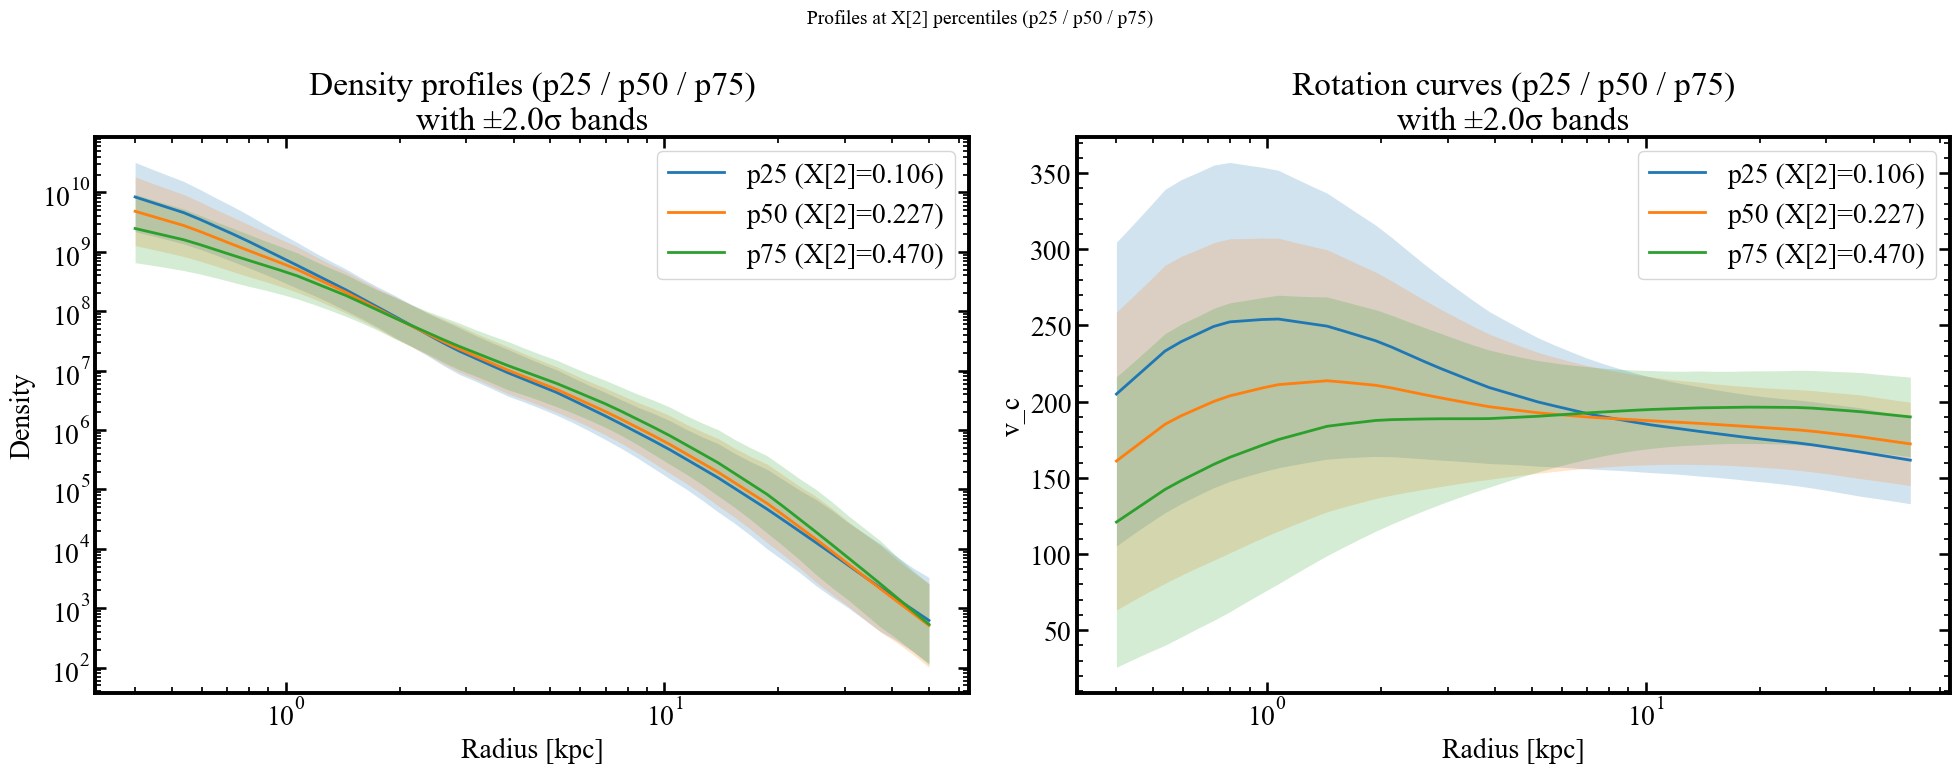

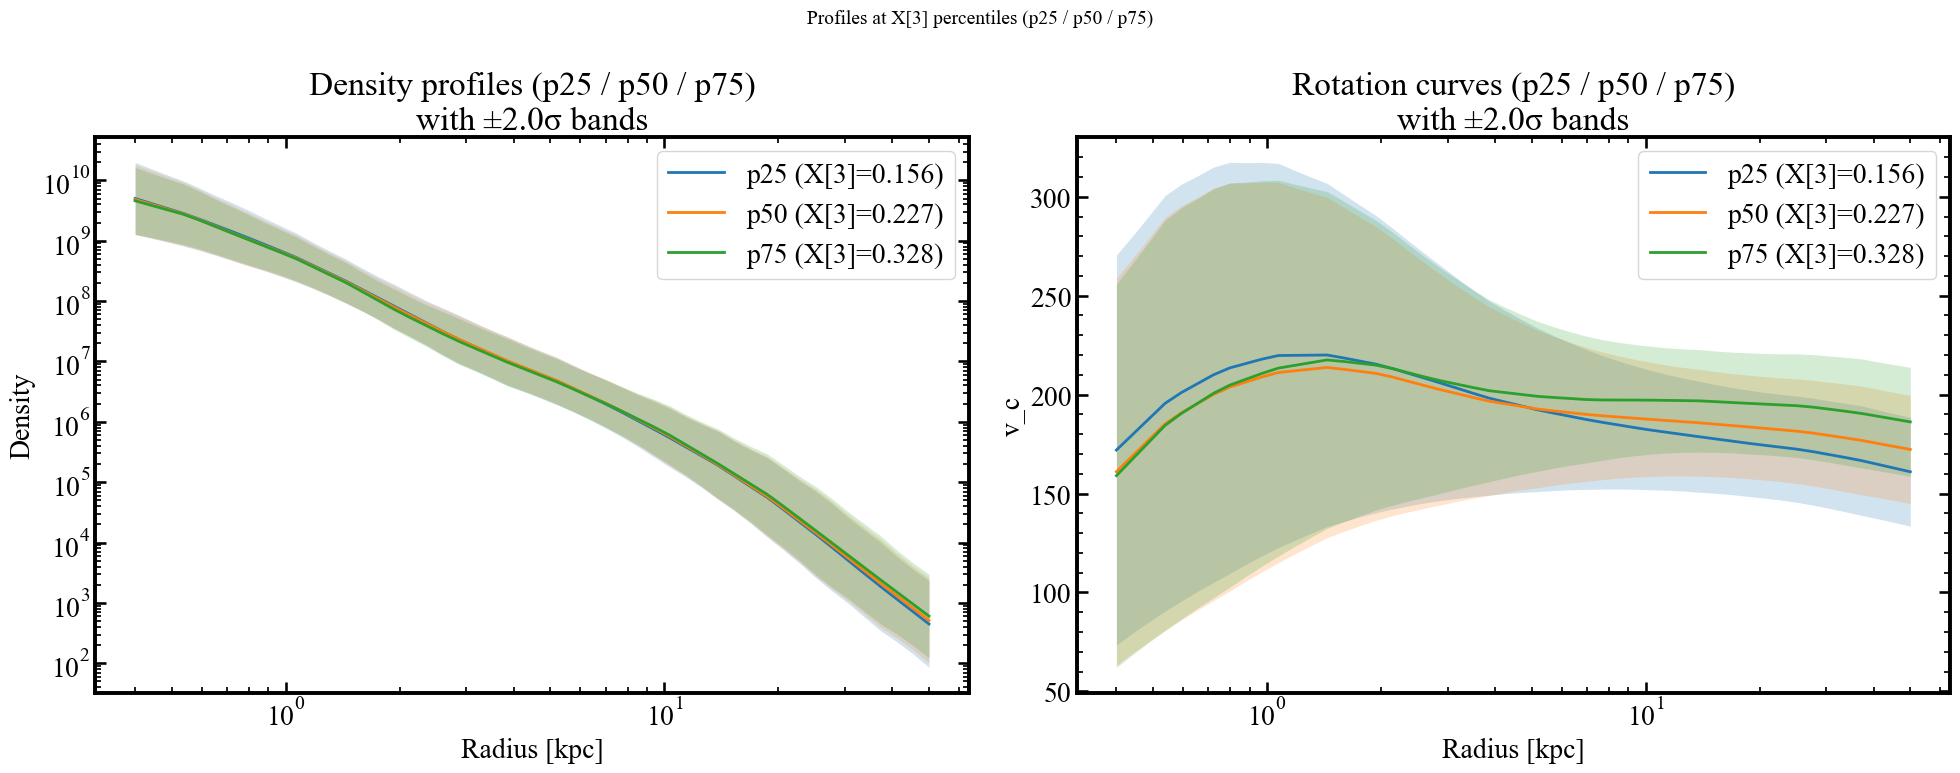

In [13]:
@torch.no_grad()
def plot_percentiles(
    mean_net,
    cov_net,
    Xn_np,                 # normalized X array, shape [N, dx]
    sweep_idx: int,        # which X dim to sweep
    r_tags,                # radii (len=Y1_len)
    device,
    key_y,                 # Yn_key (coeff-space key)  (basis path)
    basis_meta,            # basis_meta with use_basis=True
    Y1_len=50,
    sweep_grid=121,        # unused now, kept for API compatibility
    ci_sigma=2.0,
    n_r_ticks=6,           # unused now, kept for API compatibility
    savepath=None,
    title=None,
):
    """
    Plot only the density and rotation curves at X[sweep_idx] = p25, p50, p75
    (others held at their 50th percentile), each with its own ±ci_sigma band.

    No corr blocks or COM migration.
    """

    # -------------------- sanity + basis handles --------------------
    use_basis = (basis_meta is not None) and bool(basis_meta.get("use_basis", False))
    if not use_basis:
        raise ValueError("Provide basis_meta with use_basis=True (coeff → bins).")

    Xn_np = np.asarray(Xn_np, dtype=np.float32)
    if Xn_np.ndim != 2:
        raise ValueError("Xn_np must be [N, dx] normalized inputs.")
    dx = Xn_np.shape[1]
    if not (0 <= sweep_idx < dx):
        raise ValueError(f"sweep_idx={sweep_idx} out of range (dx={dx}).")

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    r = np.asarray(r_tags, dtype=float)

    # -------------------- percentiles in normalized X space --------------------
    # baseline: all other dims at their median (50th percentile)
    x50_all = np.nanpercentile(Xn_np, 50, axis=0).astype(np.float32)
    p25, p50, p75 = np.nanpercentile(Xn_np[:, sweep_idx], [25, 50, 75]).astype(np.float32)

    # -------------------- coeff-scale vector for Σ_c = D Σ_n D --------------------
    scales_c = _linear_scales_from_key(key_y).astype(np.float64)  # [d]
    D = np.diag(scales_c)

    # -------------------- helper: means + bands only --------------------
    def _bins_and_bands_from_xn(xn_vec: np.ndarray):
        """
        For a single normalized input xn_vec, return
        mu1, mu2, lower1, upper1, lower2, upper2 (bin space).
        """
        xb = torch.from_numpy(xn_vec.astype(np.float32)).to(device).unsqueeze(0)  # [1, dx]
        mean_net.eval()
        cov_net.eval()

        mu_n = mean_net(xb)                 # [1, d]
        L_n  = cov_net(xb)                  # [1, d, d]
        Sigma_n = (L_n @ L_n.transpose(1, 2)).squeeze(0).detach().cpu().numpy()  # [d, d]
        mu_n_np = mu_n.squeeze(0).detach().cpu().numpy()                          # [d]

        # denorm coeff means
        c_mu = _denorm(mu_n_np, key_y).astype(np.float64)  # [d]
        c1_mu, c2_mu = c_mu[:k1], c_mu[k1:]

        # mean in bins
        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

        # coeff covariance -> bin covariance (per block)
        Sigma_c   = D @ Sigma_n @ D.T
        Sigma_c11 = Sigma_c[:k1, :k1]
        Sigma_c22 = Sigma_c[k1:, k1:]

        # ----- Y1 band -----
        if LOG1:
            # covariance in log ρ
            Sigma_log_y1 = Phi1 @ Sigma_c11 @ Phi1.T
            std_log_y1   = np.sqrt(np.clip(np.diag(Sigma_log_y1), 0.0, None))
            lower1 = np.exp(lin_mu1 - ci_sigma * std_log_y1)
            upper1 = np.exp(lin_mu1 + ci_sigma * std_log_y1)
        else:
            # linear band
            S11   = Phi1 @ Sigma_c11 @ Phi1.T
            std1  = np.sqrt(np.clip(np.diag(S11), 0.0, None))
            lower1 = mu1 - ci_sigma * std1
            upper1 = mu1 + ci_sigma * std1

        # ----- Y2 band -----
        if LOG2:
            # treat v in log-space if requested (less typical, but allowed by basis_meta)
            Sigma_log_y2 = Phi2 @ Sigma_c22 @ Phi2.T
            std_log_y2   = np.sqrt(np.clip(np.diag(Sigma_log_y2), 0.0, None))
            lower2 = np.exp(lin_mu2 - ci_sigma * std_log_y2)
            upper2 = np.exp(lin_mu2 + ci_sigma * std_log_y2)
        else:
            S22   = Phi2 @ Sigma_c22 @ Phi2.T
            std2  = np.sqrt(np.clip(np.diag(S22), 0.0, None))
            lower2 = mu2 - ci_sigma * std2
            upper2 = mu2 + ci_sigma * std2

        return mu1, mu2, lower1, upper1, lower2, upper2

    def _xn_at(p):
        xn = x50_all.copy()
        xn[sweep_idx] = float(p)
        return xn

    # -------------------- compute percentile curves + bands --------------------
    xn_25 = _xn_at(p25)
    xn_50 = _xn_at(p50)
    xn_75 = _xn_at(p75)

    mu1_25, mu2_25, lo1_25, up1_25, lo2_25, up2_25 = _bins_and_bands_from_xn(xn_25)
    mu1_50, mu2_50, lo1_50, up1_50, lo2_50, up2_50 = _bins_and_bands_from_xn(xn_50)
    mu1_75, mu2_75, lo1_75, up1_75, lo2_75, up2_75 = _bins_and_bands_from_xn(xn_75)

    # -------------------- plotting: just density + rotation --------------------
    fig, (axD, axV) = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

    # density
    l25, = axD.plot(r, mu1_25, lw=2.0, label=f"p25 (X[{sweep_idx}]={p25:.3f})")
    c25 = l25.get_color()
    axD.fill_between(r, lo1_25, up1_25, alpha=0.20, color=c25, linewidth=0)

    l50, = axD.plot(r, mu1_50, lw=2.0, label=f"p50 (X[{sweep_idx}]={p50:.3f})")
    c50 = l50.get_color()
    axD.fill_between(r, lo1_50, up1_50, alpha=0.20, color=c50, linewidth=0)

    l75, = axD.plot(r, mu1_75, lw=2.0, label=f"p75 (X[{sweep_idx}]={p75:.3f})")
    c75 = l75.get_color()
    axD.fill_between(r, lo1_75, up1_75, alpha=0.20, color=c75, linewidth=0)

    axD.set_xscale("log")
    axD.set_yscale("log")
    axD.set_xlabel("Radius [kpc]")
    axD.set_ylabel("Density")
    axD.set_title(f"Density profiles (p25 / p50 / p75)\nwith ±{ci_sigma}σ bands")
    axD.legend(loc="best")

    # rotation
    m25, = axV.plot(r, mu2_25, lw=2.0, label=f"p25 (X[{sweep_idx}]={p25:.3f})")
    cv25 = m25.get_color()
    axV.fill_between(r, lo2_25, up2_25, alpha=0.20, color=cv25, linewidth=0)

    m50, = axV.plot(r, mu2_50, lw=2.0, label=f"p50 (X[{sweep_idx}]={p50:.3f})")
    cv50 = m50.get_color()
    axV.fill_between(r, lo2_50, up2_50, alpha=0.20, color=cv50, linewidth=0)

    m75, = axV.plot(r, mu2_75, lw=2.0, label=f"p75 (X[{sweep_idx}]={p75:.3f})")
    cv75 = m75.get_color()
    axV.fill_between(r, lo2_75, up2_75, alpha=0.20, color=cv75, linewidth=0)

    axV.set_xscale("log")
    axV.set_xlabel("Radius [kpc]")
    axV.set_ylabel("v_c")
    axV.set_title(f"Rotation curves (p25 / p50 / p75)\nwith ±{ci_sigma}σ bands")
    axV.legend(loc="best")

    if title is None:
        title = f"Profiles at X[{sweep_idx}] percentiles (p25 / p50 / p75)"
    fig.suptitle(title, y=0.98, fontsize=14)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=170)
        print("Saved:", savepath)
    return fig


fig = plot_percentiles(
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    Xn_np=STO_Xn,           # normalized X
    sweep_idx=2,            # whichever feature you’re sweeping
    r_tags=r_tags,
    device=device,
    key_y=STO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    ci_sigma=2.0,
    savepath="STO_percentile_profiles.png",
)

fig = plot_percentiles(
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    Xn_np=STO_Xn,           # normalized X
    sweep_idx=3,            # whichever feature you’re sweeping
    r_tags=r_tags,
    device=device,
    key_y=STO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    ci_sigma=2.0,
    savepath="STO_percentile_profiles.png",
)


In [14]:
@torch.no_grad()
def compute_total_com_migration_per_X_kpc(
    mean_net,
    cov_net,
    Xn_np,              # [N, dx] normalized inputs
    r_tags,             # [Y1_len] radii in kpc (used for BOTH Y1 and Y2 axes)
    device,
    key_y,
    basis_meta,
    Y1_len=50,
    use_abs_weights=True,     # recommended True
    eps=1e-12,
):
    """
    For each X dimension j:
      - hold other X dims at global median
      - evaluate at p25, p50, p75 of X[:,j]
      - compute COM of Σ-bins blocks S11, S12, S22 in *kpc-kpc* coordinate space
      - return total migration: |25->50| + |50->75| in kpc (Euclidean in the 2D plane)

    Returns:
      dict: {"C11": [dx], "C12": [dx], "C22": [dx]}
    """

    Xn_np = np.asarray(Xn_np, dtype=np.float32)
    r = np.asarray(r_tags, dtype=np.float64)
    N, dx = Xn_np.shape

    if len(r) != Y1_len:
        raise ValueError(f"len(r_tags)={len(r)} must match Y1_len={Y1_len}")

    # basis handles
    k1  = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    # coeff-scale
    scales_c = _linear_scales_from_key(key_y).astype(np.float64)
    D = np.diag(scales_c)

    # median anchor point for non-swept dims
    x_med = np.nanpercentile(Xn_np, 50, axis=0).astype(np.float32)

    def _cov_blocks_from_xn(xn_vec):
        """Return Σ-bins blocks S11, S12, S22 (not correlation)."""
        xb = torch.tensor(xn_vec, device=device).unsqueeze(0)

        mean_net.eval(); cov_net.eval()
        mu_n = mean_net(xb)            # [1,d]
        L_n  = cov_net(xb)             # [1,d,d]
        Sigma_n = (L_n @ L_n.transpose(1, 2))[0].detach().cpu().numpy()  # [d,d]

        # mean coeffs (for Jacobians)
        c_mu = _denorm(mu_n[0].detach().cpu().numpy(), key_y).astype(np.float64)
        c1_mu, c2_mu = c_mu[:k1], c_mu[k1:]

        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

        Sigma_c = D @ Sigma_n @ D.T
        Sigma_c11 = Sigma_c[:k1, :k1]
        Sigma_c22 = Sigma_c[k1:, k1:]
        Sigma_c12 = Sigma_c[:k1, k1:]

        J1 = (mu1[:, None] * Phi1) if LOG1 else Phi1
        J2 = (mu2[:, None] * Phi2) if LOG2 else Phi2

        S11 = J1 @ Sigma_c11 @ J1.T          # [Y1_len,Y1_len]
        S12 = J1 @ Sigma_c12 @ J2.T          # [Y1_len,Y1_len]
        S22 = J2 @ Sigma_c22 @ J2.T          # [Y1_len,Y1_len]
        return S11, S12, S22

    def _com_kpc(M, ry, rx):
        """
        Center of mass for matrix M whose rows map to radii ry (kpc) and cols map to radii rx (kpc).
        Returns (x_cm_kpc, y_cm_kpc).
        """
        W = np.abs(M) if use_abs_weights else M
        if use_abs_weights:
            W = np.clip(W, 0.0, None)

        s = W.sum()
        if (not np.isfinite(s)) or s <= eps:
            # fallback: geometric center in kpc
            return float(rx[len(rx)//2]), float(ry[len(ry)//2])

        # Weighted average of coordinate grids without building full mesh
        # x_cm = sum_j (rx[j] * sum_i W[i,j]) / sum_{i,j} W
        col_sums = W.sum(axis=0)
        row_sums = W.sum(axis=1)

        x_cm = float((rx * col_sums).sum() / s)
        y_cm = float((ry * row_sums).sum() / s)
        return x_cm, y_cm

    def _x_at(j, p):
        x = x_med.copy()
        x[j] = float(p)
        return x

    mig_C11 = np.zeros(dx, dtype=np.float64)
    mig_C12 = np.zeros(dx, dtype=np.float64)
    mig_C22 = np.zeros(dx, dtype=np.float64)

    for j in range(dx):
        p25, p50, p75 = np.nanpercentile(Xn_np[:, j], [25, 50, 75])

        S11_25, S12_25, S22_25 = _cov_blocks_from_xn(_x_at(j, p25))
        S11_50, S12_50, S22_50 = _cov_blocks_from_xn(_x_at(j, p50))
        S11_75, S12_75, S22_75 = _cov_blocks_from_xn(_x_at(j, p75))

        # axes for each block:
        # C11: y=r (Y1), x=r (Y1)
        # C12: y=r (Y1), x=r (Y2)  -> you use same r_tags for both in your plotting
        # C22: y=r (Y2), x=r (Y2)
        c11_25 = np.array(_com_kpc(S11_25, r, r))
        c11_50 = np.array(_com_kpc(S11_50, r, r))
        c11_75 = np.array(_com_kpc(S11_75, r, r))

        c12_25 = np.array(_com_kpc(S12_25, r, r))
        c12_50 = np.array(_com_kpc(S12_50, r, r))
        c12_75 = np.array(_com_kpc(S12_75, r, r))

        c22_25 = np.array(_com_kpc(S22_25, r, r))
        c22_50 = np.array(_com_kpc(S22_50, r, r))
        c22_75 = np.array(_com_kpc(S22_75, r, r))

        mig_C11[j] = np.linalg.norm(c11_25 - c11_50) + np.linalg.norm(c11_50 - c11_75)
        mig_C12[j] = np.linalg.norm(c12_25 - c12_50) + np.linalg.norm(c12_50 - c12_75)
        mig_C22[j] = np.linalg.norm(c22_25 - c22_50) + np.linalg.norm(c22_50 - c22_75)

    return {"C11": mig_C11, "C12": mig_C12, "C22": mig_C22}



In [15]:
ALL_mig_kpc = compute_total_com_migration_per_X_kpc(
    mean_net=ALL_mean_net,
    cov_net=ALL_cov_net,
    Xn_np=ALL_Xn,
    r_tags=r_tags,
    device=device,
    key_y=ALL_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    use_abs_weights=True,   # recommended
)

STO_mig_kpc = compute_total_com_migration_per_X_kpc(
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    Xn_np=STO_Xn,
    r_tags=r_tags,
    device=device,
    key_y=STO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    use_abs_weights=True,   # recommended
)

DMO_mig_kpc = compute_total_com_migration_per_X_kpc(
    mean_net=DMO_mean_net,
    cov_net=DMO_cov_net,
    Xn_np=DMO_Xn,
    r_tags=r_tags,
    device=device,
    key_y=DMO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
    use_abs_weights=True,   # recommended
)

ALL_total = ALL_mig_kpc["C11"] + ALL_mig_kpc["C12"] + ALL_mig_kpc["C22"]
DMO_total = DMO_mig_kpc["C11"] + DMO_mig_kpc["C12"] + DMO_mig_kpc["C22"]
STO_total = STO_mig_kpc["C11"] + STO_mig_kpc["C12"] + STO_mig_kpc["C22"]

dx = DMO_Xn.shape[1]
print("\nTotal COM migration (kpc) per X")
print("================================")
for j in range(dx):
    print(f"{param_labels[j]}  ALL={ALL_total[j]:10.4f}  DMO={DMO_total[j]:10.4f}  STO={STO_total[j]:10.4f}")




Total COM migration (kpc) per X
$Ωm$  ALL=    0.0297  DMO=    0.0904  STO=    0.0891
$s8$  ALL=    0.1162  DMO=    0.1297  STO=    0.2523
$SN1$  ALL=    0.8569  DMO=    1.1590  STO=    2.4768
$SN2$  ALL=    0.7377  DMO=    1.3216  STO=    1.4147
$BHFF$  ALL=    0.0585  DMO=    0.1401  STO=    0.1966
$M_{int}$  ALL=    0.8506  DMO=    0.1151  STO=    2.3051
$Con$  ALL=    0.0007  DMO=    0.6262  STO=    0.0016


In [16]:
def print_com_migration_latex_table_pretty(
    param_labels,
    ALL_total,
    DMO_total,
    STO_total,
    caption=r"Total center-of-mass migration $\Delta_{\mathrm{COM}}^{\mathrm{model}}$ (kpc) for each input parameter.",
    label="tab:com_migration_kpc",
    fmt="{:.2f}",
):
    def tex_escape(s):
        return s.replace("_", r"\_")

    print(r"\begingroup")
    print(r"    \setlength{\tabcolsep}{10pt}")
    print(r"    \renewcommand{\arraystretch}{1.5}")
    print(r"    \setlength\extrarowheight{2pt}")
    print(r"    \begin{table}[htbp]")
    print(r"        \centering")
    print(r"        \begin{tabular}{ c c c c }")
    print(r"            Parameter & ALL & DMO & STO \\")
    print(r"            \hline \hline")

    for j, name in enumerate(param_labels):
        pname = f"${tex_escape(name)}$"
        all_v = fmt.format(ALL_total[j])
        dmo_v = fmt.format(DMO_total[j])
        sto_v = fmt.format(STO_total[j])
        print(f"            {pname} & {all_v} & {dmo_v} & {sto_v} \\\\")

    print(r"            \hline \hline")
    print(r"        \end{tabular}")
    print(f"        \\caption{{{caption}}}")
    print(f"        \\label{{{label}}}")
    print(r"    \end{table}")
    print(r"\endgroup")


In [17]:
print_com_migration_latex_table_pretty(
    param_labels=param_labels,
    ALL_total=ALL_total,
    DMO_total=DMO_total,
    STO_total=STO_total,
    fmt="{:.2f}",
)


\begingroup
    \setlength{\tabcolsep}{10pt}
    \renewcommand{\arraystretch}{1.5}
    \setlength\extrarowheight{2pt}
    \begin{table}[htbp]
        \centering
        \begin{tabular}{ c c c c }
            Parameter & ALL & DMO & STO \\
            \hline \hline
            $$Ωm$$ & 0.03 & 0.09 & 0.09 \\
            $$s8$$ & 0.12 & 0.13 & 0.25 \\
            $$SN1$$ & 0.86 & 1.16 & 2.48 \\
            $$SN2$$ & 0.74 & 1.32 & 1.41 \\
            $$BHFF$$ & 0.06 & 0.14 & 0.20 \\
            $$M\_{int}$$ & 0.85 & 0.12 & 2.31 \\
            $$Con$$ & 0.00 & 0.63 & 0.00 \\
            \hline \hline
        \end{tabular}
        \caption{Total center-of-mass migration $\Delta_{\mathrm{COM}}^{\mathrm{model}}$ (kpc) for each input parameter.}
        \label{tab:com_migration_kpc}
    \end{table}
\endgroup


In [18]:
@torch.no_grad()
def compute_cov_structure_invariance_Fnorm(
    mean_net,
    cov_net,
    Xn_np,              # [N, dx] normalized inputs
    device,
    key_y,              # Yn_key used by your _denorm + _linear_scales_from_key
    basis_meta,         # must include y1/y2 Phi, k, logspace
    Y1_len=50,          # number of radial bins for Y1 (and Y2 assumed same length)
    eps=1e-12,
):
    """
    Physical-space version of Option B.

    Computes a single scalar per input dimension X_j measuring how much the
    *physical (binned) correlation structure* changes when X_j varies.

    Metric:
        S_F_phys(X_j) = sum_B ||C_B^bin(p75) - C_B^bin(p25)||_F
                               ---------------------------------
                               ||C_B^bin(p50)||_F + eps

    where B ∈ {11,12,22} and C_B^bin are correlation blocks in BIN SPACE
    (ρ(r) bins and v(r) bins), produced via the basis Jacobians.

    Returns:
        np.ndarray [dx] (smaller => more invariant physical covariance structure)
    """

    # -------------------- sanity + basis handles --------------------
    use_basis = (basis_meta is not None) and bool(basis_meta.get("use_basis", False))
    if not use_basis:
        raise ValueError("Provide basis_meta with use_basis=True (coeff → bins).")

    Xn_np = np.asarray(Xn_np, dtype=np.float32)
    if Xn_np.ndim != 2:
        raise ValueError("Xn_np must be [N, dx].")
    N, dx = Xn_np.shape

    # hold-all baseline at medians
    x_med = np.nanpercentile(Xn_np, 50, axis=0).astype(np.float32)

    # basis matrices + metadata
    k1   = int(basis_meta["y1"]["k"])
    k2   = int(basis_meta["y2"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y1_len, k2] (assumed same bin count)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    if Phi1.shape[0] != Y1_len or Phi2.shape[0] != Y1_len:
        raise ValueError(f"Expected Phi1/Phi2 first dimension == Y1_len={Y1_len}, got {Phi1.shape[0]}, {Phi2.shape[0]}.")

    # coeff scaling: Sigma_c = D Sigma_n D^T
    scales_c = _linear_scales_from_key(key_y).astype(np.float64)  # [d]
    D = np.diag(scales_c)

    # -------------------- helper: bin-space correlation blocks --------------------
    def _corr_blocks_bin_from_xn(xn_vec):
        xb = torch.tensor(xn_vec, device=device).unsqueeze(0)
        mean_net.eval(); cov_net.eval()

        mu_n = mean_net(xb)                 # [1,d]
        L_n  = cov_net(xb)                  # [1,d,d]
        Sigma_n = (L_n @ L_n.transpose(1, 2))[0].detach().cpu().numpy()  # [d,d]
        mu_n_np = mu_n[0].detach().cpu().numpy()                         # [d]

        # denormalize coefficient mean (for Jacobians)
        c_mu = _denorm(mu_n_np, key_y).astype(np.float64)                # [d]
        c1_mu = c_mu[:k1]
        c2_mu = c_mu[k1:k1+k2]

        # mean in bins (linear variables)
        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1   # density bins (linear rho)
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2   # rotation bins (linear v)

        # coeff covariance in coefficient units
        Sigma_c = D @ Sigma_n @ D.T
        Sigma_c11 = Sigma_c[:k1, :k1]
        Sigma_c22 = Sigma_c[k1:k1+k2, k1:k1+k2]
        Sigma_c12 = Sigma_c[:k1, k1:k1+k2]

        # Jacobians into *linear bin variables* (rho, v)
        J1 = (mu1[:, None] * Phi1) if LOG1 else Phi1   # d(rho)/d(coeff1)
        J2 = (mu2[:, None] * Phi2) if LOG2 else Phi2   # d(v)/d(coeff2)

        # bin-space covariance blocks
        S11 = J1 @ Sigma_c11 @ J1.T
        S22 = J2 @ Sigma_c22 @ J2.T
        S12 = J1 @ Sigma_c12 @ J2.T

        # full bin covariance -> correlation
        top = np.hstack([S11, S12])
        bot = np.hstack([S12.T, S22])
        Sigma_bins = np.vstack([top, bot])  # [(Y1+Y2),(Y1+Y2)]

        std = np.sqrt(np.clip(np.diag(Sigma_bins), eps, None))
        Corr_bins = Sigma_bins / (std[:, None] * std[None, :] + eps)

        C11 = Corr_bins[:Y1_len, :Y1_len]
        C12 = Corr_bins[:Y1_len, Y1_len:]
        C22 = Corr_bins[Y1_len:, Y1_len:]
        return C11, C12, C22

    # -------------------- main loop: one scalar per X dim --------------------
    S_F = np.zeros(dx, dtype=np.float64)

    for j in range(dx):
        p25, p50, p75 = np.nanpercentile(Xn_np[:, j], [25, 50, 75])

        def x_at(p):
            x = x_med.copy()
            x[j] = float(p)
            return x

        C11_25, C12_25, C22_25 = _corr_blocks_bin_from_xn(x_at(p25))
        C11_50, C12_50, C22_50 = _corr_blocks_bin_from_xn(x_at(p50))
        C11_75, C12_75, C22_75 = _corr_blocks_bin_from_xn(x_at(p75))

        d11 = np.linalg.norm(C11_75 - C11_25, ord="fro") / (np.linalg.norm(C11_50, ord="fro") + eps)
        d12 = np.linalg.norm(C12_75 - C12_25, ord="fro") / (np.linalg.norm(C12_50, ord="fro") + eps)
        d22 = np.linalg.norm(C22_75 - C22_25, ord="fro") / (np.linalg.norm(C22_50, ord="fro") + eps)

        # S_F[j] = d11 + d12 + d22
        S_F[j] = d12

    return S_F



In [19]:
ALL_S_F = compute_cov_structure_invariance_Fnorm(
    mean_net=ALL_mean_net,
    cov_net=ALL_cov_net,
    Xn_np=ALL_Xn,
    device=device,
    key_y=ALL_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
)

DMO_S_F = compute_cov_structure_invariance_Fnorm(
    mean_net=DMO_mean_net,
    cov_net=DMO_cov_net,
    Xn_np=DMO_Xn,
    device=device,
    key_y=DMO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
)

STO_S_F = compute_cov_structure_invariance_Fnorm(
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    Xn_np=STO_Xn,
    device=device,
    key_y=STO_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
)

Other_S_F = compute_cov_structure_invariance_Fnorm(
    mean_net=Other_mean_net,
    cov_net=Other_cov_net,
    Xn_np=Other_Xn,
    device=device,
    key_y=Other_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
)

NOMASS_S_F = compute_cov_structure_invariance_Fnorm(
    mean_net=NOMASS_ALL_mean_net,
    cov_net=NOMASS_ALL_cov_net,
    Xn_np=NOMASS_ALL_Xn,
    device=device,
    key_y=NOMASS_ALL_Yn_key,
    basis_meta=basis_meta,
    Y1_len=50,
)

dx = STO_Xn.shape[1]

print("\nNormalized covariance-structure change metric")
print("=========================================================")

for j in range(dx):
    if j<dx-2:
        print(f"{param_labels[j]:<12s}  ALL = {ALL_S_F[j]:.3e}  DMO = {DMO_S_F[j]:.3e}  STO = {STO_S_F[j]:.3e} NOMASS = {NOMASS_S_F[j]:.3e}")
    else:
        print(f"{param_labels[j]:<12s}  ALL = {ALL_S_F[j]:.3e}  DMO = {DMO_S_F[j]:.3e}  STO = {STO_S_F[j]:.3e} NOMASS = XXX")




Normalized covariance-structure change metric
$Ωm$          ALL = 1.399e-02  DMO = 7.855e-03  STO = 8.212e-03 NOMASS = 9.591e-04
$s8$          ALL = 4.571e-02  DMO = 1.320e-02  STO = 2.151e-02 NOMASS = 4.455e-03
$SN1$         ALL = 2.951e-01  DMO = 3.967e-02  STO = 1.907e-01 NOMASS = 6.932e-02
$SN2$         ALL = 2.401e-01  DMO = 8.544e-02  STO = 1.677e-01 NOMASS = 6.847e-02
$BHFF$        ALL = 1.849e-02  DMO = 2.326e-02  STO = 5.248e-02 NOMASS = 1.213e-02
$M_{int}$     ALL = 2.560e-01  DMO = 1.867e-02  STO = 3.019e-01 NOMASS = XXX
$Con$         ALL = 1.343e-04  DMO = 2.382e-02  STO = 1.488e-04 NOMASS = XXX


In [20]:
def print_cov_structure_invariance_latex_table(
    param_labels,
    ALL_S_F,
    DMO_S_F,
    STO_S_F,
    caption=r"Normalized covariance-structure change metric $S_F$ for each input parameter.",
    label="tab:cov_structure_invariance",
    fmt="{:.2e}",   # scientific notation is appropriate here
):
    def tex_escape(s):
        return s.replace("_", r"\_")

    dx = len(param_labels)

    print(r"\begingroup")
    print(r"    \setlength{\tabcolsep}{10pt}")
    print(r"    \renewcommand{\arraystretch}{1.5}")
    print(r"    \setlength\extrarowheight{2pt}")
    print(r"    \begin{table}[htbp]")
    print(r"        \centering")
    print(r"        \begin{tabular}{ c c c c }")
    print(r"            Parameter & ALL & DMO & STO \\")
    print(r"            \hline \hline")

    for j in range(dx):
        pname = f"${tex_escape(param_labels[j])}$"
        all_v = fmt.format(ALL_S_F[j])
        dmo_v = fmt.format(DMO_S_F[j])
        sto_v = fmt.format(STO_S_F[j])

        print(f"            {pname} & {all_v} & {dmo_v} & {sto_v} \\\\")

    print(r"            \hline \hline")
    print(r"        \end{tabular}")
    print(f"        \\caption{{{caption}}}")
    print(f"        \\label{{{label}}}")
    print(r"    \end{table}")
    print(r"\endgroup")


print_cov_structure_invariance_latex_table(
    param_labels=param_labels,
    ALL_S_F=ALL_S_F,
    DMO_S_F=DMO_S_F,
    STO_S_F=STO_S_F,
    caption=r"Normalized covariance-structure change metric $S_F$ for ALL, DMO, and STO models.",
    label="tab:cov_structure_invariance",
    fmt="{:.2e}",
)


\begingroup
    \setlength{\tabcolsep}{10pt}
    \renewcommand{\arraystretch}{1.5}
    \setlength\extrarowheight{2pt}
    \begin{table}[htbp]
        \centering
        \begin{tabular}{ c c c c }
            Parameter & ALL & DMO & STO \\
            \hline \hline
            $$Ωm$$ & 1.40e-02 & 7.86e-03 & 8.21e-03 \\
            $$s8$$ & 4.57e-02 & 1.32e-02 & 2.15e-02 \\
            $$SN1$$ & 2.95e-01 & 3.97e-02 & 1.91e-01 \\
            $$SN2$$ & 2.40e-01 & 8.54e-02 & 1.68e-01 \\
            $$BHFF$$ & 1.85e-02 & 2.33e-02 & 5.25e-02 \\
            $$M\_{int}$$ & 2.56e-01 & 1.87e-02 & 3.02e-01 \\
            $$Con$$ & 1.34e-04 & 2.38e-02 & 1.49e-04 \\
            \hline \hline
        \end{tabular}
        \caption{Normalized covariance-structure change metric $S_F$ for ALL, DMO, and STO models.}
        \label{tab:cov_structure_invariance}
    \end{table}
\endgroup


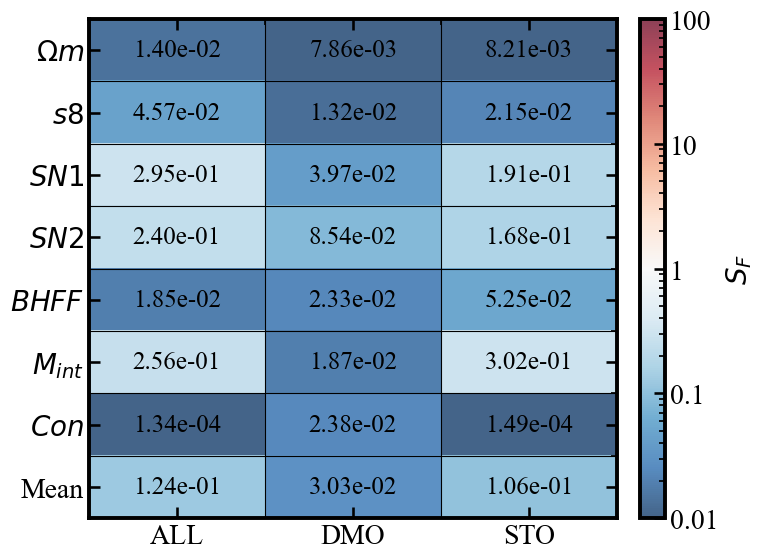

In [21]:
from matplotlib.colors import LogNorm

def plot_scalar_table_with_cell_colors(
    param_labels,
    ALL_vals,
    DMO_vals,
    STO_vals,
    Other_vals=None,
    col_labels=("ALL", "DMO", "STO"),
    title=r"Normalized covariance-structure change metric $S_F$",
    cmap="viridis",
    vmin=1e-2,           # lower bound in *actual S_F units*
    vmax=1e2,            # upper bound in *actual S_F units*
    text_fmt="{:.2e}",
    figsize=(8, 6),
    rotate_x=0,
    alpha=0.8,           # background transparency
    add_mean_row=True,   # NEW
    mean_row_label="Mean" # NEW
):
    """
    Table-like heatmap with one scalar per cell.

    - Cell color encodes magnitude of S_F using logarithmic scaling
    - Colorbar shows *actual S_F values* (not log10)
    - Optionally adds a final row with the mean of all rows above (per column)
    """

    # -------------------- assemble data matrix --------------------
    param_labels = list(param_labels)
    M = np.column_stack([
        np.asarray(ALL_vals, dtype=float),
        np.asarray(DMO_vals, dtype=float),
        np.asarray(STO_vals, dtype=float),
        # np.asarray(Other_vals, dtype=float),  # kept optional, but not used unless you add it back
    ])

    n_rows, n_cols = M.shape
    assert n_cols == len(col_labels), "col_labels must match number of columns"

    # -------------------- add final mean row --------------------
    if add_mean_row:
        mean_row = np.nanmean(M, axis=0, keepdims=True)  # shape (1, n_cols)
        M = np.vstack([M, mean_row])
        param_labels = param_labels + [mean_row_label]
        n_rows = M.shape[0]

    # -------------------- plotting --------------------
    fig, ax = plt.subplots(figsize=figsize)

    norm = LogNorm(vmin=vmin, vmax=vmax)

    im = ax.imshow(
        M,
        aspect="auto",
        cmap=cmap,
        norm=norm,
        alpha=alpha,
    )

    # -------------------- table-style axes --------------------
    ax.set_xticks(np.arange(n_cols))
    ax.set_xticklabels(col_labels, rotation=rotate_x, ha="center")
    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(param_labels)

    # draw grid lines
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="k", linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)

    # -------------------- annotate cells --------------------
    for i in range(n_rows):
        for j in range(n_cols):
            val = M[i, j]

            # handle NaNs gracefully
            if not np.isfinite(val):
                txt = "nan"
                color = "black"
            else:
                txt = text_fmt.format(val)
                color = "white" if norm(val) > 0.6 else "black"

            ax.text(
                j, i, txt,
                ha="center", va="center",
                fontsize=18,
                color=color,
            )

    # -------------------- colorbar (linear labels!) --------------------
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(r"$S_F$")

    # choose nice log ticks
    ticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:g}" for t in ticks])

    ax.set_title(title, pad=12)

    plt.tight_layout()
    return fig

fig = plot_scalar_table_with_cell_colors(
    param_labels=param_labels,
    ALL_vals=ALL_S_F,
    DMO_vals=DMO_S_F,
    STO_vals=STO_S_F,
    Other_vals=Other_S_F,
    title=r"",
    cmap="RdBu_r",
    vmin=1e-2,
    vmax=1e2,
    alpha=0.75,
)

# fig.savefig("/home/gjc7gx/CovNNet/Figures/SF_table_heat.png", dpi=220)


Saved: pred_true_grid.png

=== Summary metrics over test set ===
ALL : (n_sims=103)
  mean |log10(pred/true)| (density)  = 0.0809
  mean  log10(pred/true)  (density)  = -0.0001
  % radial bins outside 2σ (density) = 3.71 %
  mean |log10(pred/true)| (rotation) = 0.0521
  mean  log10(pred/true)  (rotation) = 0.0202
  % radial bins outside 2σ (rotation) = 7.18 %

DMO : (n_sims=103)
  mean |log10(pred/true)| (density)  = 0.0606
  mean  log10(pred/true)  (density)  = -0.0111
  % radial bins outside 2σ (density) = 1.42 %
  mean |log10(pred/true)| (rotation) = 0.0619
  mean  log10(pred/true)  (rotation) = 0.0312
  % radial bins outside 2σ (rotation) = 3.34 %

STO : (n_sims=103)
  mean |log10(pred/true)| (density)  = 0.1764
  mean  log10(pred/true)  (density)  = 0.0266
  % radial bins outside 2σ (density) = 2.74 %
  mean |log10(pred/true)| (rotation) = 0.0511
  mean  log10(pred/true)  (rotation) = 0.0178
  % radial bins outside 2σ (rotation) = 5.50 %

=== Overall metrics (pooled over ALL + DMO

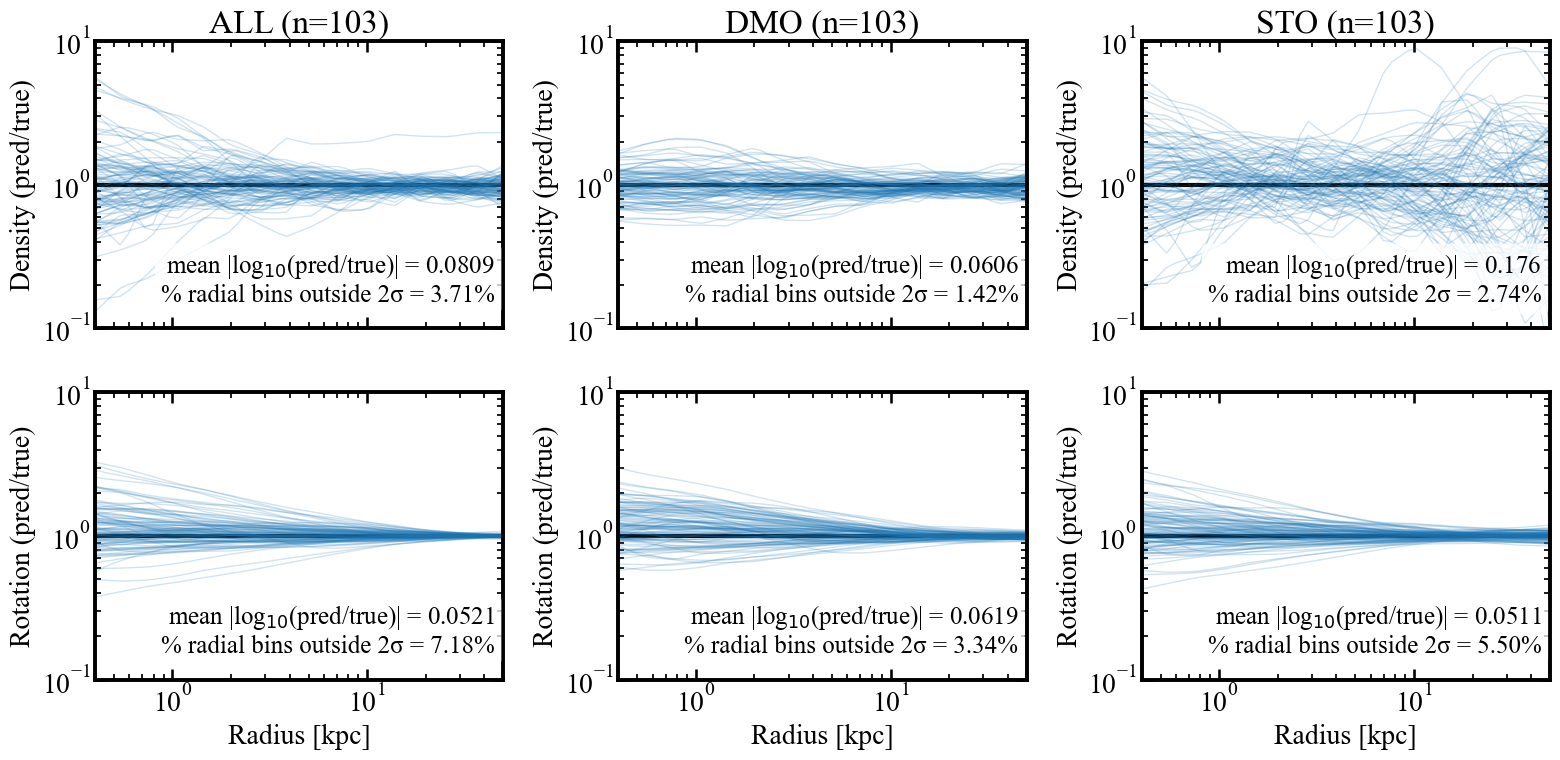

In [22]:
def _denorm(vec_np, key):
    assert vec_np.ndim == 1
    vec_np = vec_np.astype(np.float32)
    result = np.empty_like(vec_np)
    for group in key["groups"]:
        cols  = group["cols"]
        mode  = group["mode"]
        lo    = group["lo"]
        hi    = group["hi"]
        shift = group["shift"]
        work = vec_np[cols] * (hi - lo) + lo
        if mode == "linear":
            result[cols] = work
        elif mode == "log":
            result[cols] = np.exp(work) - shift
        else:
            raise ValueError(f"Unknown mode: {mode}")
    return result


@torch.no_grad()
def plot_all_test_samples_pred_true_grid(
    loaders_dict,
    models_dict,
    r_tags,
    device,
    key_y_coeff_by_split,
    basis_meta,
    Y1_len=50,
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title="Test set: Pred vs True (all samples)",
    savepath=None,
    ci_sigma=2.0,
    text_box_alpha=0.75,
):
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    Y2_len = Phi2.shape[0]

    fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex="col")
    col_names = ["ALL", "DMO", "STO"]

    for j, name in enumerate(col_names):
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        mean_net.eval()
        cov_net.eval()

        ax_den = axes[0, j]
        ax_rot = axes[1, j]
        ax_den.set_xlim(0.4, 50)
        ax_rot.set_xlim(0.4, 50)
        ax_den.hlines(1, 0.2, 100, color='k', linewidth=3)
        ax_rot.hlines(1, 0.2, 100, color='k', linewidth=3)

        # --- error accumulators ---
        sum_logerr_den = 0.0
        sum_logerr_rot = 0.0
        n_sims_for_err = 0

        # --- out-of-2sigma (BIN FRACTION) accumulators ---
        out_bins_den = 0
        out_bins_rot = 0
        total_bins_den = 0
        total_bins_rot = 0

        scales = _linear_scales_from_key(key_y).astype(np.float64)
        D = np.diag(scales)

        n_plotted = 0

        for batch in loader:
            if isinstance(batch, (tuple, list)):
                x_b, y_b = batch[0], batch[1]
            elif isinstance(batch, dict):
                x_b = batch.get("x", batch.get("X"))
                y_b = batch.get("y", batch.get("Y"))
            else:
                raise TypeError(f"Unknown batch type: {type(batch)}")

            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n_b = mean_net(x_b)  # [B, d]
            L_n_b  = cov_net(x_b)   # [B, d, d]
            Sigma_n_b = L_n_b @ L_n_b.transpose(1, 2)

            mu_n = mu_n_b.detach().cpu().numpy()
            y_n  = y_b.detach().cpu().numpy()
            Sigma_n = Sigma_n_b.detach().cpu().numpy()

            B = mu_n.shape[0]
            for i in range(B):
                if (max_curves is not None) and (n_plotted >= max_curves):
                    break

                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                # ---- bounds ----
                Sigma_c = D @ Sigma_n[i] @ D.T
                Sigma_c11 = Sigma_c[:k1, :k1]
                Sigma_c22 = Sigma_c[k1:, k1:]

                if LOG1:
                    Sigma_log_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std_log_y1 = np.sqrt(np.clip(np.diag(Sigma_log_y1), 0.0, None))
                    lower1 = np.exp(lin_mu1 - ci_sigma * std_log_y1)
                    upper1 = np.exp(lin_mu1 + ci_sigma * std_log_y1)
                else:
                    Sigma_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std1 = np.sqrt(np.clip(np.diag(Sigma_y1), 0.0, None))
                    lower1 = den_mu1 - ci_sigma * std1
                    upper1 = den_mu1 + ci_sigma * std1

                if LOG2:
                    Sigma_log_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std_log_y2 = np.sqrt(np.clip(np.diag(Sigma_log_y2), 0.0, None))
                    lower2 = np.exp(lin_mu2 - ci_sigma * std_log_y2)
                    upper2 = np.exp(lin_mu2 + ci_sigma * std_log_y2)
                else:
                    Sigma_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std2 = np.sqrt(np.clip(np.diag(Sigma_y2), 0.0, None))
                    lower2 = den_mu2 - ci_sigma * std2
                    upper2 = den_mu2 + ci_sigma * std2

                # ---- out-of-band BIN FRACTION (true outside pred band) ----
                mask_den = (den_tr1 < lower1) | (den_tr1 > upper1)
                mask_rot = (den_tr2 < lower2) | (den_tr2 > upper2)

                out_bins_den   += int(np.count_nonzero(mask_den))
                total_bins_den += int(mask_den.size)

                out_bins_rot   += int(np.count_nonzero(mask_rot))
                total_bins_rot += int(mask_rot.size)

                # ---- mean log error (scalar per sim), now consistent with pred/true ----
                logerr_den = np.mean(np.abs(np.log10((den_mu1 + eps) / (den_tr1 + eps))))
                logerr_rot = np.mean(np.abs(np.log10((den_mu2 + eps) / (den_tr2 + eps))))
                sum_logerr_den += float(logerr_den)
                sum_logerr_rot += float(logerr_rot)
                n_sims_for_err += 1

                # ---- plot ratios: pred/true ----
                ratio1 = (den_mu1 + eps) / (den_tr1 + eps)
                ratio2 = (den_mu2 + eps) / (den_tr2 + eps)

                ax_den.plot(r, ratio1, alpha=alpha, lw=lw, color="tab:blue")
                ax_rot.plot(r, ratio2, alpha=alpha, lw=lw, color="tab:blue")

                n_plotted += 1

            if (max_curves is not None) and (n_plotted >= max_curves):
                break

        # ---- formatting ----
        ax_den.set_title(f"{name} (n={n_plotted})")
        ax_den.set_xscale("log")
        ax_den.set_yscale("log")
        ax_den.set_ylim(*density_ylim)
        ax_den.set_ylabel("Density (pred/true)")

        ax_rot.set_xscale("log")
        ax_rot.set_yscale("log")
        ax_rot.set_ylim(*v_ylim)
        ax_rot.set_ylabel("Rotation (pred/true)")
        ax_rot.set_xlabel("Radius [kpc]")

        # ---- textbox ----
        mean_logerr_den = sum_logerr_den / max(n_sims_for_err, 1)
        mean_logerr_rot = sum_logerr_rot / max(n_sims_for_err, 1)

        pct_bins_out_den = 100.0 * (out_bins_den / max(total_bins_den, 1))
        pct_bins_out_rot = 100.0 * (out_bins_rot / max(total_bins_rot, 1))

        txt_den = (f"mean |log$_{{10}}$(pred/true)| = {mean_logerr_den:.3g}\n"
                   f"% radial bins outside {ci_sigma:.0f}σ = {pct_bins_out_den:.2f}%")
        txt_rot = (f"mean |log$_{{10}}$(pred/true)| = {mean_logerr_rot:.3g}\n"
                   f"% radial bins outside {ci_sigma:.0f}σ = {pct_bins_out_rot:.2f}%")

        bbox = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=text_box_alpha, edgecolor="none")
        ax_den.text(0.98, 0.07, txt_den, transform=ax_den.transAxes, ha="right", va="bottom", fontsize=18, bbox=bbox)
        ax_rot.text(0.98, 0.07, txt_rot, transform=ax_rot.transAxes, ha="right", va="bottom", fontsize=18, bbox=bbox)

    axes[0, 0].set_ylabel("Density (pred/true)")
    axes[1, 0].set_ylabel("Rotation (pred/true)")

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)
    return fig


def print_all_test_samples_pred_true_grid(
    loaders_dict,
    models_dict,
    r_tags,
    device,
    key_y_coeff_by_split,
    basis_meta,
    Y1_len=50,
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title="Test set: Pred vs True (all samples)",
    savepath=None,
    ci_sigma=2.0,
    text_box_alpha=0.75,
):
    assert basis_meta is not None and basis_meta.get("use_basis", False)

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    col_names = ["ALL", "DMO", "STO"]

    final_metrics = {}

    # >>> NEW: global pooled accumulators (ALL+DMO+STO)
    g_sum_abs_logerr_den = 0.0
    g_sum_abs_logerr_rot = 0.0
    g_sum_signed_logerr_den = 0.0
    g_sum_signed_logerr_rot = 0.0
    g_n_sims = 0

    g_out_bins_den = 0
    g_out_bins_rot = 0
    g_total_bins_den = 0
    g_total_bins_rot = 0

    for j, name in enumerate(col_names):
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        mean_net.eval()
        cov_net.eval()

        # --- per-split accumulators ---
        sum_abs_logerr_den = 0.0
        sum_abs_logerr_rot = 0.0
        sum_signed_logerr_den = 0.0
        sum_signed_logerr_rot = 0.0
        n_sims = 0

        out_bins_den = 0
        out_bins_rot = 0
        total_bins_den = 0
        total_bins_rot = 0

        scales = _linear_scales_from_key(key_y).astype(np.float64)
        D = np.diag(scales)

        for batch in loader:
            x_b, y_b = batch[:2] if isinstance(batch, (tuple, list)) else (batch["x"], batch["y"])
            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n = mean_net(x_b).detach().cpu().numpy()
            L_n  = cov_net(x_b)
            Sigma_n = (L_n @ L_n.transpose(1, 2)).detach().cpu().numpy()
            y_n = y_b.detach().cpu().numpy()

            for i in range(mu_n.shape[0]):
                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                # --- log errors ---
                log_ratio_den = np.log10((den_mu1 + eps) / (den_tr1 + eps))
                log_ratio_rot = np.log10((den_mu2 + eps) / (den_tr2 + eps))

                sum_abs_logerr_den += float(np.mean(np.abs(log_ratio_den)))
                sum_abs_logerr_rot += float(np.mean(np.abs(log_ratio_rot)))
                sum_signed_logerr_den += float(np.mean(log_ratio_den))
                sum_signed_logerr_rot += float(np.mean(log_ratio_rot))
                n_sims += 1

                # --- bounds ---
                Sigma_c = D @ Sigma_n[i] @ D.T
                Sigma_c11 = Sigma_c[:k1, :k1]
                Sigma_c22 = Sigma_c[k1:, k1:]

                if LOG1:
                    std_log_y1 = np.sqrt(np.clip(np.diag(Phi1 @ Sigma_c11 @ Phi1.T), 0, None))
                    lower1 = np.exp(lin_mu1 - ci_sigma * std_log_y1)
                    upper1 = np.exp(lin_mu1 + ci_sigma * std_log_y1)
                else:
                    std1 = np.sqrt(np.clip(np.diag(Phi1 @ Sigma_c11 @ Phi1.T), 0, None))
                    lower1 = den_mu1 - ci_sigma * std1
                    upper1 = den_mu1 + ci_sigma * std1

                if LOG2:
                    std_log_y2 = np.sqrt(np.clip(np.diag(Phi2 @ Sigma_c22 @ Phi2.T), 0, None))
                    lower2 = np.exp(lin_mu2 - ci_sigma * std_log_y2)
                    upper2 = np.exp(lin_mu2 + ci_sigma * std_log_y2)
                else:
                    std2 = np.sqrt(np.clip(np.diag(Phi2 @ Sigma_c22 @ Phi2.T), 0, None))
                    lower2 = den_mu2 - ci_sigma * std2
                    upper2 = den_mu2 + ci_sigma * std2

                out_bins_den += int(np.count_nonzero((den_tr1 < lower1) | (den_tr1 > upper1)))
                total_bins_den += int(len(den_tr1))
                out_bins_rot += int(np.count_nonzero((den_tr2 < lower2) | (den_tr2 > upper2)))
                total_bins_rot += int(len(den_tr2))

        # store per-split metrics
        final_metrics[name] = {
            "mean_abs_logerr_den": sum_abs_logerr_den / max(n_sims, 1),
            "mean_abs_logerr_rot": sum_abs_logerr_rot / max(n_sims, 1),
            "mean_signed_logerr_den": sum_signed_logerr_den / max(n_sims, 1),
            "mean_signed_logerr_rot": sum_signed_logerr_rot / max(n_sims, 1),
            "pct_bins_out_den": 100 * out_bins_den / max(total_bins_den, 1),
            "pct_bins_out_rot": 100 * out_bins_rot / max(total_bins_rot, 1),
            "n_sims": n_sims,
            "total_bins_den": total_bins_den,
            "total_bins_rot": total_bins_rot,
        }

        # >>> NEW: add into global pooled accumulators
        g_sum_abs_logerr_den += sum_abs_logerr_den
        g_sum_abs_logerr_rot += sum_abs_logerr_rot
        g_sum_signed_logerr_den += sum_signed_logerr_den
        g_sum_signed_logerr_rot += sum_signed_logerr_rot
        g_n_sims += n_sims

        g_out_bins_den += out_bins_den
        g_out_bins_rot += out_bins_rot
        g_total_bins_den += total_bins_den
        g_total_bins_rot += total_bins_rot

    # print per-split metrics
    print("\n=== Summary metrics over test set ===")
    for name, m in final_metrics.items():
        print(f"{name} : (n_sims={m['n_sims']})")
        print(f"  mean |log10(pred/true)| (density)  = {m['mean_abs_logerr_den']:.4f}")
        print(f"  mean  log10(pred/true)  (density)  = {m['mean_signed_logerr_den']:.4f}")
        print(f"  % radial bins outside {ci_sigma:.0f}σ (density) = {m['pct_bins_out_den']:.2f} %")
        print(f"  mean |log10(pred/true)| (rotation) = {m['mean_abs_logerr_rot']:.4f}")
        print(f"  mean  log10(pred/true)  (rotation) = {m['mean_signed_logerr_rot']:.4f}")
        print(f"  % radial bins outside {ci_sigma:.0f}σ (rotation) = {m['pct_bins_out_rot']:.2f} %\n")

    # >>> NEW: overall pooled metrics
    overall = {
        "mean_abs_logerr_den": g_sum_abs_logerr_den / max(g_n_sims, 1),
        "mean_abs_logerr_rot": g_sum_abs_logerr_rot / max(g_n_sims, 1),
        "mean_signed_logerr_den": g_sum_signed_logerr_den / max(g_n_sims, 1),
        "mean_signed_logerr_rot": g_sum_signed_logerr_rot / max(g_n_sims, 1),
        "pct_bins_out_den": 100 * g_out_bins_den / max(g_total_bins_den, 1),
        "pct_bins_out_rot": 100 * g_out_bins_rot / max(g_total_bins_rot, 1),
        "n_sims": g_n_sims,
        "total_bins_den": g_total_bins_den,
        "total_bins_rot": g_total_bins_rot,
    }

    print("=== Overall metrics (pooled over ALL + DMO + STO) ===")
    print(f"OVERALL : (n_sims={overall['n_sims']})")
    print(f"  mean |log10(pred/true)| (density)  = {overall['mean_abs_logerr_den']:.4f}")
    print(f"  mean  log10(pred/true)  (density)  = {overall['mean_signed_logerr_den']:.4f}")
    print(f"  % radial bins outside {ci_sigma:.0f}σ (density) = {overall['pct_bins_out_den']:.2f} %")
    print(f"  mean |log10(pred/true)| (rotation) = {overall['mean_abs_logerr_rot']:.4f}")
    print(f"  mean  log10(pred/true)  (rotation) = {overall['mean_signed_logerr_rot']:.4f}")
    print(f"  % radial bins outside {ci_sigma:.0f}σ (rotation) = {overall['pct_bins_out_rot']:.2f} %\n")

    return final_metrics, overall



loaders = {"ALL": ALL_test_loader, "DMO": DMO_test_loader, "STO": STO_test_loader}
models  = {"ALL": (ALL_mean_net, ALL_cov_net), "DMO": (DMO_mean_net, DMO_cov_net), "STO": (STO_mean_net, STO_cov_net)}

key_y_coeff = {
    "ALL": ALL_Yn_key,
    "DMO": DMO_Yn_key,
    "STO": STO_Yn_key,
}

fig = plot_all_test_samples_pred_true_grid(
    loaders_dict=loaders,
    models_dict=models,
    r_tags=r_tags,
    device=device,
    key_y_coeff_by_split=key_y_coeff,
    basis_meta=basis_meta,
    max_curves=200,
    alpha=0.2,
    savepath="pred_true_grid.png",
)

_,_ = print_all_test_samples_pred_true_grid(
    loaders_dict=loaders,
    models_dict=models,
    r_tags=r_tags,
    device=device,
    key_y_coeff_by_split=key_y_coeff,
    basis_meta=basis_meta,
    max_curves=200,
    alpha=0.2,
    savepath="pred_true_grid.png",
)

Saved: /home/gjc7gx/CovNNet/Figures/pred_true_grid_with_loaded.png


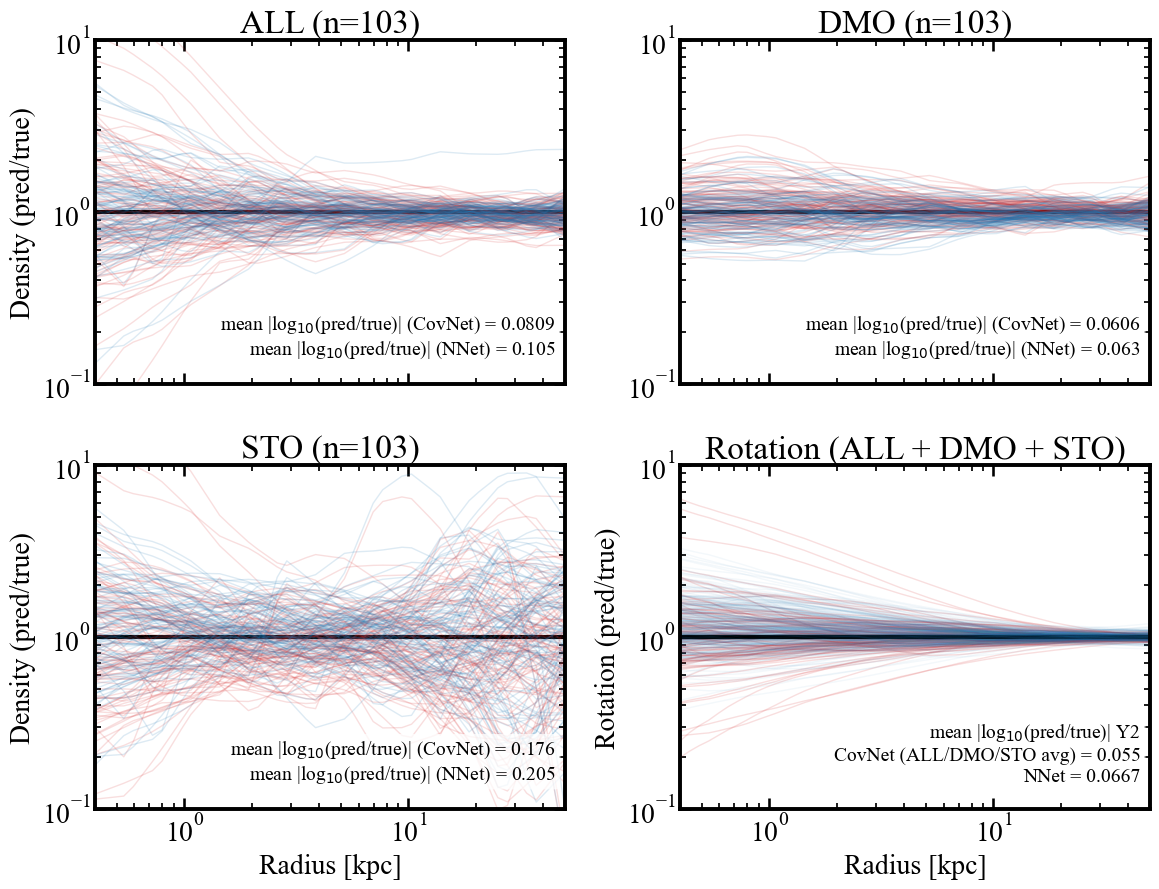

In [23]:
def load_test_profiles_txt(in_path: str):
    """
    Load the saved test profiles from a .txt file created by save_test_profiles_txt.

    Returns:
        sample_indices : [N] int array of sample indices
        true_profiles  : [N, nbins] array of true profiles
        pred_profiles  : [N, nbins] array of predicted profiles
    """
    data = np.loadtxt(in_path, comments="#")
    if data.ndim == 1:
        data = data[None, :]  # handle the edge case of N=1

    n_cols = data.shape[1]
    nbins = (n_cols - 1) // 2  # columns: 1 index + nbins true + nbins pred

    sample_indices = data[:, 0].astype(int)
    true_profiles  = data[:, 1:1 + nbins]
    pred_profiles  = data[:, 1 + nbins:1 + 2 * nbins]

    return sample_indices, true_profiles, pred_profiles

@torch.no_grad()
def plot_all_test_samples_pred_true_grid(
    loaders_dict,
    models_dict,
    r_tags,
    device,
    key_y_coeff_by_split,
    basis_meta,
    Y1_len=50,
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title="Test set: Pred vs True (all samples)",
    savepath=None,
    ci_sigma=2.0,
    text_box_alpha=0.75,
    loaded_paths_dict=None,  # dict mapping split -> {"Y1": path, "Y2": path}
):
    """
    2x2 grid of ratio plots (pred/true):

        [0,0] : Y1 (density) for ALL
        [0,1] : Y1 (density) for DMO
        [1,0] : Y1 (density) for STO
        [1,1] : Y2 (rotation) for ALL + DMO + STO on a single plot

    Y2 behavior:
        - Online ALL/DMO/STO are all drawn from the same sample:
          => all online Y2 curves are plotted in BLUE.
        - Loaded Y2 files for ALL/DMO/STO are assumed identical:
          => only one loaded Y2 set is plotted (for "ALL", in RED).
        - Text box on the Y2 panel shows:
          * average online mean |log10(pred/true)| across ALL/DMO/STO
          * average loaded mean |log10(pred/true)| across ALL/DMO/STO
    """
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    Y2_len = Phi2.shape[0]

    # 2x2 layout:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex="col")
    # fig.suptitle(title)

    ax_y1_all = axes[0, 0]
    ax_y1_dmo = axes[0, 1]
    ax_y1_sto = axes[1, 0]
    ax_y2_all = axes[1, 1]   # combined Y2 axis

    col_names = ["ALL", "DMO", "STO"]

    # Store Y2 metrics to summarize later on the combined axis
    y2_online_err = {}
    y2_loaded_err = {}

    # Flag so we only plot loaded Y2 curves once (for ALL)
    loaded_y2_plotted = False

    for name in col_names:
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        mean_net.eval()
        cov_net.eval()

        # --- choose the Y1 axis based on split name ---
        if name == "ALL":
            ax_den = ax_y1_all
        elif name == "DMO":
            ax_den = ax_y1_dmo
        elif name == "STO":
            ax_den = ax_y1_sto
        else:
            raise ValueError(f"Unexpected split name: {name}")

        # Y2 curves all go on the combined bottom-right axis
        ax_rot = ax_y2_all

        # Set limits & baseline line once per axis (idempotent)
        ax_den.set_xlim(0.4, 50)
        ax_den.hlines(1, 0.2, 100, color='k', linewidth=3)

        ax_rot.set_xlim(0.4, 50)
        ax_rot.hlines(1, 0.2, 100, color='k', linewidth=3)

        # --- error accumulators (online / from loaders) ---
        sum_logerr_den = 0.0
        sum_logerr_rot = 0.0
        n_sims_for_err = 0

        # --- out-of-2sigma (BIN FRACTION) accumulators (kept for fallback) ---
        out_bins_den = 0
        out_bins_rot = 0
        total_bins_den = 0
        total_bins_rot = 0

        scales = _linear_scales_from_key(key_y).astype(np.float64)
        D = np.diag(scales)

        n_plotted = 0

        # ============================================================
        # 2) RATIO CURVES FROM LOADED pred/true FILES (RED)
        #    - Density: per split on its own Y1 panel.
        #    - Rotation: ONLY once, for "ALL", since all three sets are the same.
        # ============================================================
        mean_logerr_den_loaded = np.nan
        mean_logerr_rot_loaded = np.nan

        if (loaded_paths_dict is not None) and (name in loaded_paths_dict):
            split_paths = loaded_paths_dict[name]

            # 2.1 Density (Y1) loaded curves
            path_den = split_paths.get("Y1", None)
            if path_den is not None and os.path.exists(path_den):
                _, true_den_loaded, pred_den_loaded = load_test_profiles_txt(path_den)

                # ratio curves in RED on the Y1 axis
                for k in range(true_den_loaded.shape[0]):
                    true_k = true_den_loaded[k]
                    pred_k = pred_den_loaded[k]
                    ratio_loaded = (pred_k + eps) / (true_k + eps)
                    ax_den.plot(r, ratio_loaded, alpha=alpha, lw=lw, color="tab:red")

                # global mean |log10(pred/true)| over all loaded bins
                mask = (true_den_loaded > 0.0) & (pred_den_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_den_loaded[mask] + eps) / (true_den_loaded[mask] + eps)
                    mean_logerr_den_loaded = float(np.mean(np.abs(np.log10(ratio))))

            # 2.2 Rotation (Y2) loaded curves
            path_rot = split_paths.get("Y2", None)
            # Only plot once, for the first split where we see it (e.g. ALL)
            if (not loaded_y2_plotted) and (path_rot is not None) and os.path.exists(path_rot):
                _, true_rot_loaded, pred_rot_loaded = load_test_profiles_txt(path_rot)

                # ratio curves in RED on the combined Y2 axis
                for k in range(true_rot_loaded.shape[0]):
                    true_k = true_rot_loaded[k]
                    pred_k = pred_rot_loaded[k]
                    ratio_loaded = (pred_k + eps) / (true_k + eps)
                    ax_rot.plot(r, ratio_loaded, alpha=alpha, lw=lw, color="tab:red")

                # global mean |log10(pred/true)| over all loaded bins
                mask = (true_rot_loaded > 0.0) & (pred_rot_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_rot_loaded[mask] + eps) / (true_rot_loaded[mask] + eps)
                    mean_logerr_rot_loaded = float(np.mean(np.abs(np.log10(ratio))))

                loaded_y2_plotted = True  # do not plot loaded Y2 again

        # ============================================================
        # 1) ONLINE RATIO CURVES FROM CURRENT MODELS
        #    - Y1: BLUE curves on per-split axes.
        #    - Y2: ALL/DMO/STO are from same sample -> all BLUE on the
        #          combined axis.
        # ============================================================
        for batch in loader:
            if isinstance(batch, (tuple, list)):
                x_b, y_b = batch[0], batch[1]
            elif isinstance(batch, dict):
                x_b = batch.get("x", batch.get("X"))
                y_b = batch.get("y", batch.get("Y"))
            else:
                raise TypeError(f"Unknown batch type: {type(batch)}")

            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n_b = mean_net(x_b)  # [B, d]
            L_n_b  = cov_net(x_b)   # [B, d, d]
            Sigma_n_b = L_n_b @ L_n_b.transpose(1, 2)

            mu_n = mu_n_b.detach().cpu().numpy()
            y_n  = y_b.detach().cpu().numpy()
            Sigma_n = Sigma_n_b.detach().cpu().numpy()

            B = mu_n.shape[0]
            for i in range(B):
                if (max_curves is not None) and (n_plotted >= max_curves):
                    break

                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                # ---- bounds ----
                Sigma_c = D @ Sigma_n[i] @ D.T
                Sigma_c11 = Sigma_c[:k1, :k1]
                Sigma_c22 = Sigma_c[k1:, k1:]

                if LOG1:
                    Sigma_log_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std_log_y1 = np.sqrt(np.clip(np.diag(Sigma_log_y1), 0.0, None))
                    lower1 = np.exp(lin_mu1 - ci_sigma * std_log_y1)
                    upper1 = np.exp(lin_mu1 + ci_sigma * std_log_y1)
                else:
                    Sigma_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std1 = np.sqrt(np.clip(np.diag(Sigma_y1), 0.0, None))
                    lower1 = den_mu1 - ci_sigma * std1
                    upper1 = den_mu1 + ci_sigma * std1

                if LOG2:
                    Sigma_log_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std_log_y2 = np.sqrt(np.clip(np.diag(Sigma_log_y2), 0.0, None))
                    lower2 = np.exp(lin_mu2 - ci_sigma * std_log_y2)
                    upper2 = np.exp(lin_mu2 + ci_sigma * std_log_y2)
                else:
                    Sigma_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std2 = np.sqrt(np.clip(np.diag(Sigma_y2), 0.0, None))
                    lower2 = den_mu2 - ci_sigma * std2
                    upper2 = den_mu2 + ci_sigma * std2

                # ---- out-of-band BIN FRACTION (true outside pred band) ----
                mask_den = (den_tr1 < lower1) | (den_tr1 > upper1)
                mask_rot = (den_tr2 < lower2) | (den_tr2 > upper2)

                out_bins_den   += int(np.count_nonzero(mask_den))
                total_bins_den += int(mask_den.size)

                out_bins_rot   += int(np.count_nonzero(mask_rot))
                total_bins_rot += int(mask_rot.size)

                # ---- mean log error (scalar per sim), consistent with pred/true ----
                logerr_den = np.mean(np.abs(np.log10((den_mu1 + eps) / (den_tr1 + eps))))
                logerr_rot = np.mean(np.abs(np.log10((den_mu2 + eps) / (den_tr2 + eps))))
                sum_logerr_den += float(logerr_den)
                sum_logerr_rot += float(logerr_rot)
                n_sims_for_err += 1

                # ---- ratio curves from online models ----
                ratio1 = (den_mu1 + eps) / (den_tr1 + eps)
                ratio2 = (den_mu2 + eps) / (den_tr2 + eps)

                # Y1: blue on the per-split axis
                ax_den.plot(r, ratio1, alpha=alpha, lw=lw, color="tab:blue")

                # Y2: all splits plotted in blue on the combined axis
                ax_rot.plot(r, ratio2, alpha=alpha/3, lw=lw, color="tab:blue")

                n_plotted += 1

            if (max_curves is not None) and (n_plotted >= max_curves):
                break

        # ============================================================
        # 3) AXIS FORMATTING & TEXT BOX FOR Y1
        # ============================================================
        ax_den.set_title(f"{name} (n={n_plotted})")
        ax_den.set_xscale("log")
        ax_den.set_yscale("log")
        ax_den.set_ylim(*density_ylim)

        mean_logerr_den = sum_logerr_den / max(n_sims_for_err, 1)
        mean_logerr_rot = sum_logerr_rot / max(n_sims_for_err, 1)

        # old bin-outside-% kept for fallback if no loaded data
        pct_bins_out_den = 100.0 * (out_bins_den / max(total_bins_den, 1))

        # ---- Y1 textbox ----
        if not np.isnan(mean_logerr_den_loaded):
            txt_den = (
                f"mean |log$_{{10}}$(pred/true)| (CovNet) = {mean_logerr_den:.3g}\n"
                f"mean |log$_{{10}}$(pred/true)| (NNet) = {mean_logerr_den_loaded:.3g}"
            )
        else:
            txt_den = (
                f"mean |log$_{{10}}$(pred/true)| = {mean_logerr_den:.3g}\n"
                f"% radial bins outside {ci_sigma:.0f}σ = {pct_bins_out_den:.2f}%"
            )

        bbox = dict(boxstyle="round,pad=0.25", facecolor="white",
                    alpha=text_box_alpha, edgecolor="none")
        ax_den.text(0.98, 0.07, txt_den, transform=ax_den.transAxes,
                    ha="right", va="bottom", fontsize=14, bbox=bbox)

        # store Y2 metrics for combined panel
        y2_online_err[name] = mean_logerr_rot
        y2_loaded_err[name] = mean_logerr_rot_loaded

    # ============================================================
    # 4) GLOBAL FORMATTING & TEXT BOXES FOR ALL PANELS
    # ============================================================
    # Y1 y-labels on left column
    ax_y1_all.set_ylabel("Density (pred/true)")
    ax_y1_sto.set_ylabel("Density (pred/true)")
    ax_y1_sto.set_xlabel("Radius [kpc]")

    # Y2 combined axis formatting
    ax_y2_all.set_xscale("log")
    ax_y2_all.set_yscale("log")
    ax_y2_all.set_ylim(*v_ylim)
    ax_y2_all.set_ylabel("Rotation (pred/true)")
    ax_y2_all.set_xlabel("Radius [kpc]")
    ax_y2_all.set_title("Rotation (ALL + DMO + STO)")

    # Average mean log errors across ALL/DMO/STO
    online_vals = [v for v in y2_online_err.values() if not np.isnan(v)]
    loaded_vals = [v for v in y2_loaded_err.values() if not np.isnan(v)]

    online_avg = np.mean(online_vals) if len(online_vals) > 0 else np.nan
    loaded_avg = np.mean(loaded_vals) if len(loaded_vals) > 0 else np.nan

    # Build combined Y2 textbox summarizing averages
    if np.isnan(online_avg):
        online_str = "N/A"
    else:
        online_str = f"{online_avg:.3g}"

    if np.isnan(loaded_avg):
        loaded_str = "N/A"
    else:
        loaded_str = f"{loaded_avg:.3g}"

    txt_rot = (
        "mean |log$_{10}$(pred/true)| Y2\n"
        f"CovNet (ALL/DMO/STO avg) = {online_str}\n"
        f"NNet = {loaded_str}"
    )

    bbox = dict(boxstyle="round,pad=0.25", facecolor="white",
                alpha=text_box_alpha, edgecolor="none")
    ax_y2_all.text(0.98, 0.07, txt_rot, transform=ax_y2_all.transAxes,
                   ha="right", va="bottom", fontsize=14, bbox=bbox)

    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)
    return fig




loaded_paths_dict = {
    "ALL": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_ALL_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_ALL_PredTrue.txt",
    },
    "DMO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_DMO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_DMO_PredTrue.txt",
    },
    "STO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_STO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_STO_PredTrue.txt",
    },
}

fig = plot_all_test_samples_pred_true_grid(
    loaders_dict=loaders,
    models_dict=models,
    r_tags=r_tags,
    device=device,
    key_y_coeff_by_split=key_y_coeff,
    basis_meta=basis_meta,
    Y1_len=50,
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title=False,
    savepath="/home/gjc7gx/CovNNet/Figures/pred_true_grid_with_loaded.png",
    ci_sigma=2.0,
    text_box_alpha=0.75,
    loaded_paths_dict=loaded_paths_dict,
)


Saved: /home/gjc7gx/CovNNet/Figures/pred_true_grid_2x3_with_loaded.png


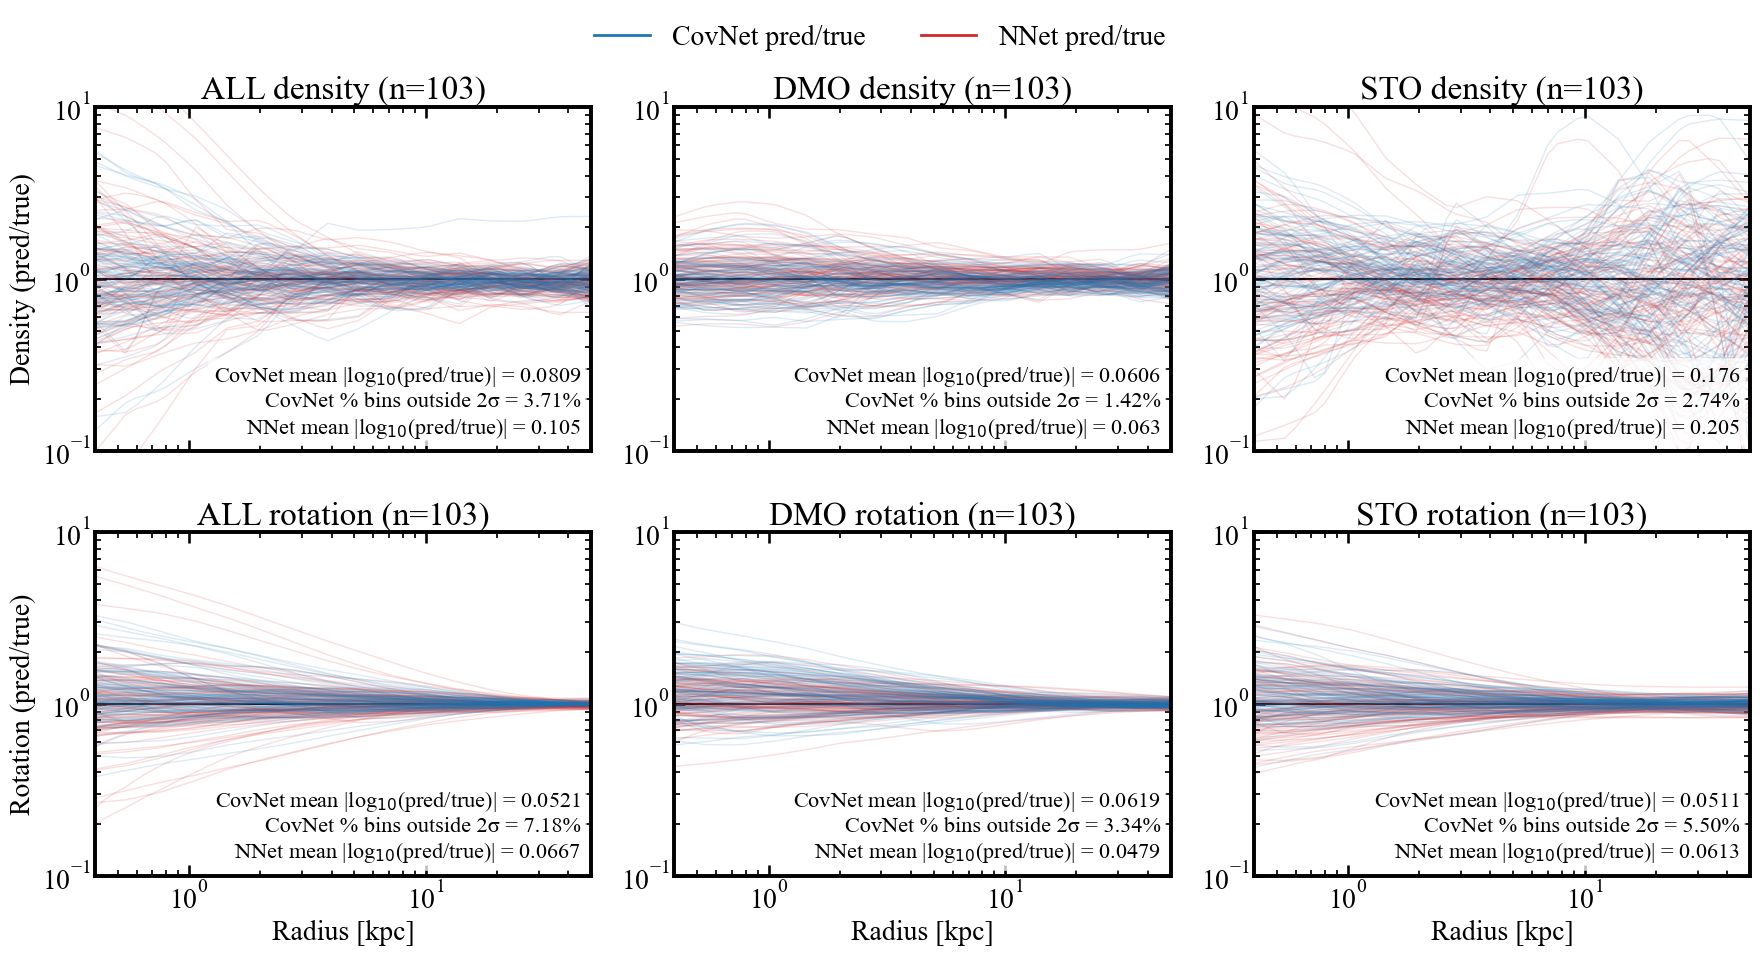

In [24]:
from matplotlib.lines import Line2D

@torch.no_grad()
def plot_all_test_samples_pred_true_grid(
    loaders_dict,
    models_dict,
    r_tags,
    device,
    key_y_coeff_by_split,
    basis_meta,
    Y1_len=50,
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title="Test set: Pred vs True (all samples)",
    savepath=None,
    ci_sigma=2.0,
    text_box_alpha=0.75,
    loaded_paths_dict=None,  # dict mapping split -> {"Y1": path, "Y2": path}
):
    """
    2x3 grid of ratio plots (pred/true):

        Row 0 (Y1 / density):  [ALL, DMO, STO]
        Row 1 (Y2 / rotation): [ALL, DMO, STO]

    For each subplot:
      - Blue curves = CovNet pred/true
      - Red curves  = NNet  pred/true  (loaded from *_PredTrue.txt)

      Textbox reports:
        * CovNet mean |log10(pred/true)|
        * CovNet % of radial bins outside the predicted 2σ band
        * NNet mean |log10(pred/true)| (if loaded file is available)
    """
    assert basis_meta is not None and basis_meta.get("use_basis", False), \
        "basis_meta['use_basis'] must be True."

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    Y2_len = Phi2.shape[0]

    # 2x3 layout:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex="col")
    if title:
        fig.suptitle(title)

    col_names = ["ALL", "DMO", "STO"]
    split_to_col = {"ALL": 0, "DMO": 1, "STO": 2}

    for name in col_names:
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        mean_net.eval()
        cov_net.eval()

        col = split_to_col[name]
        ax_den = axes[0, col]  # density axis for this split
        ax_rot = axes[1, col]  # rotation axis for this split

        # Set up axes: baseline line at ratio=1
        for ax_ in (ax_den, ax_rot):
            ax_.set_xlim(r[0], r[-1])
            ax_.axhline(1.0, color="k", linewidth=1.5)

        # --- error accumulators (online CovNet) ---
        sum_logerr_den = 0.0
        sum_logerr_rot = 0.0
        n_sims_for_err = 0

        # --- out-of-2sigma bin counters (online CovNet) ---
        out_bins_den = 0
        out_bins_rot = 0
        total_bins_den = 0
        total_bins_rot = 0

        # --- NNet (loaded) metrics ---
        mean_logerr_den_loaded = np.nan
        mean_logerr_rot_loaded = np.nan

        # Denorm scaling for coeff-space covariance
        scales = _linear_scales_from_key(key_y).astype(np.float64)
        D = np.diag(scales)

# ============================================================
        # 1) RATIO CURVES FROM LOADED pred/true FILES (RED, NNet)
        #    Separate Y1 and Y2 per split
        # ============================================================
        if (loaded_paths_dict is not None) and (name in loaded_paths_dict):
            split_paths = loaded_paths_dict[name]

            # 1.1 Density (Y1) loaded curves
            path_den = split_paths.get("Y1", None)
            if path_den is not None and os.path.exists(path_den):
                _, true_den_loaded, pred_den_loaded = load_test_profiles_txt(path_den)

                # ratio curves in RED on the Y1 axis
                for k in range(true_den_loaded.shape[0]):
                    true_k = true_den_loaded[k]
                    pred_k = pred_den_loaded[k]
                    ratio_loaded = (pred_k + eps) / (true_k + eps)
                    ax_den.plot(r, ratio_loaded, alpha=alpha, lw=lw, color="tab:red")

                # global mean |log10(pred/true)| over all loaded Y1 bins
                mask = (true_den_loaded > 0.0) & (pred_den_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_den_loaded[mask] + eps) / (true_den_loaded[mask] + eps)
                    mean_logerr_den_loaded = float(np.mean(np.abs(np.log10(ratio))))

            # 1.2 Rotation (Y2) loaded curves
            path_rot = split_paths.get("Y2", None)
            if path_rot is not None and os.path.exists(path_rot):
                _, true_rot_loaded, pred_rot_loaded = load_test_profiles_txt(path_rot)

                # ratio curves in RED on the Y2 axis
                for k in range(true_rot_loaded.shape[0]):
                    true_k = true_rot_loaded[k]
                    pred_k = pred_rot_loaded[k]
                    ratio_loaded = (pred_k + eps) / (true_k + eps)
                    ax_rot.plot(r, ratio_loaded, alpha=alpha, lw=lw, color="tab:red")

                # global mean |log10(pred/true)| over all loaded Y2 bins
                mask = (true_rot_loaded > 0.0) & (pred_rot_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_rot_loaded[mask] + eps) / (true_rot_loaded[mask] + eps)
                    mean_logerr_rot_loaded = float(np.mean(np.abs(np.log10(ratio))))


        # ============================================================
        # 2) ONLINE RATIO CURVES FROM CURRENT CovNet MODELS (BLUE)
        #    Y1 and Y2 both per split
        # ============================================================
        n_plotted = 0

        for batch in loader:
            if isinstance(batch, (tuple, list)):
                x_b, y_b = batch[0], batch[1]
            elif isinstance(batch, dict):
                x_b = batch.get("x", batch.get("X"))
                y_b = batch.get("y", batch.get("Y"))
            else:
                raise TypeError(f"Unknown batch type: {type(batch)}")

            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n_b = mean_net(x_b)  # [B, d]
            L_n_b  = cov_net(x_b)   # [B, d, d]
            Sigma_n_b = L_n_b @ L_n_b.transpose(1, 2)

            mu_n = mu_n_b.detach().cpu().numpy()
            y_n  = y_b.detach().cpu().numpy()
            Sigma_n = Sigma_n_b.detach().cpu().numpy()

            B = mu_n.shape[0]
            for i in range(B):
                if (max_curves is not None) and (n_plotted >= max_curves):
                    break

                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                # Split into Y1/Y2 coefficients
                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                # --- reconstruct Y1 ---
                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                # --- reconstruct Y2 ---
                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                # ---- covariance in coeff space ----
                Sigma_c = D @ Sigma_n[i] @ D.T
                Sigma_c11 = Sigma_c[:k1, :k1]
                Sigma_c22 = Sigma_c[k1:, k1:]

                # --- Y1 bounds ---
                if LOG1:
                    Sigma_log_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std_log_y1 = np.sqrt(np.clip(np.diag(Sigma_log_y1), 0.0, None))
                    lower1 = np.exp(lin_mu1 - ci_sigma * std_log_y1)
                    upper1 = np.exp(lin_mu1 + ci_sigma * std_log_y1)
                else:
                    Sigma_y1 = Phi1 @ Sigma_c11 @ Phi1.T
                    std1 = np.sqrt(np.clip(np.diag(Sigma_y1), 0.0, None))
                    lower1 = den_mu1 - ci_sigma * std1
                    upper1 = den_mu1 + ci_sigma * std1

                # --- Y2 bounds ---
                if LOG2:
                    Sigma_log_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std_log_y2 = np.sqrt(np.clip(np.diag(Sigma_log_y2), 0.0, None))
                    lower2 = np.exp(lin_mu2 - ci_sigma * std_log_y2)
                    upper2 = np.exp(lin_mu2 + ci_sigma * std_log_y2)
                else:
                    Sigma_y2 = Phi2 @ Sigma_c22 @ Phi2.T
                    std2 = np.sqrt(np.clip(np.diag(Sigma_y2), 0.0, None))
                    lower2 = den_mu2 - ci_sigma * std2
                    upper2 = den_mu2 + ci_sigma * std2

                # ---- out-of-band BIN FRACTION (true outside pred band) ----
                mask_den = (den_tr1 < lower1) | (den_tr1 > upper1)
                mask_rot = (den_tr2 < lower2) | (den_tr2 > upper2)

                out_bins_den   += int(np.count_nonzero(mask_den))
                total_bins_den += int(mask_den.size)

                out_bins_rot   += int(np.count_nonzero(mask_rot))
                total_bins_rot += int(mask_rot.size)

                # ---- mean log error per sim ----
                logerr_den = np.mean(
                    np.abs(np.log10((den_mu1 + eps) / (den_tr1 + eps)))
                )
                logerr_rot = np.mean(
                    np.abs(np.log10((den_mu2 + eps) / (den_tr2 + eps)))
                )

                sum_logerr_den += float(logerr_den)
                sum_logerr_rot += float(logerr_rot)
                n_sims_for_err += 1

                # ---- ratio curves from CovNet (BLUE) ----
                ratio1 = (den_mu1 + eps) / (den_tr1 + eps)
                ratio2 = (den_mu2 + eps) / (den_tr2 + eps)

                ax_den.plot(r, ratio1, alpha=alpha,   lw=lw, color="tab:blue")
                ax_rot.plot(r, ratio2, alpha=alpha, lw=lw, color="tab:blue")

                n_plotted += 1

            if (max_curves is not None) and (n_plotted >= max_curves):
                break
            

        # ============================================================
        # 3) AXIS FORMATTING & TEXT BOXES FOR THIS SPLIT
        # ============================================================
        # CovNet mean log errors
        mean_logerr_den = sum_logerr_den / max(n_sims_for_err, 1)
        mean_logerr_rot = sum_logerr_rot / max(n_sims_for_err, 1)

        # CovNet % bins outside 2σ
        pct_bins_out_den = 100.0 * (out_bins_den / max(total_bins_den, 1))
        pct_bins_out_rot = 100.0 * (out_bins_rot / max(total_bins_rot, 1))

        # --- density axis ---
        ax_den.set_title(f"{name} density (n={n_plotted})")
        ax_den.set_xscale("log")
        ax_den.set_yscale("log")
        ax_den.set_ylim(*density_ylim)

        txt_den = (
            f"CovNet mean |log$_{{10}}$(pred/true)| = {mean_logerr_den:.3g}\n"
            f"CovNet % bins outside {ci_sigma:.0f}σ = {pct_bins_out_den:.2f}%"
        )
        if not np.isnan(mean_logerr_den_loaded):
            txt_den += f"\nNNet mean |log$_{{10}}$(pred/true)| = {mean_logerr_den_loaded:.3g}"

        bbox = dict(boxstyle="round,pad=0.25", facecolor="white",
                    alpha=text_box_alpha, edgecolor="none")
        ax_den.text(0.98, 0.03, txt_den, transform=ax_den.transAxes,
                    ha="right", va="bottom", fontsize=16, bbox=bbox)

        # --- rotation axis ---
        ax_rot.set_title(f"{name} rotation (n={n_plotted})")
        ax_rot.set_xscale("log")
        ax_rot.set_yscale("log")
        ax_rot.set_ylim(*v_ylim)

        txt_rot = (
            f"CovNet mean |log$_{{10}}$(pred/true)| = {mean_logerr_rot:.3g}\n"
            f"CovNet % bins outside {ci_sigma:.0f}σ = {pct_bins_out_rot:.2f}%"
        )
        if not np.isnan(mean_logerr_rot_loaded):
            txt_rot += f"\nNNet mean |log$_{{10}}$(pred/true)| = {mean_logerr_rot_loaded:.3g}"

        ax_rot.text(0.98, 0.03, txt_rot, transform=ax_rot.transAxes,
                    ha="right", va="bottom", fontsize=16, bbox=bbox)

    # ============================================================
    # 4) GLOBAL LABELS & LEGEND
    # ============================================================
    # Y-labels on left column
    axes[0, 0].set_ylabel("Density (pred/true)")
    axes[1, 0].set_ylabel("Rotation (pred/true)")

    # X-labels on bottom row
    for c in range(3):
        axes[1, c].set_xlabel("Radius [kpc]")

    # Global legend indicating color coding
    handles = [
        Line2D([0], [0], color="tab:blue", lw=2, label="CovNet pred/true"),
        Line2D([0], [0], color="tab:red",  lw=2, label="NNet pred/true"),
    ]
    fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False)

    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)
    return fig
loaded_paths_dict = {
    "ALL": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_ALL_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_ALL_PredTrue.txt",
    },
    "DMO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_DMO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_DMO_PredTrue.txt",
    },
    "STO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_STO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_STO_PredTrue.txt",
    },
}

fig = plot_all_test_samples_pred_true_grid(
    loaders_dict=loaders,                # {"ALL": ..., "DMO": ..., "STO": ...}
    models_dict=models,                  # {"ALL": (mean_net_ALL, cov_net_ALL), ...}
    r_tags=r_tags,
    device=device,
    key_y_coeff_by_split=key_y_coeff,    # {"ALL": key_y_ALL, ...}
    basis_meta=basis_meta,
    Y1_len=50,
    max_curves=None,                     # or an int if you want to subsample
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    title=None,
    savepath="/home/gjc7gx/CovNNet/Figures/pred_true_grid_2x3_with_loaded.png",
    ci_sigma=2.0,
    text_box_alpha=0.75,
    loaded_paths_dict=loaded_paths_dict,
)


In [25]:
@torch.no_grad()
def print_mean_log_error_percent_differences(
    loaders_dict,
    models_dict,
    r_tags,
    device,
    key_y_coeff_by_split,
    basis_meta,
    loaded_paths_dict,
):
    """
    For each split (ALL, DMO, STO) and each block (Y1 density / Y2 rotation),
    compute:

      CovNet_mean = mean |log10(pred/true)| from current models
      NNet_mean   = mean |log10(pred/true)| from loaded *_PredTrue.txt files

    Then print the percent difference:

      pct_diff = 100 * (NNet_mean - CovNet_mean) / NNet_mean

    (Positive pct_diff = CovNet has LOWER error than NNet.)
    """
    assert basis_meta is not None and basis_meta.get("use_basis", False), \
        "basis_meta['use_basis'] must be True."

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    splits = ["ALL", "DMO", "STO"]

    results = {}

    for name in splits:
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        mean_net.eval()
        cov_net.eval()  # not strictly needed but harmless

        # ---------- CovNet online errors ----------
        sum_logerr_den = 0.0
        sum_logerr_rot = 0.0
        n_sims_for_err = 0

        # Denorm scaling for coefficient space
        scales = _linear_scales_from_key(key_y).astype(np.float64)
        D = np.diag(scales)

        for batch in loader:
            if isinstance(batch, (tuple, list)):
                x_b, y_b = batch[0], batch[1]
            elif isinstance(batch, dict):
                x_b = batch.get("x", batch.get("X"))
                y_b = batch.get("y", batch.get("Y"))
            else:
                raise TypeError(f"Unknown batch type: {type(batch)}")

            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n_b = mean_net(x_b)  # [B, d]
            # cov_net is not needed for mean error, but we could compute:
            # L_n_b  = cov_net(x_b)  # [B, d, d]

            mu_n = mu_n_b.detach().cpu().numpy()
            y_n  = y_b.detach().cpu().numpy()

            B = mu_n.shape[0]
            for i in range(B):
                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                # Split into Y1/Y2 coefficients
                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                # --- reconstruct Y1 ---
                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                # --- reconstruct Y2 ---
                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                # mean |log10(pred/true)| per sample
                logerr_den = np.mean(
                    np.abs(np.log10((den_mu1 + eps) / (den_tr1 + eps)))
                )
                logerr_rot = np.mean(
                    np.abs(np.log10((den_mu2 + eps) / (den_tr2 + eps)))
                )

                sum_logerr_den += float(logerr_den)
                sum_logerr_rot += float(logerr_rot)
                n_sims_for_err += 1

        covnet_mean_den = sum_logerr_den / max(n_sims_for_err, 1)
        covnet_mean_rot = sum_logerr_rot / max(n_sims_for_err, 1)

        # ---------- NNet (loaded) errors ----------
        nnet_mean_den = np.nan
        nnet_mean_rot = np.nan

        if (loaded_paths_dict is not None) and (name in loaded_paths_dict):
            split_paths = loaded_paths_dict[name]

            # Y1
            path_den = split_paths.get("Y1", None)
            if path_den is not None and os.path.exists(path_den):
                _, true_den_loaded, pred_den_loaded = load_test_profiles_txt(path_den)
                mask = (true_den_loaded > 0.0) & (pred_den_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_den_loaded[mask] + eps) / (true_den_loaded[mask] + eps)
                    nnet_mean_den = float(np.mean(np.abs(np.log10(ratio))))

            # Y2
            path_rot = split_paths.get("Y2", None)
            if path_rot is not None and os.path.exists(path_rot):
                _, true_rot_loaded, pred_rot_loaded = load_test_profiles_txt(path_rot)
                mask = (true_rot_loaded > 0.0) & (pred_rot_loaded > 0.0)
                if np.any(mask):
                    ratio = (pred_rot_loaded[mask] + eps) / (true_rot_loaded[mask] + eps)
                    nnet_mean_rot = float(np.mean(np.abs(np.log10(ratio))))

        # ---------- percent differences ----------
        def percent_improvement(nnet_val, cov_val):
            # Positive if CovNet < NNet (improvement)
            if (nnet_val is None) or (not np.isfinite(nnet_val)) or (nnet_val <= 0):
                return np.nan
            return 100.0 * (nnet_val - cov_val) / nnet_val

        pct_den = percent_improvement(nnet_mean_den, covnet_mean_den)
        pct_rot = percent_improvement(nnet_mean_rot, covnet_mean_rot)

        results[name] = {
            "Y1": {
                "covnet_mean": covnet_mean_den,
                "nnet_mean": nnet_mean_den,
                "pct_improvement_covnet_vs_nnet": pct_den,
            },
            "Y2": {
                "covnet_mean": covnet_mean_rot,
                "nnet_mean": nnet_mean_rot,
                "pct_improvement_covnet_vs_nnet": pct_rot,
            },
        }

    # ---------- Pretty-print ----------
    print("Percent difference in mean |log10(pred/true)| (CovNet vs NNet)")
    print("(Positive % means CovNet has lower error than NNet)\n")

    for name in splits:
        info = results[name]

        den = info["Y1"]
        rot = info["Y2"]

        def fmt(val):
            return "N/A" if (val is None or not np.isfinite(val)) else f"{val:.3g}"

        print(f"Split: {name}")
        print(f"  Density (Y1):")
        print(f"    CovNet mean log error = {fmt(den['covnet_mean'])}")
        print(f"    NNet   mean log error = {fmt(den['nnet_mean'])}")
        print(f"    % improvement (CovNet vs NNet) = {fmt(den['pct_improvement_covnet_vs_nnet'])}%")
        print(f"  Rotation (Y2):")
        print(f"    CovNet mean log error = {fmt(rot['covnet_mean'])}")
        print(f"    NNet   mean log error = {fmt(rot['nnet_mean'])}")
        print(f"    % improvement (CovNet vs NNet) = {fmt(rot['pct_improvement_covnet_vs_nnet'])}%")
        print()

    return results


loaded_paths_dict = {
    "ALL": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_ALL_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_ALL_PredTrue.txt",
    },
    "DMO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_DMO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_DMO_PredTrue.txt",
    },
    "STO": {
        "Y1": "/home/gjc7gx/CovNNet/Params/Y1_STO_PredTrue.txt",
        "Y2": "/home/gjc7gx/CovNNet/Params/Y2_STO_PredTrue.txt",
    },
}

results = print_mean_log_error_percent_differences(
    loaders_dict=loaders,
    models_dict=models,
    r_tags=r_tags,
    device=device,
    key_y_coeff_by_split=key_y_coeff,
    basis_meta=basis_meta,
    loaded_paths_dict=loaded_paths_dict,
)


Percent difference in mean |log10(pred/true)| (CovNet vs NNet)
(Positive % means CovNet has lower error than NNet)

Split: ALL
  Density (Y1):
    CovNet mean log error = 0.0809
    NNet   mean log error = 0.105
    % improvement (CovNet vs NNet) = 22.8%
  Rotation (Y2):
    CovNet mean log error = 0.0521
    NNet   mean log error = 0.0667
    % improvement (CovNet vs NNet) = 22%

Split: DMO
  Density (Y1):
    CovNet mean log error = 0.0606
    NNet   mean log error = 0.063
    % improvement (CovNet vs NNet) = 3.84%
  Rotation (Y2):
    CovNet mean log error = 0.0619
    NNet   mean log error = 0.0479
    % improvement (CovNet vs NNet) = -29.1%

Split: STO
  Density (Y1):
    CovNet mean log error = 0.176
    NNet   mean log error = 0.205
    % improvement (CovNet vs NNet) = 13.8%
  Rotation (Y2):
    CovNet mean log error = 0.0511
    NNet   mean log error = 0.0613
    % improvement (CovNet vs NNet) = 16.7%



/tmp/ipykernel_126640/2024239284.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: corr_blocks_meanX_grid.png


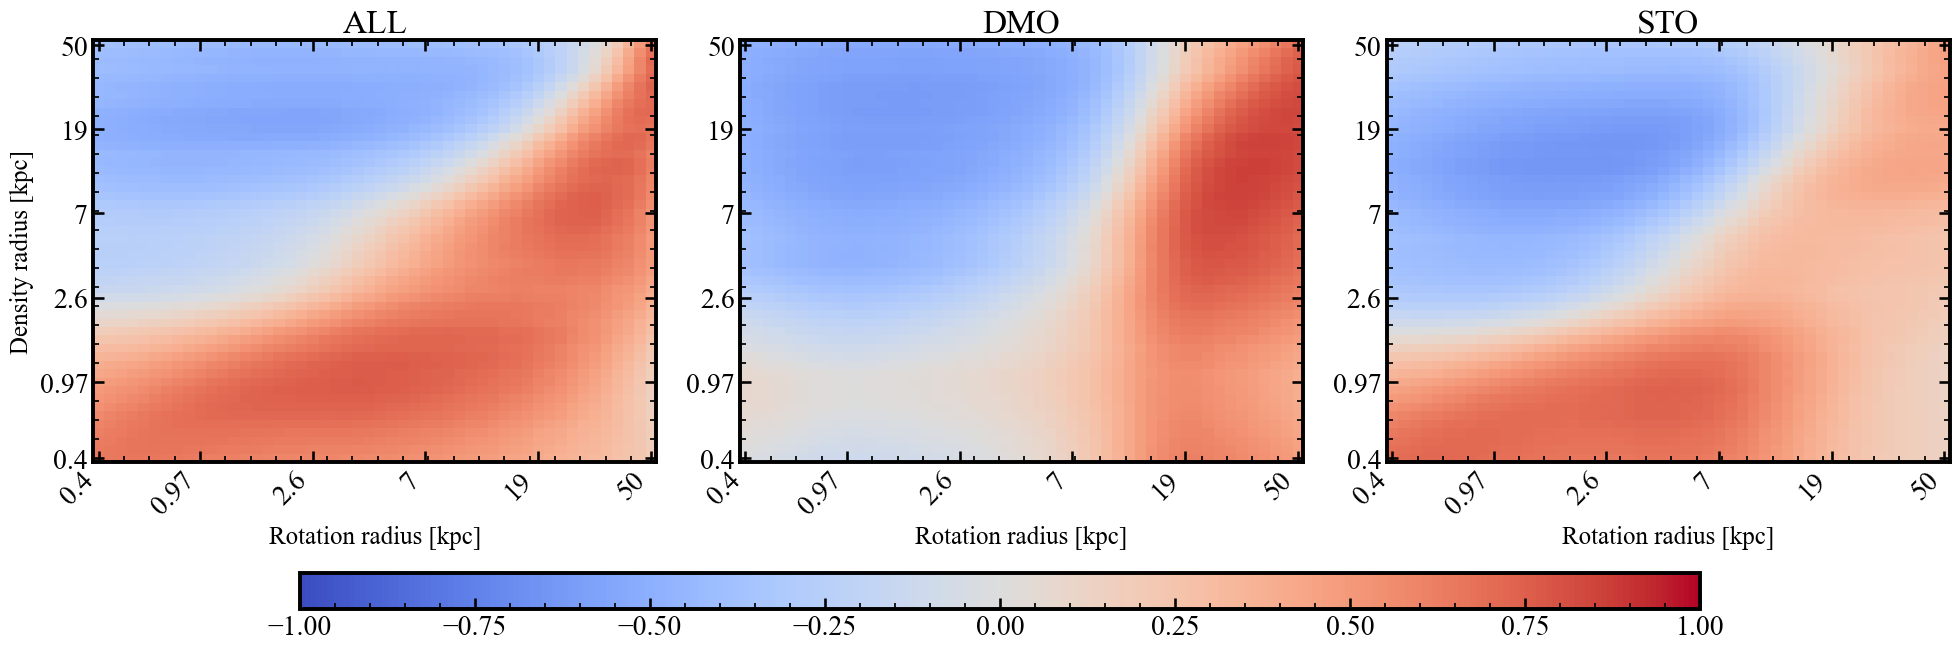

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _linear_scales_from_key(key):
    d = sum(len(g["cols"]) for g in key["groups"])
    s = np.zeros(d, dtype=np.float64)
    for g in key["groups"]:
        if g["mode"] != "linear":
            raise ValueError("This correlation path expects coefficient groups to be 'linear'.")
        cols = np.array(g["cols"], dtype=int)
        s[cols] = (float(g["hi"]) - float(g["lo"]))
    return s  # [d]

def _denorm(vec_np, key):
    assert vec_np.ndim == 1
    vec_np = vec_np.astype(np.float32)
    result = np.empty_like(vec_np)
    for group in key["groups"]:
        cols  = group["cols"]
        mode  = group["mode"]
        lo    = group["lo"]
        hi    = group["hi"]
        shift = group["shift"]
        work = vec_np[cols] * (hi - lo) + lo
        if mode == "linear":
            result[cols] = work
        elif mode == "log":
            result[cols] = np.exp(work) - shift
        else:
            raise ValueError(f"Unknown mode: {mode}")
    return result

@torch.no_grad()
def _mean_x_from_loader(loader, device, max_batches=None):
    """Compute mean X over a loader (in the same space the loader provides)."""
    s = None
    n = 0
    for bi, batch in enumerate(loader):
        if (max_batches is not None) and (bi >= max_batches):
            break

        if isinstance(batch, (tuple, list)):
            x_b = batch[0]
        elif isinstance(batch, dict):
            x_b = batch.get("x", batch.get("X"))
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")

        x_b = x_b.to(device).float()  # [B, dx]
        if s is None:
            s = x_b.sum(dim=0)
        else:
            s = s + x_b.sum(dim=0)
        n += x_b.shape[0]

    if s is None or n == 0:
        raise ValueError("Loader appears empty; cannot compute mean X.")
    return (s / n).detach().cpu().numpy()  # [dx]

@torch.no_grad()
def _corr_blocks_at_x(mean_net, cov_net, x_np, device, key_y, basis_meta, Y1_len=50):
    """
    Compute C11, C12, C22 in bin space at a single x (basis path).
    """
    # forward pass in normalized Y space
    xb = torch.from_numpy(np.asarray(x_np, dtype=np.float32)).to(device).unsqueeze(0)  # [1, dx]
    mean_net.eval(); cov_net.eval()
    mu_n = mean_net(xb)                 # [1, d]
    L_n  = cov_net(xb)                  # [1, d, d]
    Sigma_n = L_n @ L_n.transpose(1, 2) # [1, d, d]

    mu_n_np  = mu_n.squeeze(0).detach().cpu().numpy()       # [d]
    Sigma_np = Sigma_n.squeeze(0).detach().cpu().numpy()    # [d, d]

    # basis metadata
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."
    k1 = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    # denorm predicted coeffs to physical coeff space
    mu_coeff = _denorm(mu_n_np, key_y).astype(np.float64)   # [d]
    c1 = mu_coeff[:k1]
    c2 = mu_coeff[k1:]

    # mean bins (needed if LOG Jacobian)
    lin_mu1 = Phi1 @ c1
    lin_mu2 = Phi2 @ c2
    mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
    mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

    # coefficient covariance in physical coeff space: Σ_c = D Σ_n D
    scales = _linear_scales_from_key(key_y).astype(np.float64)  # [d]
    D = np.diag(scales)
    Sigma_c = D @ Sigma_np @ D.T

    Sigma_c11 = Sigma_c[:k1, :k1]
    Sigma_c22 = Sigma_c[k1:, k1:]
    Sigma_c12 = Sigma_c[:k1, k1:]

    # Jacobians into bin space
    J1 = (mu1[:, None] * Phi1) if LOG1 else Phi1
    J2 = (mu2[:, None] * Phi2) if LOG2 else Phi2

    # bin-space covariance blocks
    S11 = J1 @ Sigma_c11 @ J1.T
    S22 = J2 @ Sigma_c22 @ J2.T
    S12 = J1 @ Sigma_c12 @ J2.T

    # full bin covariance and correlation
    top = np.hstack([S11, S12])
    bot = np.hstack([S12.T, S22])
    Sigma_bins = np.vstack([top, bot])  # [(Y1+Y2),(Y1+Y2)]

    std = np.sqrt(np.clip(np.diag(Sigma_bins), 1e-12, None))
    Corr = Sigma_bins / (std[:, None] * std[None, :] + 1e-12)

    C11 = Corr[:Y1_len, :Y1_len]
    C12 = Corr[:Y1_len, Y1_len:]
    C22 = Corr[Y1_len:, Y1_len:]
    return C11, C12, C22

@torch.no_grad()
def plot_corr_blocks_at_mean_x_grid(
    loaders_dict,             # {"ALL": loader_all, "DMO": loader_dmo, "STO": loader_sto}
    models_dict,              # {"ALL": (mean_all, cov_all), ...}
    key_y_coeff_by_split,     # {"ALL": ALL_Yn_key, "DMO": DMO_Yn_key, "STO": STO_Yn_key}
    basis_meta,
    r_tags,
    device,
    Y1_len=50,
    n_r_ticks=6,
    max_batches_for_mean=None,   # set to an int to approximate mean_x faster
    savepath=None,
    title="C12: Corr(Y1, Y2) blocks at mean X",
):
    r = np.asarray(r_tags, dtype=float)
    tick_idx = np.unique(np.linspace(0, Y1_len - 1, n_r_ticks).astype(int))
    tick_lbl = [f"{val:.2g}" for val in r[tick_idx]]

    splits = ["ALL", "DMO", "STO"]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    last_im = None

    for col, name in enumerate(splits):
        loader = loaders_dict[name]
        mean_net, cov_net = models_dict[name]
        key_y = key_y_coeff_by_split[name]

        # mean X for this split
        mean_x = _mean_x_from_loader(
            loader, device=device, max_batches=max_batches_for_mean
        )

        # corr blocks at mean X
        C11, C12, C22 = _corr_blocks_at_x(
            mean_net=mean_net,
            cov_net=cov_net,
            x_np=mean_x,
            device=device,
            key_y=key_y,
            basis_meta=basis_meta,
            Y1_len=Y1_len
        )

        ax = axes[col]

        last_im = ax.imshow(
            C12, vmin=-1, vmax=1, cmap="coolwarm",
            origin="upper", aspect="auto"
        )

        # titles/labels
        ax.set_title(f"{name}", fontsize=24)
        ax.set_xlabel("Rotation radius [kpc]", fontsize=18)
        if col == 0:
            ax.set_ylabel("Density radius [kpc]", fontsize=18)

        ax.set_xticks(tick_idx)
        ax.set_xticklabels(tick_lbl, rotation=45, ha="right")
        ax.set_yticks(tick_idx)
        ax.set_yticklabels(tick_lbl)
        ax.invert_yaxis()

    # ---------- Horizontal Colorbar Under Plots ----------
    cbar_ax = fig.add_axes([0.16, -0.05, 0.7, 0.06])
    fig.colorbar(last_im, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title, y=0.98, fontsize=36)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)

    return fig


fig = plot_corr_blocks_at_mean_x_grid(
    loaders_dict={"ALL": ALL_test_loader, "DMO": DMO_test_loader, "STO": STO_test_loader},
    models_dict={"ALL": (ALL_mean_net, ALL_cov_net), "DMO": (DMO_mean_net, DMO_cov_net), "STO": (STO_mean_net, STO_cov_net)},
    key_y_coeff_by_split={"ALL": ALL_Yn_key, "DMO": DMO_Yn_key, "STO": STO_Yn_key},
    basis_meta=basis_meta,
    r_tags=r_tags,
    device=device,
    title = False,
    Y1_len=50,
    savepath="corr_blocks_meanX_grid.png",
)



Saved: C12_ALL_vs_avg_DMO_STO.png
Normalized Frobenius-norm distance (ALL vs avg(DMO,STO)) = 0.453282


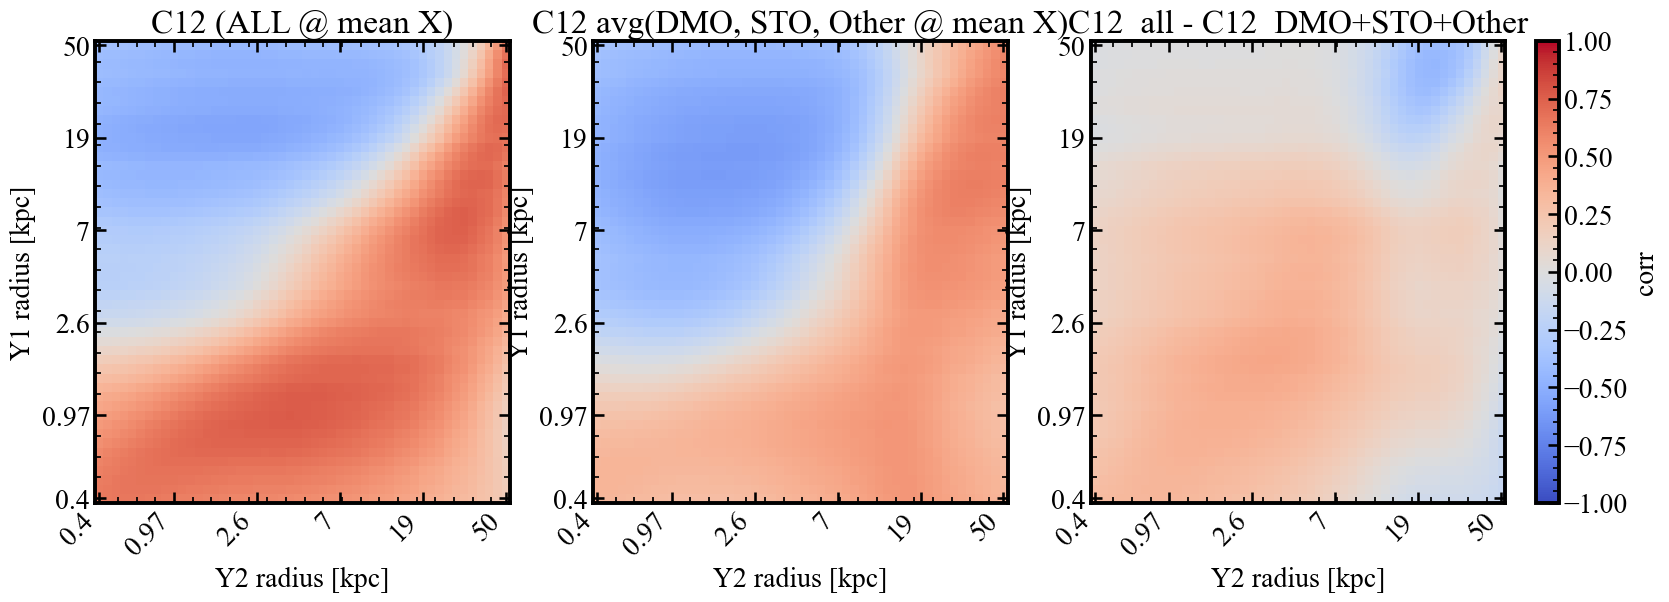

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _linear_scales_from_key(key):
    d = sum(len(g["cols"]) for g in key["groups"])
    s = np.zeros(d, dtype=np.float64)
    for g in key["groups"]:
        if g["mode"] != "linear":
            raise ValueError("This correlation path expects coefficient groups to be 'linear'.")
        cols = np.array(g["cols"], dtype=int)
        s[cols] = (float(g["hi"]) - float(g["lo"]))
    return s  # [d]

def _denorm(vec_np, key):
    assert vec_np.ndim == 1
    vec_np = vec_np.astype(np.float32)
    out = np.empty_like(vec_np)
    for g in key["groups"]:
        cols  = g["cols"]
        lo, hi = g["lo"], g["hi"]
        mode  = g["mode"]
        shift = g["shift"]
        work = vec_np[cols] * (hi - lo) + lo
        if mode == "linear":
            out[cols] = work
        elif mode == "log":
            out[cols] = np.exp(work) - shift
        else:
            raise ValueError(f"Unknown mode: {mode}")
    return out

@torch.no_grad()
def _mean_x_from_loader(loader, device, max_batches=None):
    s = None
    n = 0
    for bi, batch in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break

        if isinstance(batch, (tuple, list)):
            x_b = batch[0]
        elif isinstance(batch, dict):
            x_b = batch.get("x", batch.get("X"))
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")

        x_b = x_b.to(device).float()  # [B, dx]
        s = x_b.sum(dim=0) if s is None else (s + x_b.sum(dim=0))
        n += x_b.shape[0]

    if s is None or n == 0:
        raise ValueError("Loader appears empty; cannot compute mean X.")
    return (s / n).detach().cpu().numpy()  # [dx]

@torch.no_grad()
def _C12_at_x(mean_net, cov_net, x_np, device, key_y, basis_meta, Y1_len=50):
    """
    Compute the C12 correlation block in bin space at a single x (basis path).
    Returns C12 with shape [Y1_len, Y2_len].
    """
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."
    k1 = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)  # [Y1_len, k1]
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)  # [Y2_len, k2]
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    xb = torch.from_numpy(np.asarray(x_np, dtype=np.float32)).to(device).unsqueeze(0)  # [1, dx]
    mean_net.eval(); cov_net.eval()

    mu_n = mean_net(xb)                              # [1, d]
    L_n  = cov_net(xb)                               # [1, d, d]
    Sigma_n = L_n @ L_n.transpose(1, 2)              # [1, d, d]

    mu_n_np  = mu_n.squeeze(0).detach().cpu().numpy()     # [d]
    Sigma_np = Sigma_n.squeeze(0).detach().cpu().numpy()  # [d, d]

    # denorm predicted coefficients (physical coeff space)
    mu_coeff = _denorm(mu_n_np, key_y).astype(np.float64)
    c1 = mu_coeff[:k1]
    c2 = mu_coeff[k1:]

    # mean bins (needed for LOG Jacobians)
    lin_mu1 = Phi1 @ c1
    lin_mu2 = Phi2 @ c2
    mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
    mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

    # coeff covariance in physical coeff space
    scales = _linear_scales_from_key(key_y).astype(np.float64)
    D = np.diag(scales)
    Sigma_c = D @ Sigma_np @ D.T

    Sigma_c11 = Sigma_c[:k1, :k1]
    Sigma_c22 = Sigma_c[k1:, k1:]
    Sigma_c12 = Sigma_c[:k1, k1:]

    # Jacobians to bin space
    J1 = (mu1[:, None] * Phi1) if LOG1 else Phi1
    J2 = (mu2[:, None] * Phi2) if LOG2 else Phi2

    # bin-space covariance blocks
    S11 = J1 @ Sigma_c11 @ J1.T
    S22 = J2 @ Sigma_c22 @ J2.T
    S12 = J1 @ Sigma_c12 @ J2.T

    # assemble full bin covariance -> correlation
    top = np.hstack([S11, S12])
    bot = np.hstack([S12.T, S22])
    Sigma_bins = np.vstack([top, bot])

    std = np.sqrt(np.clip(np.diag(Sigma_bins), 1e-12, None))
    Corr = Sigma_bins / (std[:, None] * std[None, :] + 1e-12)

    C12 = Corr[:Y1_len, Y1_len:]
    return C12

@torch.no_grad()
def plot_C12_ALL_vs_avg_DMO_STO_and_frob(
    loaders_dict,          # {"ALL": loader_all, "DMO": loader_dmo, "STO": loader_sto}
    models_dict,           # {"ALL": (mean_all, cov_all), ...}
    key_y_by_split,        # {"ALL": key_y_all, "DMO": key_y_dmo, "STO": key_y_sto}
    basis_meta,
    r_tags,
    device,
    Y1_len=50,
    n_r_ticks=6,
    max_batches_for_mean=None,
    savepath=None,
    title="C12 at mean X: ALL vs avg(DMO, STO)",
    eps=1e-12,
):
    r = np.asarray(r_tags, dtype=float)
    tick_idx = np.unique(np.linspace(0, Y1_len - 1, n_r_ticks).astype(int))
    tick_lbl = [f"{val:.2g}" for val in r[tick_idx]]

    # mean X for each split
    x_all = _mean_x_from_loader(loaders_dict["ALL"], device=device, max_batches=max_batches_for_mean)
    x_dmo = _mean_x_from_loader(loaders_dict["DMO"], device=device, max_batches=max_batches_for_mean)
    x_sto = _mean_x_from_loader(loaders_dict["STO"], device=device, max_batches=max_batches_for_mean)
    x_sto = _mean_x_from_loader(loaders_dict["Other"], device=device, max_batches=max_batches_for_mean)

    # compute C12 blocks at those mean X points
    C12_all = _C12_at_x(*models_dict["ALL"], x_all, device, key_y_by_split["ALL"], basis_meta, Y1_len=Y1_len)
    C12_dmo = _C12_at_x(*models_dict["DMO"], x_dmo, device, key_y_by_split["DMO"], basis_meta, Y1_len=Y1_len)
    C12_sto = _C12_at_x(*models_dict["STO"], x_sto, device, key_y_by_split["STO"], basis_meta, Y1_len=Y1_len)
    C12_Other = _C12_at_x(*models_dict["Other"], x_sto, device, key_y_by_split["Other"], basis_meta, Y1_len=Y1_len)

    C12_avg = (C12_dmo + C12_sto)/2

    # normalized Frobenius distance (ALL as reference)
    frob_num = np.linalg.norm(C12_all - C12_avg, ord="fro")
    frob_den = np.linalg.norm(C12_all, ord="fro") + eps
    frob_norm_dist = frob_num / frob_den

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    im0 = axes[0].imshow(C12_all, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im1 = axes[1].imshow(C12_avg, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im1 = axes[2].imshow(C12_all-C12_avg, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")

    axes[0].set_title("C12 (ALL @ mean X)")
    axes[1].set_title("C12 avg(DMO, STO, Other @ mean X)")
    axes[2].set_title("C12_all - C12_DMO+STO+Other")

    for ax in axes:
        ax.set_xlabel("Y2 radius [kpc]")
        ax.set_ylabel("Y1 radius [kpc]")
        ax.set_xticks(tick_idx)
        ax.set_xticklabels(tick_lbl, rotation=45, ha="right")
        ax.set_yticks(tick_idx)
        ax.set_yticklabels(tick_lbl)
        ax.invert_yaxis()

    # leave room for colorbar
    fig.subplots_adjust(right=0.88)
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.046, pad=0.02)
    cbar.set_label("corr")

    if title:
        fig.suptitle(f"{title}\nNormalized Frobenius distance = {frob_norm_dist:.4g}", y=0.98)

    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)

    print(f"Normalized Frobenius-norm distance (ALL vs avg(DMO,STO)) = {frob_norm_dist:.6g}")
    return fig, frob_norm_dist, C12_all, C12_avg

fig, frob_dist, C12_all, C12_avg = plot_C12_ALL_vs_avg_DMO_STO_and_frob(
    loaders_dict={
        "ALL": ALL_test_loader,
        "DMO": DMO_test_loader,
        "STO": STO_test_loader,
        "Other": Other_test_loader,
    },
    models_dict={
        "ALL": (ALL_mean_net, ALL_cov_net),
        "DMO": (DMO_mean_net, DMO_cov_net),
        "STO": (STO_mean_net, STO_cov_net),
        "Other": (Other_mean_net, Other_cov_net),
    },
    key_y_by_split={
        "ALL": ALL_Yn_key,
        "DMO": DMO_Yn_key,
        "STO": STO_Yn_key,
        "Other": Other_Yn_key,
    },
    basis_meta=basis_meta,
    r_tags=r_tags,
    device=device,
    Y1_len=50,
    n_r_ticks=6,
    max_batches_for_mean=None,   # set e.g. to 10 if you want an approximate mean X
    savepath="C12_ALL_vs_avg_DMO_STO.png",
    title=False,
)


Saved: C12_level0p3_stacked_arrows.png
Saved: C12_level0p3_stacked_arrows.png


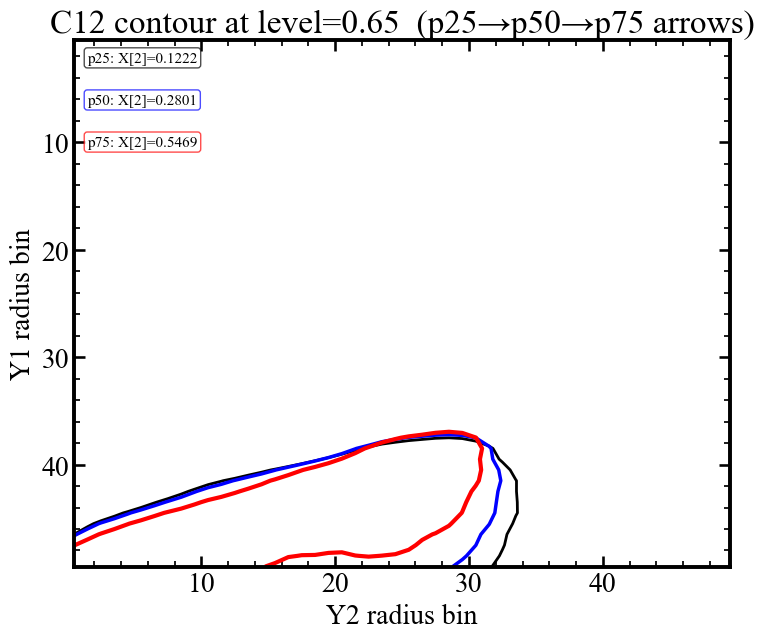

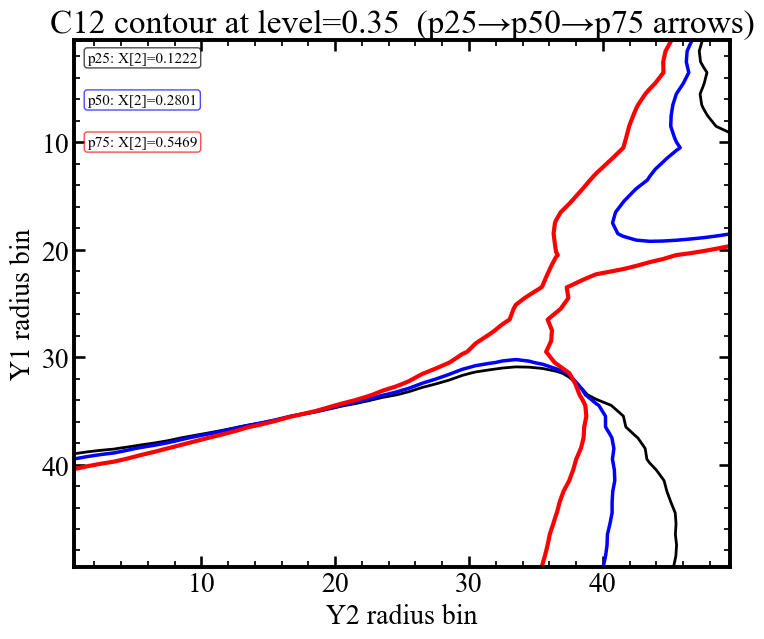

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- helpers you already have (included here for completeness) ---
def _linear_scales_from_key(key):
    d = sum(len(g["cols"]) for g in key["groups"])
    s = np.zeros(d, dtype=np.float64)
    for g in key["groups"]:
        if g["mode"] != "linear":
            raise ValueError("This correlation path expects coefficient groups to be 'linear'.")
        cols = np.array(g["cols"], dtype=int)
        s[cols] = (float(g["hi"]) - float(g["lo"]))
    return s

def _denorm(vec_np, key):
    assert vec_np.ndim == 1
    vec_np = vec_np.astype(np.float32)
    out = np.empty_like(vec_np)
    for g in key["groups"]:
        cols  = g["cols"]
        lo, hi = g["lo"], g["hi"]
        mode  = g["mode"]
        shift = g["shift"]
        work = vec_np[cols] * (hi - lo) + lo
        if mode == "linear":
            out[cols] = work
        elif mode == "log":
            out[cols] = np.exp(work) - shift
        else:
            raise ValueError(f"Unknown mode: {mode}")
    return out

@torch.no_grad()
def _mean_x_from_loader(loader, device, max_batches=None):
    s = None
    n = 0
    for bi, batch in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break
        if isinstance(batch, (tuple, list)):
            x_b = batch[0]
        elif isinstance(batch, dict):
            x_b = batch.get("x", batch.get("X"))
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")
        x_b = x_b.to(device).float()
        s = x_b.sum(dim=0) if s is None else (s + x_b.sum(dim=0))
        n += x_b.shape[0]
    if s is None or n == 0:
        raise ValueError("Loader empty; cannot compute mean X.")
    return (s / n).detach().cpu().numpy()

@torch.no_grad()
def _percentiles_of_x_idx(loader, device, x_idx, percentiles=(25, 50, 75), max_batches=None):
    vals = []
    for bi, batch in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break
        if isinstance(batch, (tuple, list)):
            x_b = batch[0]
        elif isinstance(batch, dict):
            x_b = batch.get("x", batch.get("X"))
        else:
            raise TypeError(f"Unknown batch type: {type(batch)}")
        x_b = x_b.to(device).float()
        vals.append(x_b[:, x_idx].detach().cpu().numpy())
    if len(vals) == 0:
        raise ValueError("Loader empty; cannot compute X percentiles.")
    v = np.concatenate(vals, axis=0)
    return np.percentile(v, percentiles).astype(np.float64)

@torch.no_grad()
def _C12_at_x(mean_net, cov_net, x_np, device, key_y, basis_meta, Y1_len=50):
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."
    k1 = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    xb = torch.from_numpy(np.asarray(x_np, dtype=np.float32)).to(device).unsqueeze(0)
    mean_net.eval(); cov_net.eval()
    mu_n = mean_net(xb)
    L_n  = cov_net(xb)
    Sigma_n = L_n @ L_n.transpose(1, 2)

    mu_n_np  = mu_n.squeeze(0).detach().cpu().numpy()
    Sigma_np = Sigma_n.squeeze(0).detach().cpu().numpy()

    mu_coeff = _denorm(mu_n_np, key_y).astype(np.float64)
    c1, c2 = mu_coeff[:k1], mu_coeff[k1:]

    lin_mu1 = Phi1 @ c1
    lin_mu2 = Phi2 @ c2
    mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
    mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

    scales = _linear_scales_from_key(key_y).astype(np.float64)
    D = np.diag(scales)
    Sigma_c = D @ Sigma_np @ D.T

    Sigma_c11 = Sigma_c[:k1, :k1]
    Sigma_c22 = Sigma_c[k1:, k1:]
    Sigma_c12 = Sigma_c[:k1, k1:]

    J1 = (mu1[:, None] * Phi1) if LOG1 else Phi1
    J2 = (mu2[:, None] * Phi2) if LOG2 else Phi2

    S11 = J1 @ Sigma_c11 @ J1.T
    S22 = J2 @ Sigma_c22 @ J2.T
    S12 = J1 @ Sigma_c12 @ J2.T

    top = np.hstack([S11, S12])
    bot = np.hstack([S12.T, S22])
    Sigma_bins = np.vstack([top, bot])

    std = np.sqrt(np.clip(np.diag(Sigma_bins), 1e-12, None))
    Corr = Sigma_bins / (std[:, None] * std[None, :] + 1e-12)
    return Corr[:Y1_len, Y1_len:]  # C12

def _largest_contour_centroid(cs):
    """
    Given a matplotlib ContourSet (single level), return centroid (x,y) of the
    largest segment. Coordinates are in image index space (x=col, y=row).
    Returns None if no contour exists.
    """
    if cs is None or len(cs.allsegs) == 0 or len(cs.allsegs[0]) == 0:
        return None

    segs = cs.allsegs[0]
    # pick largest by number of vertices
    seg = max(segs, key=lambda a: a.shape[0])
    x = seg[:, 0].mean()
    y = seg[:, 1].mean()
    return (x, y)

@torch.no_grad()
def plot_C12_single_level_contours_stacked_with_arrows(
    loader,
    mean_net,
    cov_net,
    key_y_coeff,
    basis_meta,
    device,
    level,                  # "height" in corr units
    x_idx,                  # which X dim to vary
    Y1_len=50,
    percentiles=(25, 50, 75),
    max_batches_for_stats=None,
    show_background=True,
    background_alpha=0.30,
    background_source="p50",   # "p25" | "p50" | "p75" | "none"
    linewidths=(2.0, 2.5, 3.0),
    linestyles=("-", "-", "-"),
    arrow_scale=18,            # bigger -> larger arrow head
    arrow_alpha=0.9,
    savepath=None,
    title=None,
):
    """
    One-axes plot: overlays the contour C12==level at p25,p50,p75 of X[:,x_idx],
    with small arrows indicating motion of the contour from p25->p50->p75.
    """

    # 1) mean-x and chosen percentiles (in loader space)
    x_mean = _mean_x_from_loader(loader, device=device, max_batches=max_batches_for_stats)
    pvals  = _percentiles_of_x_idx(loader, device=device, x_idx=x_idx,
                                   percentiles=percentiles, max_batches=max_batches_for_stats)

    # 2) compute fields
    C12s = []
    xs   = []
    for pv in pvals:
        x_use = x_mean.copy()
        x_use[x_idx] = pv
        xs.append(x_use)
        C12s.append(_C12_at_x(mean_net, cov_net, x_use, device, key_y_coeff, basis_meta, Y1_len=Y1_len))

    C12_p25, C12_p50, C12_p75 = C12s

    # 3) plot
    fig, ax = plt.subplots(1, 1, figsize=(7.8, 6.8))

    # optional background heatmap
    bg = None
    if show_background and background_source != "none":
        bg_map = {"p25": C12_p25, "p50": C12_p50, "p75": C12_p75}[background_source]
        bg = ax.imshow(bg_map, vmin=-1, vmax=1, cmap="coolwarm", origin="upper",
                       aspect="auto", alpha=background_alpha)

    # 4) contours + centroids
    centroids = []
    contour_sets = []
    colors = ["k", "b", "r"]
    for C12, pct, pv, lw, ls, cl in zip(C12s, percentiles, pvals, linewidths, linestyles, colors):
        cs = ax.contour(C12, levels=[level], origin="upper", linewidths=lw, linestyles=ls, colors= cl)
        contour_sets.append(cs)
        centroids.append(_largest_contour_centroid(cs))

        # annotate which percentile (small label)
        ax.text(
            0.02, 0.98 - 0.08 * (list(percentiles).index(pct)),
            f"p{pct}: X[{x_idx}]={pv:.4g}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor=cl),
        )

    # 5) arrows showing “direction of travel” p25 -> p50 -> p75
    # We use representative points (centroids of largest contour component).
    for a, b in [(0, 1), (1, 2)]:
        pa = centroids[a]
        pb = centroids[b]
        if (pa is None) or (pb is None):
            continue
        dx = pb[0] - pa[0]
        dy = pb[1] - pa[1]
        ax.annotate(
            "",
            xy=(pb[0], pb[1]),
            xytext=(pa[0], pa[1]),
            # arrowprops=dict(arrowstyle="->", lw=2.0, alpha=arrow_alpha, mutation_scale=arrow_scale),
        )

    # 6) formatting
    ax.set_title(f"C12 contour at level={level:.3g}  (p25→p50→p75 arrows)" if title is None else title)
    ax.set_xlabel("Y2 radius bin")
    ax.set_ylabel("Y1 radius bin")
    ax.invert_yaxis()

    if bg is not None:
        fig.subplots_adjust(right=0.86)
        cbar = fig.colorbar(bg, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label("corr")

    plt.tight_layout(rect=[0, 0, 0.86 if bg is not None else 1.0, 1.0])

    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)

    # helpful warnings if level doesn't exist at some percentile
    missing = [f"p{pct}" for pct, c in zip(percentiles, centroids) if c is None]
    if missing:
        print(f"Warning: no contour at level={level} for {', '.join(missing)} (level not present in those C12 maps).")

    return fig, {"percentiles": percentiles, "pvals": pvals, "C12_list": C12s, "centroids": centroids, "x_idx": x_idx, "level": level}

fig, out = plot_C12_single_level_contours_stacked_with_arrows(
    loader=STO_test_loader,
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    key_y_coeff=STO_Yn_key,
    basis_meta=basis_meta,
    device=device,
    level=0.65,
    x_idx=2,
    show_background=False,
    background_source="p50",
    savepath="C12_level0p3_stacked_arrows.png",
)

fig, out = plot_C12_single_level_contours_stacked_with_arrows(
    loader=STO_test_loader,
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    key_y_coeff=STO_Yn_key,
    basis_meta=basis_meta,
    device=device,
    level=0.35,
    x_idx=2,
    show_background=False,
    background_source="p50",
    savepath="C12_level0p3_stacked_arrows.png",
)


Saved: C12_level0p3_stacked_arrows.png


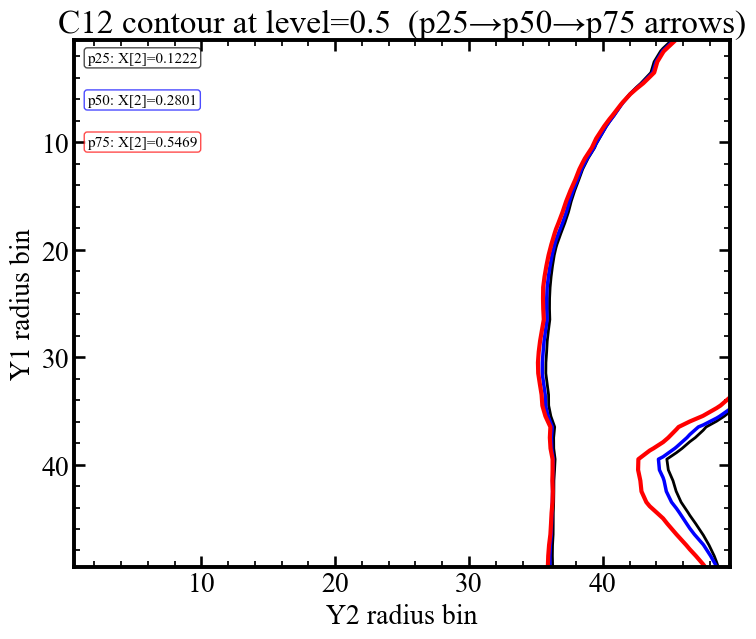

In [29]:
fig, out = plot_C12_single_level_contours_stacked_with_arrows(
    loader=DMO_test_loader,
    mean_net=DMO_mean_net,
    cov_net=DMO_cov_net,
    key_y_coeff=DMO_Yn_key,
    basis_meta=basis_meta,
    device=device,
    level=0.5,
    x_idx=2,
    show_background=False,
    background_source="p50",
    savepath="C12_level0p3_stacked_arrows.png",
)

Saved: C12_level0p3_stacked_arrows.png


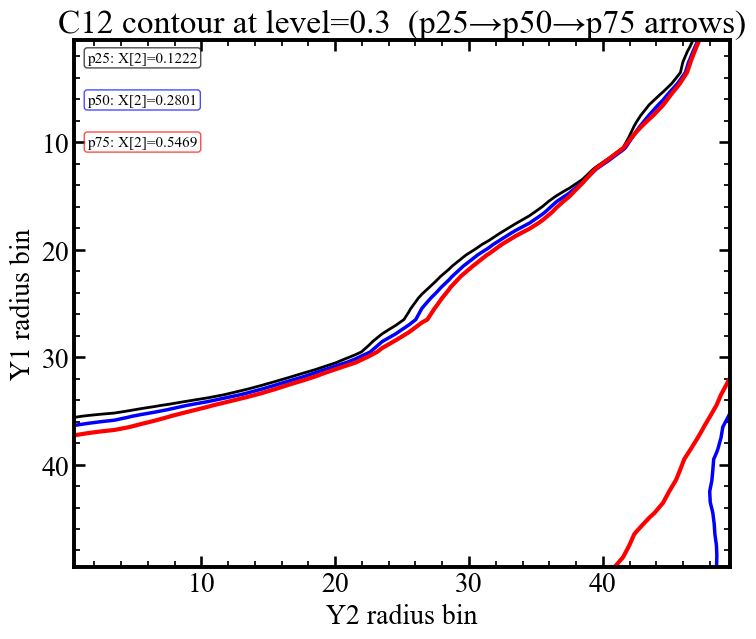

In [30]:
fig, out = plot_C12_single_level_contours_stacked_with_arrows(
    loader=ALL_test_loader,
    mean_net=ALL_mean_net,
    cov_net=ALL_cov_net,
    key_y_coeff=ALL_Yn_key,
    basis_meta=basis_meta,
    device=device,
    level=0.3,
    x_idx=2,
    show_background=False,
    background_source="p50",
    savepath="C12_level0p3_stacked_arrows.png",
)

In [31]:
@torch.no_grad()
def plot_C12_ALL_vs_NOMASS_ALL(
    loaders_dict,          # {"ALL": loader_all, "DMO": loader_dmo, "STO": loader_sto}
    models_dict,           # {"ALL": (mean_all, cov_all), ...}
    key_y_by_split,        # {"ALL": key_y_all, "DMO": key_y_dmo, "STO": key_y_sto}
    basis_meta,
    r_tags,
    device,
    Y1_len=50,
    n_r_ticks=6,
    max_batches_for_mean=None,
    savepath=None,
    title="C12 at mean X: ALL vs avg(DMO, STO)",
    eps=1e-12,
):
    r = np.asarray(r_tags, dtype=float)
    tick_idx = np.unique(np.linspace(0, Y1_len - 1, n_r_ticks).astype(int))
    tick_lbl = [f"{val:.2g}" for val in r[tick_idx]]

    # mean X for each split
    x_all = _mean_x_from_loader(loaders_dict["ALL"], device=device, max_batches=max_batches_for_mean)
    x_NOMASS_all = _mean_x_from_loader(loaders_dict["NOMASS_ALL"], device=device, max_batches=max_batches_for_mean)

    # compute C12 blocks at those mean X points
    C12_all = _C12_at_x(*models_dict["ALL"], x_all, device, key_y_by_split["ALL"], basis_meta, Y1_len=Y1_len)
    C12_NOMASS_all = _C12_at_x(*models_dict["NOMASS_ALL"], x_NOMASS_all, device, key_y_by_split["NOMASS_ALL"], basis_meta, Y1_len=Y1_len)

    # normalized Frobenius distance (ALL as reference)
    frob_num = np.linalg.norm(C12_all - C12_NOMASS_all, ord="fro")
    frob_den = np.linalg.norm(C12_all, ord="fro") + eps
    frob_norm_dist = frob_num / frob_den

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    im0 = axes[0].imshow(C12_all, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im1 = axes[1].imshow(C12_NOMASS_all, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")
    im1 = axes[2].imshow(C12_all-C12_NOMASS_all, vmin=-1, vmax=1, cmap="coolwarm", origin="upper", aspect="auto")

    axes[0].set_title("C12 (ALL @ mean X)")
    axes[1].set_title("C12 avg(NOMASS all @ mean X)")
    axes[2].set_title("C12_all - C12_NOMASS_all")

    for ax in axes:
        ax.set_xlabel("Y2 radius [kpc]")
        ax.set_ylabel("Y1 radius [kpc]")
        ax.set_xticks(tick_idx)
        ax.set_xticklabels(tick_lbl, rotation=45, ha="right")
        ax.set_yticks(tick_idx)
        ax.set_yticklabels(tick_lbl)
        ax.invert_yaxis()

    # leave room for colorbar
    fig.subplots_adjust(right=0.88)
    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.046, pad=0.02)
    cbar.set_label("corr")

    if title:
        fig.suptitle(f"{title}\nNormalized Frobenius distance = {frob_norm_dist:.4g}", y=0.98)

    if savepath:
        plt.savefig(savepath, dpi=160)
        print("Saved:", savepath)

    print(f"Normalized Frobenius-norm distance (ALL vs avg(DMO,STO)) = {frob_norm_dist:.6g}")
    return fig, frob_norm_dist, C12_all, C12_avg



Saved: C12_ALL_vs_avg_DMO_STO.png
Normalized Frobenius-norm distance (ALL vs avg(DMO,STO)) = 1.03052


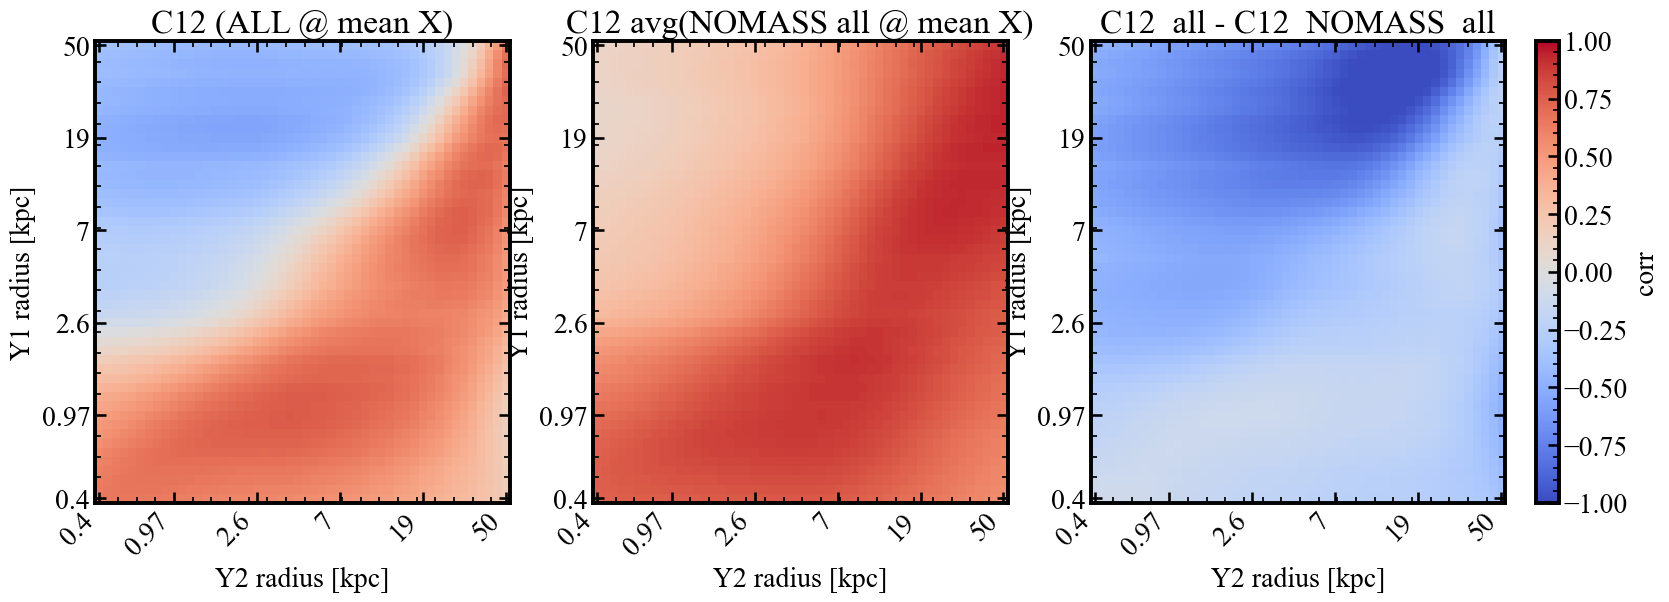

In [32]:
fig, frob_dist, C12_all, C12_avg = plot_C12_ALL_vs_NOMASS_ALL(
    loaders_dict={
        "ALL": ALL_test_loader,
        "NOMASS_ALL": NOMASS_ALL_test_loader,
    },
    models_dict={
        "ALL": (ALL_mean_net, ALL_cov_net),
        "NOMASS_ALL": (NOMASS_ALL_mean_net, NOMASS_ALL_cov_net),
    },
    key_y_by_split={
        "ALL": ALL_Yn_key,
        "NOMASS_ALL": NOMASS_ALL_Yn_key,
    },
    basis_meta=basis_meta,
    r_tags=r_tags,
    device=device,
    Y1_len=50,
    n_r_ticks=6,
    max_batches_for_mean=None,   # set e.g. to 10 if you want an approximate mean X
    savepath="C12_ALL_vs_avg_DMO_STO.png",
    title=False,
)

In [33]:
@torch.no_grad()
def plot_profiles_and_C12_percentiles_grid(
    loader,
    mean_net,
    cov_net,
    key_y_coeff,
    basis_meta,
    device,
    r_tags,
    x_indices,                  # list/iterable of X dims, e.g. [1,3,4]
    level,                      # contour level in corr units
    Y1_len=50,
    percentiles=(25, 50, 75),
    ci_sigma=2.0,
    show_background=True,
    background_alpha=0.30,
    background_source="p50",    # "p25" | "p50" | "p75" | "none"
    linewidths=(2.0, 2.5, 3.0),
    linestyles=("-", "-", "-"),
    savepath=None,
    title=None,
):
    """
    For each X index in x_indices, make a row with three columns:

        col 0: Y1 profiles at percentiles + bands
        col 1: Y2 profiles at percentiles + bands
        col 2: C12 corr block with contours (NO arrows),
               axes labeled with r_tags, horizontally flipped.
    """

    param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

    use_basis = (basis_meta is not None) and bool(basis_meta.get("use_basis", False))
    if not use_basis:
        raise ValueError("Provide basis_meta with use_basis=True.")

    x_indices = list(x_indices)
    n_rows = len(x_indices)
    if n_rows == 0:
        raise ValueError("x_indices must contain at least one index.")

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    r = np.asarray(r_tags, dtype=float)

    scales_c = _linear_scales_from_key(key_y_coeff).astype(np.float64)
    D = np.diag(scales_c)

    mean_x = _mean_x_from_loader(loader, device=device, max_batches=None)

    def _bins_and_bands_from_xvec(x_vec):
        xb = torch.from_numpy(x_vec.astype(np.float32)).to(device).unsqueeze(0)
        mean_net.eval()
        cov_net.eval()

        mu_n = mean_net(xb)
        L_n  = cov_net(xb)
        Sigma_n = (L_n @ L_n.transpose(1, 2)).squeeze(0).detach().cpu().numpy()
        mu_n_np = mu_n.squeeze(0).detach().cpu().numpy()

        c_mu = _denorm(mu_n_np, key_y_coeff).astype(np.float64)
        c1_mu, c2_mu = c_mu[:k1], c_mu[k1:]

        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

        Sigma_c   = D @ Sigma_n @ D.T
        S11 = Sigma_c[:k1, :k1]
        S22 = Sigma_c[k1:, k1:]

        if LOG1:
            Slog = Phi1 @ S11 @ Phi1.T
            s = np.sqrt(np.clip(np.diag(Slog), 0, None))
            lo1 = np.exp(lin_mu1 - ci_sigma * s)
            up1 = np.exp(lin_mu1 + ci_sigma * s)
        else:
            S = Phi1 @ S11 @ Phi1.T
            s = np.sqrt(np.clip(np.diag(S), 0, None))
            lo1, up1 = mu1 - ci_sigma*s, mu1 + ci_sigma*s

        if LOG2:
            Slog = Phi2 @ S22 @ Phi2.T
            s = np.sqrt(np.clip(np.diag(Slog), 0, None))
            lo2 = np.exp(lin_mu2 - ci_sigma * s)
            up2 = np.exp(lin_mu2 + ci_sigma * s)
        else:
            S = Phi2 @ S22 @ Phi2.T
            s = np.sqrt(np.clip(np.diag(S), 0, None))
            lo2, up2 = mu2 - ci_sigma*s, mu2 + ci_sigma*s

        return mu1, mu2, lo1, up1, lo2, up2

    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4.6 * n_rows))
    axes = np.atleast_2d(axes)
    last_bg_im = None

    tick_idx = np.unique(np.linspace(0, len(r)-1, 6).astype(int))
    tick_lbl = [f"{v:.2g}" for v in r[tick_idx]]

    for row, x_idx in enumerate(x_indices):
        ax_y1 = axes[row, 0]
        ax_y2 = axes[row, 1]
        ax_c  = axes[row, 2]

        pvals = _percentiles_of_x_idx(loader, device, x_idx, percentiles)

        C12s = []
        profs = []
        for pv in pvals:
            x_use = mean_x.copy()
            x_use[x_idx] = pv

            C12 = _C12_at_x(mean_net, cov_net, x_use, device, key_y_coeff, basis_meta, Y1_len=Y1_len)

            # ----------- FLIP ABOUT VERTICAL AXIS -----------
            # flip left-right AND top-bottom
            # C12 = np.fliplr(np.flipud(C12))

            C12s.append(C12)

            profs.append(_bins_and_bands_from_xvec(x_use))

        colors = ["tab:blue", "k", "tab:red"]

        # ---------------- Y1 ----------------
        for pct, c, (mu1, mu2, lo1, up1, lo2, up2), pv in zip(percentiles, colors, profs, pvals):
            ax_y1.plot(r, mu1, lw=2, color=c, label=f"$X_i^{({pct})}$")
            ax_y1.fill_between(r, lo1, up1, color=c, alpha=0.2)
        ax_y1.set_xscale("log"); ax_y1.set_yscale("log")
        if row == 2:
            ax_y1.set_xlabel("Radius [kpc]")
        ax_y1.set_ylabel("Density")
        if row == 0:
            ax_y1.set_title(f"Density Profile")
        # ax_y1.legend(fontsize=9)

        # ---------------- Y2 ----------------
        for pct, c, (mu1, mu2, lo1, up1, lo2, up2), pv in zip(percentiles, colors, profs, pvals):
            ax_y2.plot(r, mu2, lw=2, color=c, label=f"p{pct} X[{x_idx}]={pv:.3g}")
            ax_y2.fill_between(r, lo2, up2, color=c, alpha=0.2)
        ax_y2.set_xscale("log"); # ax_y2.set_yscale("log")
        if row == 2:
            ax_y2.set_xlabel("Radius [kpc]")
        ax_y2.set_ylabel("Rotation")
        if row == 0:
            ax_y2.set_title(f"Rotation Curve")
        # ax_y2.legend(fontsize=9)

        # ---------------- C12 ----------------
        Cmap_dict = dict(zip(percentiles, C12s))

        # background
        if show_background and background_source != "none":
            src = {"p25": 25, "p50": 50, "p75": 75}[background_source]
            bgmap = Cmap_dict[src]
            X, Y = np.meshgrid(r, r)

            last_bg_im = ax_c.pcolormesh(
                X, Y, bgmap,
                cmap="coolwarm",
                vmin=-1, vmax=1,
                shading="auto",
                alpha = 0.6
            )

            ax_c.set_xscale("log")
            ax_c.set_yscale("log")


        # contours (NO arrows)
        for pct, lw, ls, col in zip(percentiles, linewidths, linestyles, colors):
            ax_c.contour(
                X, Y, Cmap_dict[pct],
                levels=[level],
                linewidths=lw,
                linestyles=ls,
                colors=col
            )


        if row == 0:
            ax_c.set_title(f"Corralation with contour lines at {level:.3g}")

        if row == 2:
            ax_c.set_xlabel("Rotation radius [kpc]")
        
        ax_c.set_ylabel("Density radius [kpc]")
        """ax_c.set_xticks(r[tick_idx])
        ax_c.set_xticklabels(tick_lbl, rotation=45)
        ax_c.set_yticks(r[tick_idx])
        ax_c.set_yticklabels(tick_lbl)"""
        ax_c.invert_yaxis()

        ax_c.set_xlim(r.min(), r.max())
        ax_c.set_ylim(r.min(), r.max())

        y_pos = .82 - (row/1.16) / float(n_rows)

        fig.text(
            0.00,               # x-position (move left/right)
            y_pos,              # y-position (move up/down)
            param_labels[x_idx],      # text for that row
            rotation=90,
            va="center",
            ha="center",
            fontsize=24,
            fontweight="bold",
        )

    """
    if show_background and last_bg_im is not None:
        cax = fig.add_axes([0.15, 0.03, 0.70, 0.015])
        cbar = fig.colorbar(last_bg_im, cax=cax, orientation="horizontal")
        cbar.set_label("corr")"""

    handles, labels = axes[0,0].get_legend_handles_labels()

    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),  # x, y in figure coords
        ncol=3,                      # p25 / p50 / p75 in one row
        fontsize=18,
        frameon=True,
        columnspacing=9,
    )

    plt.tight_layout(rect=[0, 0.06, 1, 0.97])
    if savepath:
        plt.savefig(savepath, dpi=170)
        print("Saved:", savepath)

    return fig



Saved: /home/gjc7gx/CovNNet/Figures/profiles_C12_percentiles_grid.png


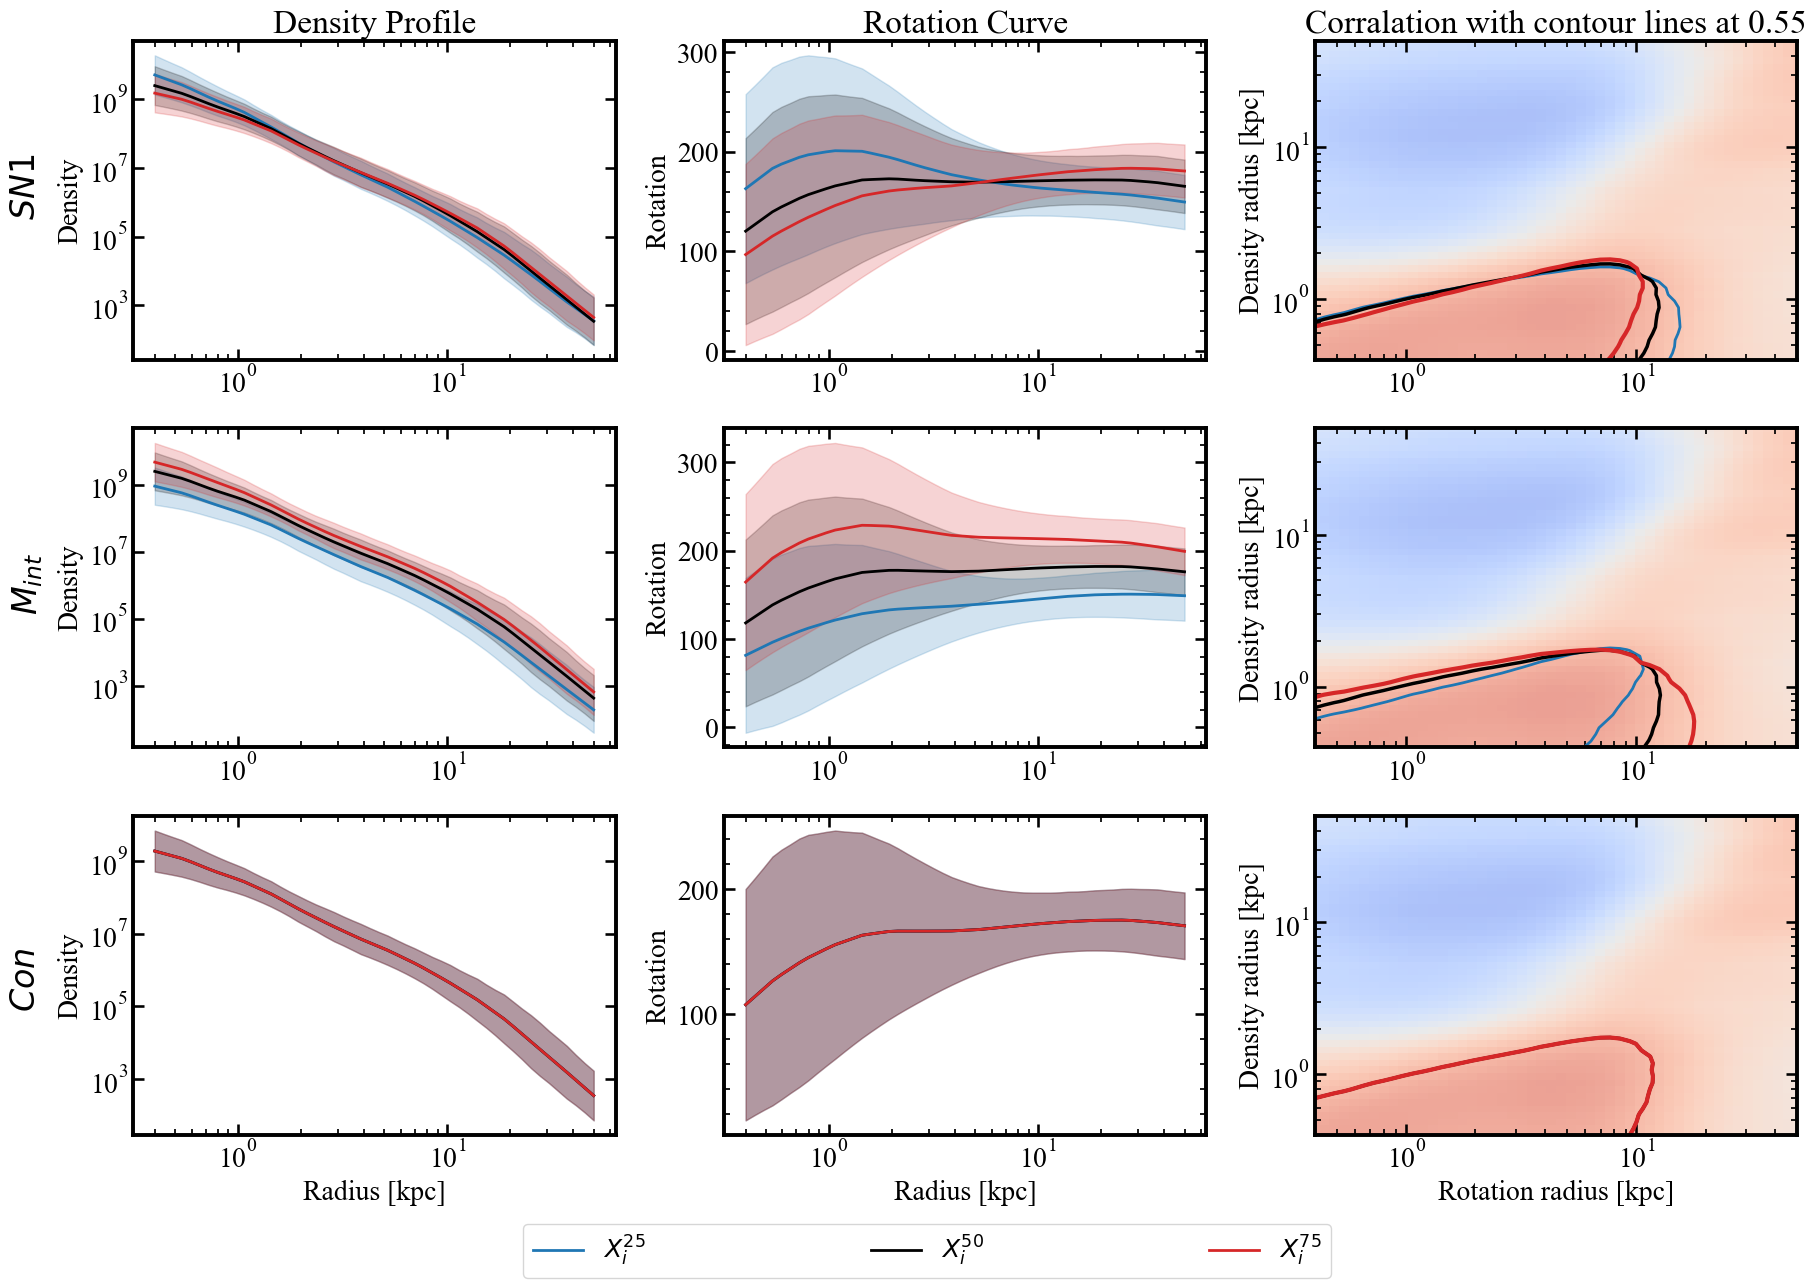

In [34]:
fig = plot_profiles_and_C12_percentiles_grid(
    loader=STO_test_loader,
    mean_net=STO_mean_net,
    cov_net=STO_cov_net,
    key_y_coeff=STO_Yn_key,
    basis_meta=basis_meta,
    device=device,
    r_tags=r_tags,
    x_indices=[2, 5, 6],
    level=0.55,
    Y1_len=50,
    percentiles=(25, 50, 75),
    ci_sigma=2.0,
    show_background=True,
    background_source="p50",
    savepath="/home/gjc7gx/CovNNet/Figures/profiles_C12_percentiles_grid.png",
)


Saved: /home/gjc7gx/CovNNet/Figures/profiles_C12_percentiles_grid.png


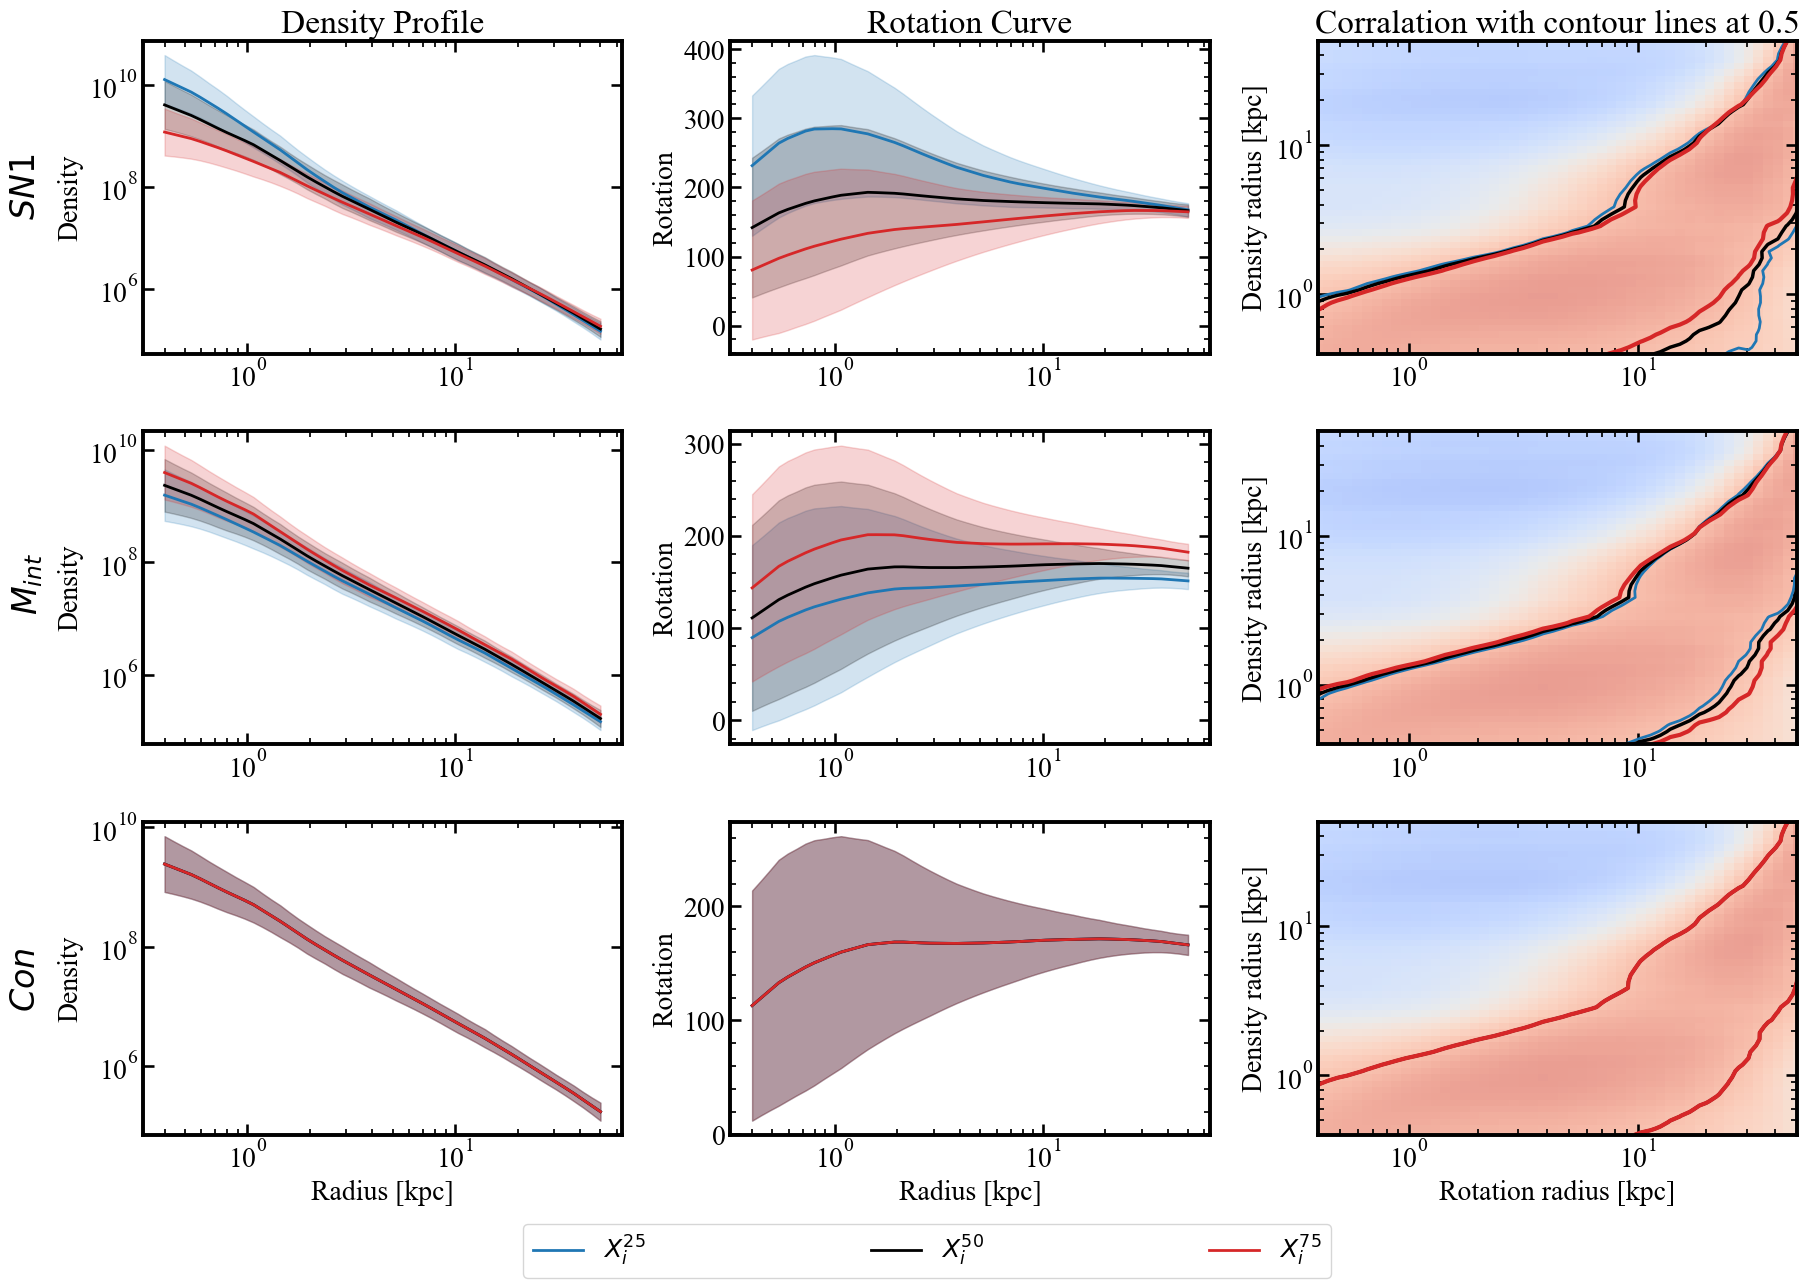

In [35]:
fig = plot_profiles_and_C12_percentiles_grid(
    loader=ALL_test_loader,
    mean_net=ALL_mean_net,
    cov_net=ALL_cov_net,
    key_y_coeff=ALL_Yn_key,
    basis_meta=basis_meta,
    device=device,
    r_tags=r_tags,
    x_indices=[2, 5, 6],
    level=0.5,
    Y1_len=50,
    percentiles=(25, 50, 75),
    ci_sigma=2.0,
    show_background=True,
    background_source="p50",
    savepath="/home/gjc7gx/CovNNet/Figures/profiles_C12_percentiles_grid.png",
)


In [36]:
@torch.no_grad()
def plot_profiles_and_C12_percentiles_grid(
    loader,
    mean_net,
    cov_net,
    key_y_coeff,
    basis_meta,
    device,
    r_tags,
    x_indices,                  # list/iterable of X dims, e.g. [1,3,4]
    level,                      # contour level in corr units
    Y1_len=50,
    percentiles=(25, 50, 75),
    ci_sigma=2.0,
    show_background=True,
    background_alpha=0.30,
    background_source="p50",    # "p25" | "p50" | "p75" | "none"
    linewidths=(2.0, 2.5, 3.0),
    linestyles=("-", "-", "-"),
    savepath=None,
    title=None,
    row_model_specs=None,       # NEW: optional list of per-row specs
):
    """
    For each row, make 3 columns:

        col 0: Y1 profiles at percentiles + bands
        col 1: Y2 profiles at percentiles + bands
        col 2: C12 corr block with contours (NO arrows),
               axes labeled with r_tags, vertically inverted.

    By default (row_model_specs=None), all rows share the same
    (loader, mean_net, cov_net, key_y_coeff) and only differ in x_idx
    taken from x_indices.

    If row_model_specs is provided, it should be a list of dicts, one
    per row, each with keys:

        {
          "loader":       <DataLoader>,
          "mean_net":     <nn.Module>,
          "cov_net":      <nn.Module>,
          "key_y_coeff":  <norm key for coeffs>,
          "x_idx":        <int>,
          "row_label":    <optional string for row label>
        }

    In that case, x_indices and the top-level loader/mean_net/cov_net/
    key_y_coeff are ignored, and each row uses its own model + data.
    """

    param_labels = ["$Ωm$", "$s8$", "$SN1$", "$SN2$", "$BHFF$", "$M_{int}$", "$Con$"]

    use_basis = (basis_meta is not None) and bool(basis_meta.get("use_basis", False))
    if not use_basis:
        raise ValueError("Provide basis_meta with use_basis=True.")

    r = np.asarray(r_tags, dtype=float)

    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    # -----------------------------
    # Build unified per-row spec
    # -----------------------------
    if row_model_specs is None:
        # Fallback: original behavior (one model, many x_indices)
        x_indices = list(x_indices)
        if len(x_indices) == 0:
            raise ValueError("x_indices must contain at least one index.")

        row_model_specs = []
        for x_idx in x_indices:
            row_model_specs.append(
                dict(
                    loader=loader,
                    mean_net=mean_net,
                    cov_net=cov_net,
                    key_y_coeff=key_y_coeff,
                    x_idx=x_idx,
                    row_label=param_labels[x_idx] if x_idx < len(param_labels) else f"X[{x_idx}]",
                )
            )
    else:
        # Use user-provided specs; just sanity check
        if not isinstance(row_model_specs, (list, tuple)) or len(row_model_specs) == 0:
            raise ValueError("row_model_specs must be a non-empty list of dicts.")
        for spec in row_model_specs:
            for needed in ["loader", "mean_net", "cov_net", "key_y_coeff", "x_idx"]:
                if needed not in spec:
                    raise ValueError(f"Each row_model_specs entry must contain key '{needed}'")

            x_idx = spec["x_idx"]
            if x_idx < 0:
                raise ValueError(f"x_idx must be >= 0, got {x_idx}")
            if "row_label" not in spec:
                # default row label if not provided
                if x_idx < len(param_labels):
                    spec["row_label"] = param_labels[x_idx]
                else:
                    spec["row_label"] = f"X[{x_idx}]"

    n_rows = len(row_model_specs)

    # -----------------------------
    # Helper: profiles & bands for a given x_vec and row's model
    # -----------------------------
    def _bins_and_bands_from_xvec(x_vec, row_mean_net, row_cov_net, row_key_y_coeff, D_row):
        xb = torch.from_numpy(x_vec.astype(np.float32)).to(device).unsqueeze(0)
        row_mean_net.eval()
        row_cov_net.eval()

        mu_n = row_mean_net(xb)
        L_n  = row_cov_net(xb)
        Sigma_n = (L_n @ L_n.transpose(1, 2)).squeeze(0).detach().cpu().numpy()
        mu_n_np = mu_n.squeeze(0).detach().cpu().numpy()

        c_mu = _denorm(mu_n_np, row_key_y_coeff).astype(np.float64)
        c1_mu, c2_mu = c_mu[:k1], c_mu[k1:]

        lin_mu1 = Phi1 @ c1_mu
        lin_mu2 = Phi2 @ c2_mu
        mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
        mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2

        Sigma_c   = D_row @ Sigma_n @ D_row.T
        S11 = Sigma_c[:k1, :k1]
        S22 = Sigma_c[k1:, k1:]

        # Y1 bands
        if LOG1:
            Slog = Phi1 @ S11 @ Phi1.T
            s = np.sqrt(np.clip(np.diag(Slog), 0, None))
            lo1 = np.exp(lin_mu1 - ci_sigma * s)
            up1 = np.exp(lin_mu1 + ci_sigma * s)
        else:
            S = Phi1 @ S11 @ Phi1.T
            s = np.sqrt(np.clip(np.diag(S), 0, None))
            lo1, up1 = mu1 - ci_sigma*s, mu1 + ci_sigma*s

        # Y2 bands
        if LOG2:
            Slog = Phi2 @ S22 @ Phi2.T
            s = np.sqrt(np.clip(np.diag(Slog), 0, None))
            lo2 = np.exp(lin_mu2 - ci_sigma * s)
            up2 = np.exp(lin_mu2 + ci_sigma * s)
        else:
            S = Phi2 @ S22 @ Phi2.T
            s = np.sqrt(np.clip(np.diag(S), 0, None))
            lo2, up2 = mu2 - ci_sigma*s, mu2 + ci_sigma*s

        return mu1, mu2, lo1, up1, lo2, up2

    # -----------------------------
    # Figure setup
    # -----------------------------
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4.6 * n_rows))
    axes = np.atleast_2d(axes)
    last_bg_im = None

    tick_idx = np.unique(np.linspace(0, len(r)-1, 6).astype(int))
    tick_lbl = [f"{v:.2g}" for v in r[tick_idx]]

    # -----------------------------
    # Main loop: one row per spec
    # -----------------------------
    for row, spec in enumerate(row_model_specs):
        row_loader      = spec["loader"]
        row_mean_net    = spec["mean_net"]
        row_cov_net     = spec["cov_net"]
        row_key_y_coeff = spec["key_y_coeff"]
        x_idx           = spec["x_idx"]
        row_label       = spec["row_label"]

        ax_y1 = axes[row, 0]
        ax_y2 = axes[row, 1]
        ax_c  = axes[row, 2]

        # row-specific scales for coeff space
        scales_c = _linear_scales_from_key(row_key_y_coeff).astype(np.float64)
        D_row = np.diag(scales_c)

        # row-specific mean x
        mean_x = _mean_x_from_loader(row_loader, device=device, max_batches=None)

        # percentiles in that dimension, from that loader
        pvals = _percentiles_of_x_idx(row_loader, device, x_idx, percentiles)

        C12s = []
        profs = []

        for pv in pvals:
            x_use = mean_x.copy()
            x_use[x_idx] = pv

            # C12 for this row's model
            C12 = _C12_at_x(
                row_mean_net,
                row_cov_net,
                x_use,
                device,
                row_key_y_coeff,
                basis_meta,
                Y1_len=Y1_len
            )
            C12s.append(C12)

            # profiles & bands for this row's model
            profs.append(
                _bins_and_bands_from_xvec(
                    x_use, row_mean_net, row_cov_net, row_key_y_coeff, D_row
                )
            )

        colors = ["tab:blue", "k", "tab:red"]

        # ---------------- Y1 ----------------
        for pct, c, (mu1, mu2, lo1, up1, lo2, up2), pv in zip(percentiles, colors, profs, pvals):
            ax_y1.plot(r, mu1, lw=2, color=c, label=f"$X_i^{({pct})}$")
            ax_y1.fill_between(r, lo1, up1, color=c, alpha=0.2)
        ax_y1.set_xscale("log")
        ax_y1.set_yscale("log")
        if row == n_rows - 1:
            ax_y1.set_xlabel("Radius [kpc]")
        ax_y1.set_ylabel("Density")
        if row == 0 and title is not None:
            ax_y1.set_title("Density Profile")

        # ---------------- Y2 ----------------
        for pct, c, (mu1, mu2, lo1, up1, lo2, up2), pv in zip(percentiles, colors, profs, pvals):
            ax_y2.plot(r, mu2, lw=2, color=c, label=f"p{pct} X[{x_idx}]={pv:.3g}")
            ax_y2.fill_between(r, lo2, up2, color=c, alpha=0.2)
        ax_y2.set_xscale("log")
        if row == n_rows - 1:
            ax_y2.set_xlabel("Radius [kpc]")
        ax_y2.set_ylabel("Rotation")
        if row == 0 and title is not None:
            ax_y2.set_title("Rotation Curve")

        # ---------------- C12 ----------------
        Cmap_dict = dict(zip(percentiles, C12s))

        # background
        if show_background and background_source != "none":
            src = {"p25": 25, "p50": 50, "p75": 75}[background_source]
            bgmap = Cmap_dict[src]
            X, Y = np.meshgrid(r, r)

            last_bg_im = ax_c.pcolormesh(
                X, Y, bgmap,
                cmap="coolwarm",
                vmin=-1, vmax=1,
                shading="auto",
                alpha=background_alpha,
            )

            ax_c.set_xscale("log")
            ax_c.set_yscale("log")

        # contours (NO arrows)
        for pct, lw, ls, col in zip(percentiles, linewidths, linestyles, colors):
            ax_c.contour(
                X, Y, Cmap_dict[pct],
                levels=[level],
                linewidths=lw,
                linestyles=ls,
                colors=col
            )

        if row == 0:
            ax_c.set_title(f"Correlation with contour lines at {level:.3g}")

        if row == n_rows - 1:
            ax_c.set_xlabel("Rotation radius [kpc]")

        ax_c.set_ylabel("Density radius [kpc]")
        ax_c.invert_yaxis()
        ax_c.set_xlim(r.min(), r.max())
        ax_c.set_ylim(r.min(), r.max())

        # Row label on left (param symbol or user label)
        y_pos = .82 - (row / 1.16) / float(n_rows)
        fig.text(
            0.00,               # x-position (move left/right)
            y_pos,              # y-position (move up/down)
            row_label,          # text for that row
            rotation=90,
            va="center",
            ha="center",
            fontsize=24,
            fontweight="bold",
        )

    # Legend from first row's Y1 axis (percentile colors)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),
        ncol=3,
        fontsize=18,
        frameon=True,
        columnspacing=9,
    )

    plt.tight_layout(rect=[0, 0.06, 1, 0.97])
    if savepath:
        plt.savefig(savepath, dpi=170)
        print("Saved:", savepath)

    return fig


Saved: /home/gjc7gx/CovNNet/Figures/profiles_C12_multi_model.png


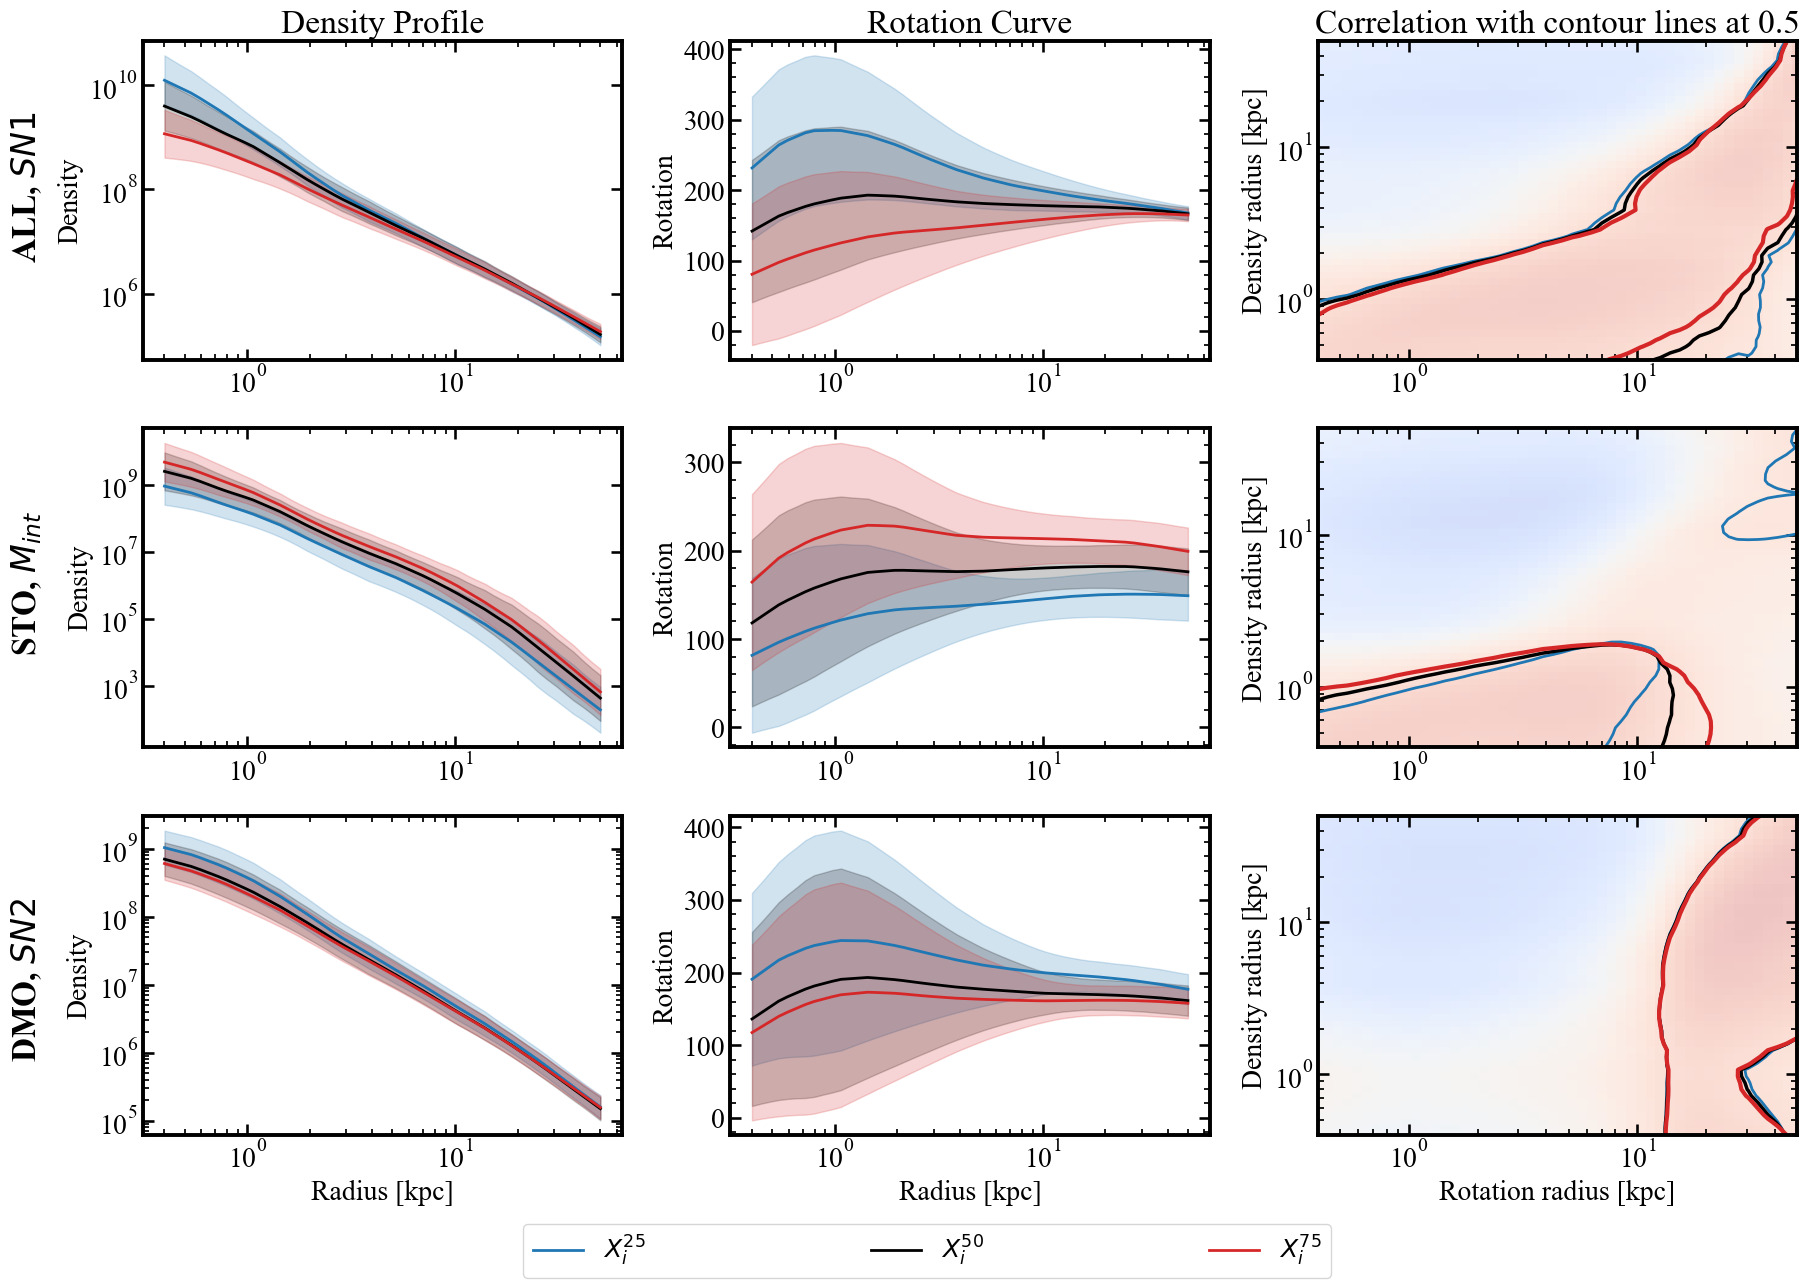

In [37]:
row_model_specs = [
    {
        "loader":      loaders["ALL"],
        "mean_net":    models["ALL"][0],
        "cov_net":     models["ALL"][1],
        "key_y_coeff": key_y_coeff["ALL"],
        "x_idx":       2,
        "row_label":   "ALL, $SN1$",
    },
    {
        "loader":      loaders["STO"],
        "mean_net":    models["STO"][0],
        "cov_net":     models["STO"][1],
        "key_y_coeff": key_y_coeff["STO"],
        "x_idx":       5,
        "row_label":   "STO, $M_{int}$",
    },
    {
        "loader":      loaders["DMO"],
        "mean_net":    models["DMO"][0],
        "cov_net":     models["DMO"][1],
        "key_y_coeff": key_y_coeff["DMO"],
        "x_idx":       3,
        "row_label":   "DMO, $SN2$",
    },
]

fig = plot_profiles_and_C12_percentiles_grid(
    loader=None,       # ignored when row_model_specs is provided
    mean_net=None,     # ignored
    cov_net=None,      # ignored
    key_y_coeff=None,  # ignored
    basis_meta=basis_meta,
    device=device,
    r_tags=r_tags,
    x_indices=None,    # ignored
    level=0.5,         # example contour level
    Y1_len=50,
    percentiles=(25, 50, 75),
    ci_sigma=2.0,
    show_background=True,
    background_alpha=0.30,
    background_source="p50",
    linewidths=(2.0, 2.5, 3.0),
    linestyles=("-", "-", "-"),
    savepath="/home/gjc7gx/CovNNet/Figures/profiles_C12_multi_model.png",
    title="Profiles + C12 (multi-model rows)",
    row_model_specs=row_model_specs,
)


Saved: /home/gjc7gx/CovNNet/Figures/ALL_vs_ALLmass_comparison.png


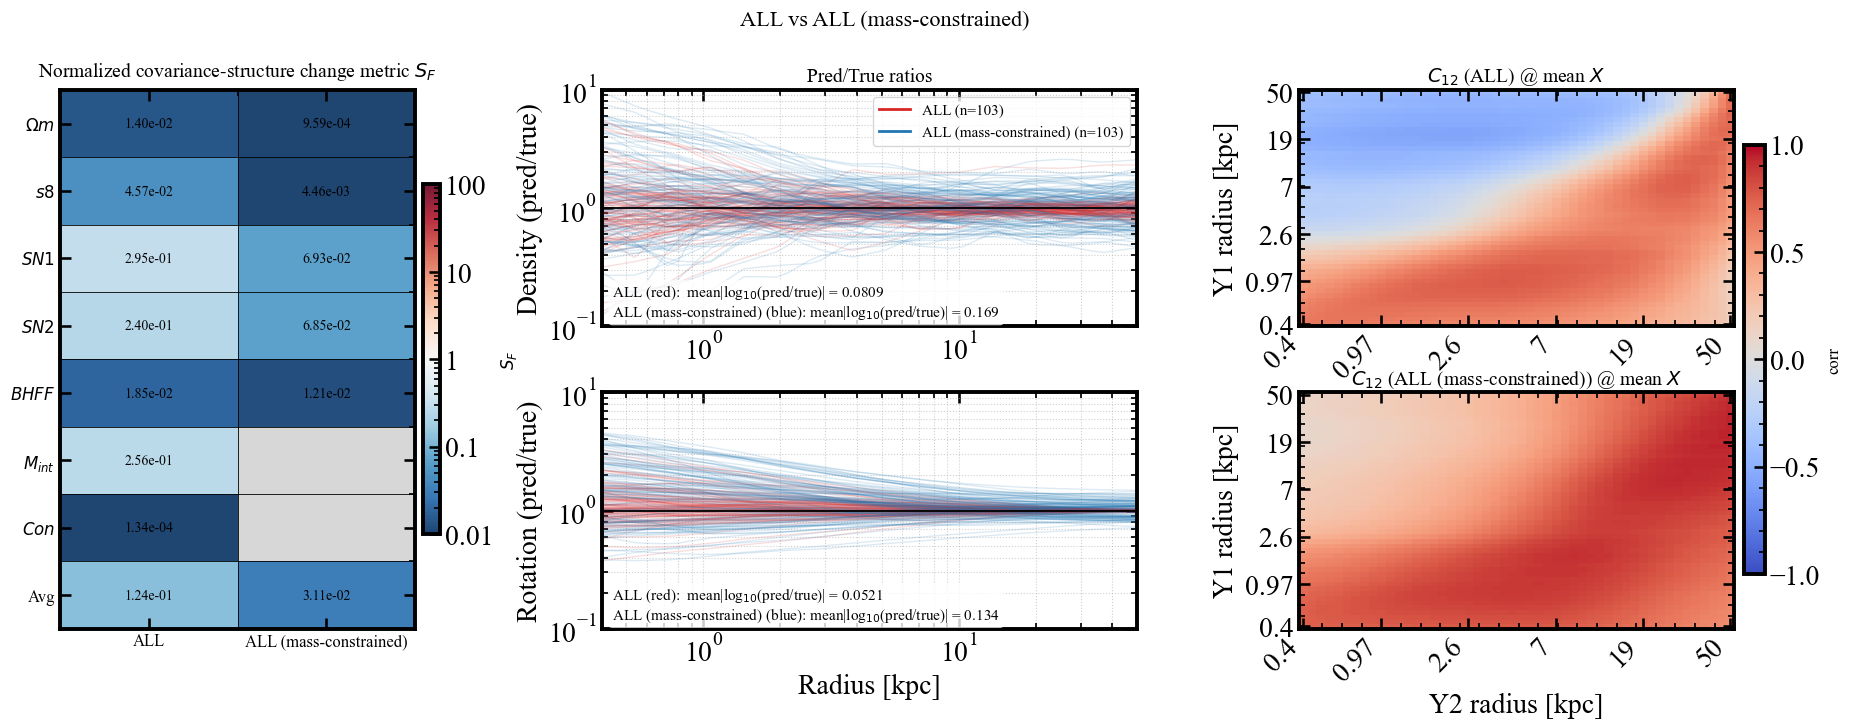

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def plot_condition_comparison_A_vs_B(
    # ----- condition A -----
    name_A: str,
    loader_A,
    mean_net_A,
    cov_net_A,
    key_y_A,
    SF_A,                  # 1D array/list, length <= len(param_labels)
    # ----- condition B -----
    name_B: str,
    loader_B,
    mean_net_B,
    cov_net_B,
    key_y_B,
    SF_B,                  # 1D array/list, length <= len(param_labels)
    # ----- shared -----
    param_labels,
    basis_meta,
    r_tags,
    device,
    Y1_len=50,
    # scalar-table options (UPDATED defaults)
    table_title=r"Normalized covariance-structure change metric $S_F$",
    table_cmap="RdBu_r",       # NEW default
    table_vmin=None,           # if None -> symmetric around 0
    table_vmax=None,
    table_text_fmt="{:.2e}",
    table_alpha=0.90,
    add_avg_row=True,          # NEW default
    avg_row_label="Avg",
    rotate_x=0,
    # pred/true options (UPDATED: remove % outside 2σ)
    max_curves=None,
    alpha=0.15,
    lw=1.0,
    density_ylim=(1e-1, 1e1),
    v_ylim=(1e-1, 1e1),
    text_box_alpha=0.80,
    # C12 options (UPDATED: show both blocks instead of diff)
    c12_cmap="coolwarm",
    c12_vmin=-1.0,
    c12_vmax= 1.0,
    # misc
    title=None,
    savepath=None,
):
    """
    Figure comparing condition A vs condition B:

      LEFT   : 2-column scalar table for S_F (A vs B), grey for missing rows,
               plus bottom Avg row (column-wise mean).
      MIDDLE : pred/true ratios overlay (A red, B blue): density(top), rotation(bottom),
               textbox shows mean |log10(pred/true)| for both.
      RIGHT  : two panels: C12_A and C12_B at mean X.
    """
    assert basis_meta is not None and basis_meta.get("use_basis", False), "basis_meta['use_basis'] must be True."

    eps = 1e-30
    r = np.asarray(r_tags, dtype=float)

    # ---- basis info ----
    k1   = int(basis_meta["y1"]["k"])
    Phi1 = np.asarray(basis_meta["y1"]["Phi"], dtype=np.float64)
    Phi2 = np.asarray(basis_meta["y2"]["Phi"], dtype=np.float64)
    LOG1 = bool(basis_meta["y1"].get("logspace", False))
    LOG2 = bool(basis_meta["y2"].get("logspace", False))

    # -------------------- layout --------------------
    # 2 rows x 4 cols:
    # [table] [pred/true den] [C12_A]
    # [table] [pred/true rot] [C12_B]
    fig = plt.figure(figsize=(22, 7))
    gs = fig.add_gridspec(
        nrows=2, ncols=3,
        width_ratios=[1.10, 1.55, 1.35],
        height_ratios=[1.0, 1.0],
        wspace=0.35, hspace=0.28
    )

    ax_table = fig.add_subplot(gs[:, 0])      # spans both rows
    ax_den   = fig.add_subplot(gs[0, 1])
    ax_rot   = fig.add_subplot(gs[1, 1], sharex=ax_den)
    ax_c12A  = fig.add_subplot(gs[0, 2])
    ax_c12B  = fig.add_subplot(gs[1, 2], sharex=ax_c12A, sharey=ax_c12A)

    # ============================================================
    # LEFT: scalar table (2 columns: A, B) + Avg row (UPDATED)
    # ============================================================
    param_labels = list(param_labels)
    n_param = len(param_labels)

    def _pad_sf(sf):
        sf = np.asarray(sf, dtype=float).ravel()
        out = np.full((n_param,), np.nan, dtype=float)
        n_use = min(len(sf), n_param)
        if n_use > 0:
            out[:n_use] = sf[:n_use]
        return out

    colA = _pad_sf(SF_A)
    colB = _pad_sf(SF_B)
    M = np.column_stack([colA, colB])  # [n_param, 2]

    row_labels = param_labels.copy()
    if add_avg_row:
        avg_row = np.nanmean(M, axis=0, keepdims=True)  # [1,2]
        M_plot = np.vstack([M, avg_row])
        row_labels = row_labels + [avg_row_label]
    else:
        M_plot = M

    # Use masked array to grey-out NaNs
    M_masked = np.ma.masked_invalid(M_plot)

    # Choose vmin/vmax automatically if not given (symmetric about 0)
    finite_vals = np.asarray(M_plot[np.isfinite(M_plot)], dtype=float)
    if (table_vmin is None) or (table_vmax is None):
        if finite_vals.size > 0:
            m = np.nanmax(np.abs(finite_vals))
            vmin = -m if table_vmin is None else table_vmin
            vmax =  m if table_vmax is None else table_vmax
        else:
            vmin, vmax = -1.0, 1.0
    else:
        vmin, vmax = table_vmin, table_vmax

    norm = LogNorm(vmin=1e-2, vmax=1e2)

    imT = ax_table.imshow(
        M_masked,
        aspect="auto",
        cmap=table_cmap,
        norm=norm,
        alpha=table_alpha,
    )
    imT.cmap.set_bad(color="lightgray")

    ax_table.set_xticks([0, 1])
    ax_table.set_xticklabels([name_A, name_B], rotation=rotate_x, ha="center", fontsize=12)
    ax_table.set_yticks(np.arange(len(row_labels)))
    ax_table.set_yticklabels(row_labels, fontsize=12)

    # grid lines
    ax_table.set_xticks(np.arange(-0.5, 2, 1), minor=True)
    ax_table.set_yticks(np.arange(-0.5, len(row_labels), 1), minor=True)
    ax_table.grid(which="minor", color="k", linewidth=0.6)
    ax_table.tick_params(which="minor", bottom=False, left=False)

    # annotate cells
    for i in range(M_plot.shape[0]):
        for j in range(2):
            val = M_plot[i, j]
            if not np.isfinite(val):
                txt = ""
                color = "black"
            else:
                txt = table_text_fmt.format(val)
                # choose text color based on normalized value in [0,1]
                t = (val - vmin) / (vmax - vmin + 1e-30)
                color = "white" if t > 100 else "black"

            ax_table.text(j, i, txt, ha="center", va="center", fontsize=10, color=color)

    ax_table.set_title(table_title, fontsize=14, pad=10)

    cbarT = fig.colorbar(imT, ax=ax_table, fraction=0.046, pad=0.02)
    cbarT.set_label(r"$S_F$", fontsize=12)

    ticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]
    cbarT.set_ticks(ticks)
    cbarT.set_ticklabels([f"{t:g}" for t in ticks])

    # ============================================================
    # MIDDLE: pred/true overlay + mean log error only (UPDATED)
    # ============================================================
    def _plot_predtrue_and_meanlog(ax_den, ax_rot, loader, mean_net, cov_net, key_y, color):
        """
        Plots pred/true curves and returns:
          - n_plotted
          - mean_logerr_den, mean_logerr_rot  (mean over sims)
        """
        mean_net.eval()
        cov_net.eval()

        n_plotted = 0
        sum_logerr_den = 0.0
        sum_logerr_rot = 0.0
        n_sims = 0

        for batch in loader:
            if isinstance(batch, (tuple, list)):
                x_b, y_b = batch[0], batch[1]
            elif isinstance(batch, dict):
                x_b = batch.get("x", batch.get("X"))
                y_b = batch.get("y", batch.get("Y"))
            else:
                raise TypeError(f"Unknown batch type: {type(batch)}")

            x_b = x_b.to(device).float()
            y_b = y_b.to(device).float()

            mu_n_b = mean_net(x_b)
            mu_n = mu_n_b.detach().cpu().numpy()
            y_n  = y_b.detach().cpu().numpy()

            B = mu_n.shape[0]
            for i in range(B):
                if (max_curves is not None) and (n_plotted >= max_curves):
                    break

                mu_coeff = _denorm(mu_n[i], key_y)
                y_coeff  = _denorm(y_n[i],  key_y)

                c1_mu, c2_mu = mu_coeff[:k1], mu_coeff[k1:]
                c1_tr, c2_tr = y_coeff[:k1],  y_coeff[k1:]

                lin_mu1 = Phi1 @ c1_mu
                lin_tr1 = Phi1 @ c1_tr
                den_mu1 = np.exp(lin_mu1) if LOG1 else lin_mu1
                den_tr1 = np.exp(lin_tr1) if LOG1 else lin_tr1

                lin_mu2 = Phi2 @ c2_mu
                lin_tr2 = Phi2 @ c2_tr
                den_mu2 = np.exp(lin_mu2) if LOG2 else lin_mu2
                den_tr2 = np.exp(lin_tr2) if LOG2 else lin_tr2

                ratio1 = (den_mu1 + eps) / (den_tr1 + eps)
                ratio2 = (den_mu2 + eps) / (den_tr2 + eps)

                ax_den.plot(r, ratio1, alpha=alpha, lw=lw, color=color)
                ax_rot.plot(r, ratio2, alpha=alpha, lw=lw, color=color)

                # mean log error per sim
                logerr_den = float(np.mean(np.abs(np.log10((den_mu1 + eps) / (den_tr1 + eps)))))
                logerr_rot = float(np.mean(np.abs(np.log10((den_mu2 + eps) / (den_tr2 + eps)))))

                sum_logerr_den += logerr_den
                sum_logerr_rot += logerr_rot
                n_sims += 1

                n_plotted += 1

            if (max_curves is not None) and (n_plotted >= max_curves):
                break

        mean_logerr_den = sum_logerr_den / max(n_sims, 1)
        mean_logerr_rot = sum_logerr_rot / max(n_sims, 1)
        return n_plotted, mean_logerr_den, mean_logerr_rot

    nA, A_den_err, A_rot_err = _plot_predtrue_and_meanlog(
        ax_den, ax_rot, loader_A, mean_net_A, cov_net_A, key_y_A, color="tab:red"
    )
    nB, B_den_err, B_rot_err = _plot_predtrue_and_meanlog(
        ax_den, ax_rot, loader_B, mean_net_B, cov_net_B, key_y_B, color="tab:blue"
    )

    for ax_ in (ax_den, ax_rot):
        ax_.set_xscale("log")
        ax_.set_yscale("log")
        ax_.axhline(1.0, color="k", lw=1.3)
        ax_.set_xlim(r.min(), r.max())
        ax_.grid(True, which="both", linestyle=":", alpha=0.6)

    ax_den.set_ylim(*density_ylim)
    ax_rot.set_ylim(*v_ylim)

    ax_den.set_title("Pred/True ratios", fontsize=14)
    ax_den.set_ylabel("Density (pred/true)")
    ax_rot.set_ylabel("Rotation (pred/true)")
    ax_rot.set_xlabel("Radius [kpc]")

    # legend
    ax_den.plot([], [], color="tab:red",  lw=2, label=f"{name_A} (n={nA})")
    ax_den.plot([], [], color="tab:blue", lw=2, label=f"{name_B} (n={nB})")
    ax_den.legend(loc="upper right", fontsize=11, frameon=True)

    # textboxes (mean log err only)
    bbox = dict(boxstyle="round,pad=0.25", facecolor="white", alpha=text_box_alpha, edgecolor="none")

    txt_den = (
        f"{name_A} (red):  mean|log$_{{10}}$(pred/true)| = {A_den_err:.3g}\n"
        f"{name_B} (blue): mean|log$_{{10}}$(pred/true)| = {B_den_err:.3g}"
    )
    ax_den.text(0.02, 0.02, txt_den, transform=ax_den.transAxes,
                ha="left", va="bottom", fontsize=11, bbox=bbox)

    txt_rot = (
        f"{name_A} (red):  mean|log$_{{10}}$(pred/true)| = {A_rot_err:.3g}\n"
        f"{name_B} (blue): mean|log$_{{10}}$(pred/true)| = {B_rot_err:.3g}"
    )
    ax_rot.text(0.02, 0.02, txt_rot, transform=ax_rot.transAxes,
                ha="left", va="bottom", fontsize=11, bbox=bbox)

    # ============================================================
    # RIGHT: show C12_A and C12_B (UPDATED)
    # ============================================================
    xA = _mean_x_from_loader(loader_A, device=device, max_batches=None)
    xB = _mean_x_from_loader(loader_B, device=device, max_batches=None)

    C12_A = _C12_at_x(mean_net_A, cov_net_A, xA, device, key_y_A, basis_meta, Y1_len=Y1_len)
    C12_B = _C12_at_x(mean_net_B, cov_net_B, xB, device, key_y_B, basis_meta, Y1_len=Y1_len)

    imA = ax_c12A.imshow(C12_A, vmin=c12_vmin, vmax=c12_vmax, cmap=c12_cmap, origin="upper", aspect="auto")
    ax_c12A.invert_yaxis()
    imB = ax_c12B.imshow(C12_B, vmin=c12_vmin, vmax=c12_vmax, cmap=c12_cmap, origin="upper", aspect="auto")
    ax_c12B.invert_yaxis()

    ax_c12A.set_title(rf"$C_{{12}}$ ({name_A}) @ mean $X$", fontsize=14)
    ax_c12B.set_title(rf"$C_{{12}}$ ({name_B}) @ mean $X$", fontsize=14)

    for ax in (ax_c12A, ax_c12B):
        ax.set_xlabel("Y2 radius [kpc]")
        ax.set_ylabel("Y1 radius [kpc]")
        ax.invert_yaxis()

    # radius ticks
    n_r_ticks = 6
    tick_idx = np.unique(np.linspace(0, len(r) - 1, n_r_ticks).astype(int))
    tick_lbl = [f"{val:.2g}" for val in r[tick_idx]]

    for ax in (ax_c12A, ax_c12B):
        ax.set_xticks(tick_idx)
        ax.set_xticklabels(tick_lbl, rotation=45, ha="right")
        ax.set_yticks(tick_idx)
        ax.set_yticklabels(tick_lbl)

    # one colorbar for both C12s
    cbar2 = fig.colorbar(imA, ax=[ax_c12A, ax_c12B], fraction=0.046, pad=0.02)
    cbar2.set_label("corr", fontsize=12)

    # -------------------- title / save --------------------
    if title:
        fig.suptitle(title, fontsize=16, y=0.995)

    if savepath:
        plt.savefig(savepath, dpi=170, bbox_inches="tight")
        print("Saved:", savepath)

    return fig, dict(
        C12_A=C12_A, C12_B=C12_B,
        metrics=dict(
            A=dict(mean_logerr_den=A_den_err, mean_logerr_rot=A_rot_err),
            B=dict(mean_logerr_den=B_den_err, mean_logerr_rot=B_rot_err),
        )
    )



fig, out = plot_condition_comparison_A_vs_B(
    name_A="ALL",
    loader_A=ALL_test_loader,
    mean_net_A=ALL_mean_net,
    cov_net_A=ALL_cov_net,
    key_y_A=ALL_Yn_key,
    SF_A=ALL_S_F,

    name_B="ALL (mass-constrained)",
    loader_B=NOMASS_ALL_test_loader,
    mean_net_B=NOMASS_ALL_mean_net,
    cov_net_B=NOMASS_ALL_cov_net,
    key_y_B=NOMASS_ALL_Yn_key,
    SF_B=NOMASS_S_F,

    param_labels=param_labels,
    basis_meta=basis_meta,
    r_tags=r_tags,
    device=device,

    title="ALL vs ALL (mass-constrained)",
    savepath="/home/gjc7gx/CovNNet/Figures/ALL_vs_ALLmass_comparison.png",
)


In [223]:
def plot_one_test_profile_vs_two_txt_preds_with_dataset_stats(
    test_loader,
    ALL_mean_net,
    ALL_cov_net,
    device,
    Yn_key,
    basis_meta,
    r_tags,
    y1_txt_A, y2_txt_A,
    y1_txt_B, y2_txt_B,
    ci_sigma=2.0,
    yscale_y1="log",
    yscale_y2="log",
    savepath=None,
    idx_list=[0, 5, 10, 13, 14],
    sample_index_from_loader=None,  # NEW: callable(batch_x, batch_y, local_i, global_i)-> int
):

    r = np.asarray(r_tags, dtype=float)

    # ---------- 0) collect requested idx_list samples across the loader ----------

    if idx_list is None:
        raise ValueError("idx_list must be provided, e.g. [0, 5, 10, 13, 14]")

    # ensure deterministic order
    idx_list = list(idx_list)
    idx_set = set(idx_list)

    xs = {}
    ys = {}

    global_i = 0

    for xb, yb in test_loader:
        B = xb.shape[0]
        for j in range(B):

            # determine the global sample index
            if sample_index_from_loader is not None:
                sample_idx = int(sample_index_from_loader(xb, yb, j, global_i))
            else:
                sample_idx = global_i

            # store if requested
            if sample_idx in idx_set and sample_idx not in xs:
                xs[sample_idx] = xb[j]
                ys[sample_idx] = yb[j]

            global_i += 1

        # stop early if all indices found
        if len(xs) == len(idx_set):
            break

    # sanity check
    missing = [i for i in idx_list if i not in xs]
    if missing:
        raise ValueError(f"Requested idx not found in loader: {missing}")

    # stack in requested order
    xb_use = torch.stack([xs[i] for i in idx_list], dim=0).to(device)
    yb_use = torch.stack([ys[i] for i in idx_list], dim=0).to(device)

    idxs = idx_list[:]   # used later for TXT lookup and titles
    n_use = len(idxs)

    if len(xs) == 0:
        raise ValueError("test_loader produced no samples.")

    # stack in requested order
    missing = [i for i in idx_list if i not in xs]
    if missing:
        raise ValueError(f"Requested idx not found in loader: {missing}")

    xb_use = torch.stack([xs[i] for i in idx_list], dim=0).to(device)
    yb_use = torch.stack([ys[i] for i in idx_list], dim=0).to(device)
    idxs = list(idx_list)
    n_use = len(idxs)

    # ---------- 1) load TXT preds ----------
    idxA1, _, predA1 = _load_test_profiles_txt(y1_txt_A)
    idxA2, _, predA2 = _load_test_profiles_txt(y2_txt_A)
    idxB1, _, predB1 = _load_test_profiles_txt(y1_txt_B)
    idxB2, _, predB2 = _load_test_profiles_txt(y2_txt_B)

    def _row_for_index(idx_arr, wanted):
        w = np.where(idx_arr == wanted)[0]
        return int(w[0]) if len(w) else None

    # ---------- 2) dataset-wide stats ----------
    online_mean_y1, online_mean_y2 = _mean_abs_log10_online_over_loader(
        ALL_mean_net, test_loader, Yn_key, basis_meta, Y1_len=len(r_tags)
    )
    txtA_mean_y1 = _mean_abs_log10_from_txt(y1_txt_A)
    txtA_mean_y2 = _mean_abs_log10_from_txt(y2_txt_A)
    txtB_mean_y1 = _mean_abs_log10_from_txt(y1_txt_B)
    txtB_mean_y2 = _mean_abs_log10_from_txt(y2_txt_B)

    # ---------- 3) figure: 2 rows × n_use columns ----------
    fig, axes = plt.subplots(
        2, n_use,
        figsize=(4.6 * n_use, 8),
        sharex="col",
        sharey="row"
    )
    if n_use == 1:
        axes = axes[:, None]

    alpha = 0.8

    for col in range(n_use):
        xb_i = xb_use[col]
        yb_i = yb_use[col]
        sample_idx = idxs[col]  # used for TXT lookup + annotation

        y_true = yb_i.detach().cpu().numpy()
        true_y1 = reconstruct_profile_from_output(y_true, Yn_key, basis_meta, "Y1")
        true_y2 = reconstruct_profile_from_output(y_true, Yn_key, basis_meta, "Y2")

        pred_y1, pred_y2, lo1, up1, lo2, up2 = _online_profiles_and_band_one(
            ALL_mean_net, ALL_cov_net, xb_i, Yn_key, basis_meta, ci_sigma
        )

        rowA = _row_for_index(idxA1, sample_idx)
        rowB = _row_for_index(idxB1, sample_idx)

        if rowA is None:
            txtA_y1 = np.full_like(true_y1, np.nan, dtype=float)
            txtA_y2 = np.full_like(true_y2, np.nan, dtype=float)
        else:
            txtA_y1 = predA1[rowA]
            txtA_y2 = predA2[rowA]

        if rowB is None:
            txtB_y1 = np.full_like(true_y1, np.nan, dtype=float)
            txtB_y2 = np.full_like(true_y2, np.nan, dtype=float)
        else:
            txtB_y1 = predB1[rowB]
            txtB_y2 = predB2[rowB]

        # ===== Y1 ROW =====
        ax = axes[0, col]
        ax.plot(r, true_y1, lw=3.5, color="k", label="True")
        ax.plot(r, pred_y1, lw=2, color="tab:blue", label="ALL CovNet", alpha=alpha)
        ax.plot(r, txtA_y1, lw=2, color="tab:red", label="TXT A", alpha=alpha)
        ax.plot(r, txtB_y1, lw=2, color="tab:orange", label="TXT B", alpha=alpha)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(5e4, 1e11)
        ax.set_title(f"sample_index = {sample_idx}")

        # ===== Y2 ROW =====
        ax = axes[1, col]
        ax.plot(r, true_y2, lw=3.5, color="k", label="True")
        ax.plot(r, pred_y2, lw=2, color="tab:blue", label="ALL CovNet", alpha=alpha)
        ax.plot(r, txtA_y2, lw=2, color="tab:red", label="TXT A", alpha=alpha)
        ax.plot(r, txtB_y2, lw=2, color="tab:orange", label="TXT B", alpha=alpha)
        ax.set_xscale("log")
        if yscale_y2 == "log":
            ax.set_yscale("log")
        ax.set_ylim(10, 400)

        if col == 0:
            axes[0, col].set_ylabel("Density")
            axes[1, col].set_ylabel("Rotation")

        axes[1, col].set_xlabel("Radius [kpc]")

    # ---------- 4) stats table with legend-style line annotations ----------
    ax_table = fig.add_axes([0.37, -0.06, 0.5, 0.16])
    ax_table.axis("off")

    row_labels = [
        "-       True",
        "-       Online ALL CovNet",
        f"-       TXT A ({os.path.basename(y1_txt_A)})",
        f"-       TXT B ({os.path.basename(y1_txt_B)})",
    ]
    col_labels = ["Y1", "Y2"]

    cell_text = [
        ["- - -", "- - -"],
        [f"{online_mean_y1:.3g}", f"{online_mean_y2:.3g}"],
        [f"{txtA_mean_y1:.3g}",   f"{txtA_mean_y2:.3g}"],
        [f"{txtB_mean_y1:.3g}",   f"{txtB_mean_y2:.3g}"],
    ]

    tbl = ax_table.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc="center",
        colLoc="center",
        loc="center",
    )

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(16)
    tbl.scale(1.2, 1.5)

    for (row, col), cell in tbl.get_celld().items():
        cell.set_edgecolor("black")
        if row == 0:
            cell.set_text_props(weight="bold")

    legend_styles = [
        dict(color="k",          lw=3.5),  # True
        dict(color="tab:blue",   lw=2.0),  # Online
        dict(color="tab:red",    lw=2.0),  # TXT A
        dict(color="tab:orange", lw=2.0),  # TXT B
    ]

    fig.canvas.draw()

    anchor = -0.0
    gap = -0.005
    ROW_OFFSETS = {
        1: anchor,
        2: anchor + gap,
        3: anchor + 2 * gap,
        4: anchor + 3 * gap,
    }

    for i, style in enumerate(legend_styles, start=1):
        cell = tbl.get_celld()[(i, -1)]
        bbox = cell.get_window_extent(fig.canvas.get_renderer())
        inv = ax_table.transAxes.inverted()
        (x0, y0) = inv.transform((bbox.x0, bbox.y0))
        (x1, y1) = inv.transform((bbox.x1, bbox.y1))

        x_shift = 0
        x_start = x0 + 0.05 * (x1 - x0) + x_shift
        x_end   = x0 + 0.15 * (x1 - x0) + x_shift
        y_mid   = 0.5 * (y0 + y1) + ROW_OFFSETS[i]

        ax_table.plot(
            [x_start, x_end],
            [y_mid, y_mid],
            transform=ax_table.transAxes,
            color=style["color"],
            lw=style["lw"],
            solid_capstyle="round",
            clip_on=False,
        )

    plt.tight_layout(rect=[0, 0.12, 1, 1])

    if savepath:
        plt.savefig(savepath, dpi=170, bbox_inches="tight")
        print("Saved:", savepath)

    return fig


/tmp/ipykernel_126640/3348927316.py:247: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


Saved: /home/gjc7gx/CovNNet/Figures/one_example_true_vs_online_vs_txtA_vs_txtB.png


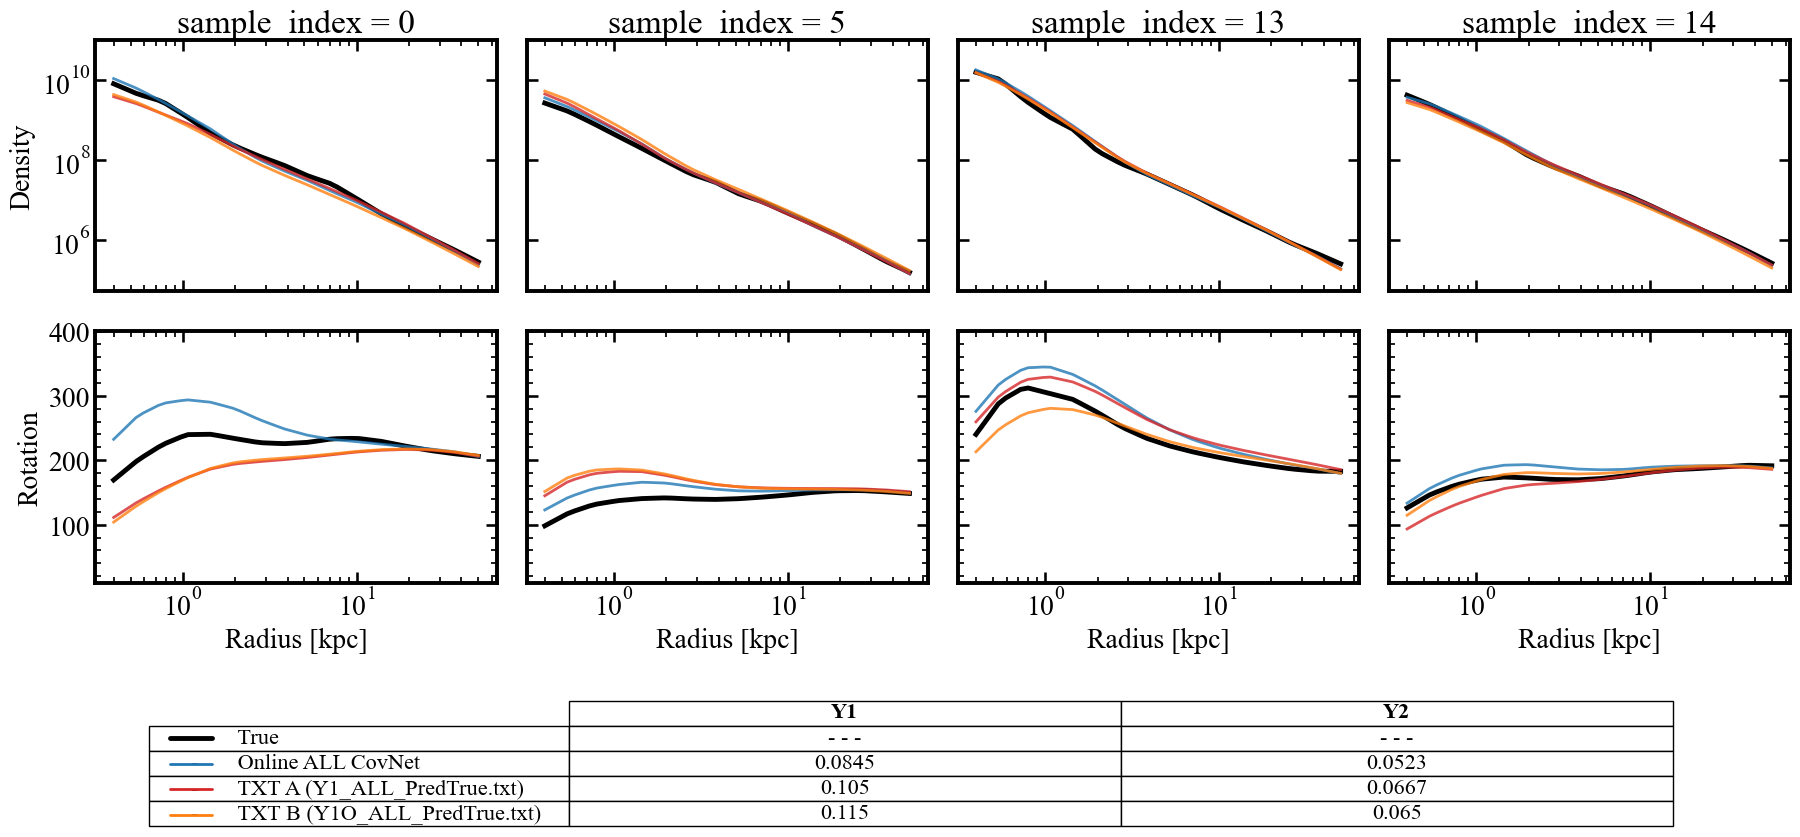

In [224]:
fig = plot_one_test_profile_vs_two_txt_preds_with_dataset_stats(
    test_loader=ALL_test_loader,
    ALL_mean_net=ALL_mean_net,
    ALL_cov_net=ALL_cov_net,
    device=device,
    Yn_key=ALL_Yn_key,
    basis_meta=basis_meta,
    r_tags=r_tags,
    y1_txt_A="/home/gjc7gx/CovNNet/Params/Y1_ALL_PredTrue.txt",
    y2_txt_A="/home/gjc7gx/CovNNet/Params/Y2_ALL_PredTrue.txt",
    y1_txt_B="/home/gjc7gx/CovNNet/Params/Y1O_ALL_PredTrue.txt",
    y2_txt_B="/home/gjc7gx/CovNNet/Params/Y2O_ALL_PredTrue.txt",
    ci_sigma=2.0,
    yscale_y1="log",
    yscale_y2="linear",
    savepath="/home/gjc7gx/CovNNet/Figures/one_example_true_vs_online_vs_txtA_vs_txtB.png",
    idx_list=[0, 5, 13, 14],
)
